In [2]:
from typing import List, Tuple, Dict
import xml.etree.ElementTree as ET
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
EV_TO_NM = 1240
SUPPORTED_DATA_TYPES: List[str] = ['vasp']
VASP_METHODS = {
    'Normal': 'DFT', 'Fast' : 'DFT', 'Exact': 'DFT', 'DIAG': 'DFT', 
    'EVGW0': 'G0W0', 'BSE': 'BSE', 'TIMEEV': 'TIMEEV',  
    'CHI': 'CHI'}

class DataParsingError(Exception):
    pass

class DataNotFoundError(Exception):
    pass

@dataclass
class OpticsData:
    imag: pd.DataFrame
    real: pd.DataFrame
    type: str = 'epsilon'
    method: str = None
    comment: str = None
    cell: np.ndarray = None
    
class OpticsAnalyzer:
    
    def __init__(self, system: str, data: List[OpticsData] = None):
        self.system = system
        if data is None:
            self.data = []
        
    def __repr__(self):
        methods = set([item.method for item in self.data])
        return f"{self.__class__.__name__}(system={self.system}, data={methods})"
    
    def __str__(self):
        return self.__repr__()
    
    def plot(self, type: str = 'refraction', xlim: Tuple[int] = None, ylim: Tuple[int] = None, show: bool = False, savefig_folder: str = None):
        for data in self.data:
            if type == 'refraction':
                data = convert_epsilon_to_refractive_index(data)
            plot_data(data, xlim=xlim, ylim=ylim, show=show, savefig_folder=savefig_folder)

    def write(self, folder: str = './', refraction: bool = True):
        if not os.path.exists(folder):
            os.makedirs(folder)
        for data in self.data:
            if refraction:
                data = convert_epsilon_to_refractive_index(data)
                headers = ['k ', 'n ']
            else:
                headers = ['Im eps ', 'Re eps ']
            imag, real = data.imag, data.real
            all_data = pd.concat((imag, real[real.columns[1:]]), axis=1)
            columns = [imag.columns[0]]
            columns += [headers[0] + col for col in imag.columns[1:]]
            columns += [headers[1] + col for col in real.columns[1:]]
            all_data.columns = columns
            comment = data.comment.lower() if data.comment else 'default'
            all_data.to_csv(os.path.join(folder, f'{data.type}_{data.method}_{comment}.csv'))
            
    def read(self, data_file: str, data_type: str = 'vasp', comment: str = None, thickness_2d: float = None, thickness_3d: float = None):
        if data_type not in SUPPORTED_DATA_TYPES:
            raise ValueError(f'Only {SUPPORTED_DATA_TYPES} data_types are currently supported ')
        if data_type == 'vasp':
            if os.path.exists(data_file):
                try:
                    optics_data = read_vaspxml_data(data_file)
                    for data in optics_data:
                        if comment:
                            data.comment = comment
                        if thickness_2d:
                            coeff = (thickness_2d / thickness_3d)
                            data.imag.iloc[:, 1:] *= coeff
                            data.real.iloc[:, 1:] = (data.real.iloc[:, 1:] - 1) * coeff + 1
                    self.data += optics_data
                except:
                    raise DataParsingError(f'Cannot parse {data_file}. Please check if calculation is properly done.')
            else:
                raise FileNotFoundError(f'Cannot find {data_file}. Please check if file exists at specified path.')
                
def read_vaspxml_data(vaspxml: str) -> List[OpticsData]:
    data = []
    tree = ET.parse(vaspxml)
    root = tree.getroot()
    incar = root.findall('incar')[0]
    method = [item.text.split()[0] for item in incar if item.attrib['name'] == 'ALGO'][0]
    method = VASP_METHODS[method]
    crystal = root.findall('structure')[0].findall('crystal')[0].findall('varray')[0].findall('v')
    cell = []
    for row in crystal:
        cell.append([float(value) for value in row.text.split()])
    cell = np.array(cell)
    calculation = root.findall('calculation')[-1]
    dielectric_functions = calculation.findall('dielectricfunction')
    for dielectric_function in dielectric_functions:
        try:
            comment = dielectric_function.attrib['comment'].lower()
        except KeyError:
            comment = ''
        gw_allowed = method in ('G0W0', 'CHI') and ('dielectric' in comment or 'density' in comment)
        dft_allowed = method == 'DFT' and 'density' in comment
        bse_allowed = method == 'BSE'
        timeev_allowed = method == 'TIMEEV'
        data_allowed = dft_allowed or gw_allowed or timeev_allowed or bse_allowed
        if data_allowed:
            imaginary_part = dielectric_function[0]
            real_part = dielectric_function[1]
            fields = [item.text for item in imaginary_part[0].findall('field')]
            fields[0] = 'Energy, eV'
            imaginary_values = []
            real_values = []
            for row in imaginary_part[0][-1].findall('r'):
                imaginary_values.append([float(value) for value in row.text.split()])
            for row in real_part[0][-1].findall('r'):
                real_values.append([float(value) for value in row.text.split()])
            imaginary_data = pd.DataFrame(data=imaginary_values, columns=fields)
            real_data = pd.DataFrame(data=real_values, columns=fields)
            if gw_allowed and 'microscopic' in comment:
                comment = "Microscopic"
            elif gw_allowed and 'macroscopic' in comment:
                comment = 'Macroscopic'
            else:
                comment = ''
            optics_data = OpticsData(imag=imaginary_data, real=real_data, method=method, comment=comment, cell=cell)
            data.append(optics_data)
    return data

def convert_epsilon_to_refractive_index(optics_data: OpticsData) -> OpticsData:
    imaginary_data, real_data = optics_data.imag, optics_data.real
    columns = list(imaginary_data.columns)
    energy = imaginary_data[columns[0]]
    imaginary_values, real_values = imaginary_data[columns[1:]].values, real_data[columns[1:]].values
    modulus = np.sqrt(imaginary_values**2 + real_values**2) 
    imaginary_refractive_index_values = np.sqrt((modulus - real_values)/2)
    real_refractive_index_values = np.sqrt((modulus + real_values)/2)
    columns[0] = 'Wavelength, nm'
    imaginary_refractive_index_data = pd.DataFrame(columns=columns)
    real_refractive_index_data = pd.DataFrame(columns=columns)
    imaginary_refractive_index_data[columns[0]] = EV_TO_NM / energy
    real_refractive_index_data[columns[0]] = EV_TO_NM / energy
    imaginary_refractive_index_data[columns[1:]] = imaginary_refractive_index_values
    real_refractive_index_data[columns[1:]] = real_refractive_index_values
    new_optics_data = OpticsData(imag=imaginary_refractive_index_data.iloc[1:],
                                 real=real_refractive_index_data.iloc[1:],
                                 method=optics_data.method,
                                 type='refraction',
                                 comment=optics_data.comment)
    return new_optics_data


#def plot_data(ax, data, line, method=None, comment=None, type_key=None):
#    if method is None:
#        method = data.method
#    if comment is None:
#        comment = data.comment
#    xaxis_key = 'Wavelength, nm' if data.type == 'refraction' else 'Energy, eV'
#    if type_key is None:
#        type_keys = ['Re eps', 'Im eps'] if data.type == 'epsilon' else ['n', 'k']
#    else:
#        type_keys = [type_key]
#    for type_key in type_keys:
#        if type_key in ['Re eps', 'n']:
#            ax.plot(data.real[xaxis_key], data.real['xx'], line, label=f'{method} {comment}: {type_key}_xx')
#            ax.plot(data.real[xaxis_key], data.real['yy'], line, label=f'{method} {comment}: {type_key}_yy')
#            ax.plot(data.real[xaxis_key], data.real['zz'], line, label=f'{method} {comment}: {type_key}_zz')
#       elif type_key in ['Im eps', 'k']:
#            ax.plot(data.imag[xaxis_key], data.imag['xx'], line, label=f'{method} {comment}: {type_key}_xx')
#            ax.plot(data.imag[xaxis_key], data.imag['yy'], line, label=f'{method} {comment}: {type_key}_yy')
#            ax.plot(data.imag[xaxis_key], data.imag['zz'], line, label=f'{method} {comment}: {type_key}_zz')


In [5]:
def plot_data(data, xlim=None, ylim=None, show=False, savefig_folder=None):
    fig, ax = plt.subplots()
    xaxis_key = 'Wavelength, nm' if data.type == 'refraction' else 'Energy, eV'
    # Example plot
    ax.plot(data.real[xaxis_key], data.real['xx'], label='n_xx')
    ax.plot(data.real[xaxis_key], data.real['yy'], label='n_yy')
    ax.plot(data.real[xaxis_key], data.real['zz'], label='n_zz')
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.set_xlabel(xaxis_key)
    ax.set_ylabel('n')
    ax.legend()
    if savefig_folder:
        filename = f"{data.method}_{data.comment}_plot.png"
        plt.savefig(os.path.join(savefig_folder, filename))
    if show:
        plt.show()
    else:
        plt.close(fig)

In [5]:
d={'dir_name':['c2db_A2B3_2V2S3_1','c2db_A2B3_1Bi2Se3_1', 'c2db_AB_2CoSe_3', 'c2db_AB2_1HfSe2_1', 'c2db_A2B5_1Au2S5_1', 'agm2000060793', 'agm2000110562', 'agm2000064981',  'agm2000142235', 'agm2000137470', 'agm2000110430'], 'formula':['V2S3', 'Bi2Se3','Co2Se2', 'HfSe2', 'Au2S5', 'V2Se2S', 'Bi2Te2Se', 'FeCoSe2', 'HfTeSe', 'AuHfTe5',  'ScPS4'],'thickness_2D':[12.6,10.2, 6.34, 6.35, 6.32,10.122,11.4,6.574, 7.83, 8.116, 8.499], 'lattice_c':[24.3,36.98, 17.45, 18.143, 31.73, 21.322, 22.2,17.774, 18.63, 18.916, 18.8991]}
df = pd.DataFrame(data=d)

In [6]:
df_new = df.copy()

In [7]:
df_new

dir_name   formula  thickness_2D  lattice_c
0     c2db_A2B3_2V2S3_1      V2S3        12.600    24.3000
1   c2db_A2B3_1Bi2Se3_1    Bi2Se3        10.200    36.9800
2       c2db_AB_2CoSe_3    Co2Se2         6.340    17.4500
3     c2db_AB2_1HfSe2_1     HfSe2         6.350    18.1430
4    c2db_A2B5_1Au2S5_1     Au2S5         6.320    31.7300
5         agm2000060793    V2Se2S        10.122    21.3220
6         agm2000110562  Bi2Te2Se        11.400    22.2000
7         agm2000064981   FeCoSe2         6.574    17.7740
8         agm2000142235    HfTeSe         7.830    18.6300
9         agm2000137470   AuHfTe5         8.116    18.9160
10        agm2000110430     ScPS4         8.499    18.8991

In [6]:
df_new = pd.read_csv('/home/u7c/lusya/2D_materials/C2DB/alexandria/full_filtered_test_Ax_Bx.csv', skipinitialspace=True)

In [7]:
df_new.head()

structure formula  Ax_scaled  \
0  {"@module": "pymatgen.core.structure", "@class...  Mo3WS8   0.514311   
1  {"@module": "pymatgen.core.structure", "@class...   MoWS4   0.529394   
2  {"@module": "pymatgen.core.structure", "@class...   MoSeS   0.564743   
3  {"@module": "pymatgen.core.structure", "@class...  MoW3S8   0.524061   
4  {"@module": "pymatgen.core.structure", "@class...     WS2   0.528378   

   Bx_scaled  spg         mat_id  e_above_hull  cosine_distance  \
0   0.147742   25  agm2000111658      0.000398         0.006265   
1   0.146872   25  agm2000111649      0.000000         0.024635   
2   0.164690  156  agm2000110749      0.009946         0.033672   
3   0.187824   25  agm2000111659      0.000397         0.053687   
4   0.167524  187  agm2000003615      0.002027         0.091146   

        Bx_final  Ax_final  thickness_2D  lattice_c  
0  416643.208452  3.390110      6.736078  18.136078  
1  414194.300025  3.484848      6.738735  18.138735  
2  464371.975023  3.706879      6.938540  18.238540  
3  529521.029888  3.451347      6.742482  18.142482  
4  472353.325835  3.478466      6.745825  18.145825

In [8]:
df_new[df_new['formula']=='V2Se2S']

structure formula  Ax_scaled  \
16  {"@module": "pymatgen.core.structure", "@class...  V2Se2S   0.642568   

    Bx_scaled  spg         mat_id  e_above_hull  cosine_distance  \
16   0.148885  187  agm2000060793           0.0         0.201073   

        Bx_final  Ax_final  thickness_2D  lattice_c  
16  419862.91644    4.1957     10.122248  21.322248

In [9]:
df_new.shape

(310, 12)

In [10]:
import os
# Lists to store n_xx values for specified wavelengths
n_xx_755 = []
n_xx_785 = []
n_xx_1064 = []
base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/alex_fin_full/'
# Example wavelength range where we want the ML predictions
wavelength_range = np.linspace(700, 1100, 500)

# Iterate over materials in df_new
for j, dir_name in enumerate(df_new['mat_id']):
    SYSTEM = str(dir_name)
    print(SYSTEM)
    
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = df_new['lattice_c'][j]
    THICKNESS_3D = df_new['thickness_2D'][j]
    FORMULA = df_new['formula'][j]
    A_values = df_new['Ax_final'][j] 
    B_values = df_new['Bx_final'][j] 
    

    
    # Read in the DFT data (assuming vasprun.xml is present)
    vasprun_dft = os.path.join(base_path, f'{SYSTEM}/vasprun.xml')
    
    try:
        # Load and convert to n, k
        analyzer.read(vasprun_dft, thickness_2d=THICKNESS_2D, thickness_3d=THICKNESS_3D)
        dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    except (FileNotFoundError, DataParsingError) as e:
        print(f"Skipping {SYSTEM} due to error: {e}")
        n_xx_755.append(np.nan)
        n_xx_785.append(np.nan)
        n_xx_1064.append(np.nan)
        continue
    
    # Extract DFT-based refractive index for the "xx" component
    dft_wavelengths = dft_data.real['Wavelength, nm'].values
    data=dft_data
    #dft_n_xx = dft_data.real['xx'].values
    df_1 = data.real[data.real['Wavelength, nm'].between(740, 765)].iloc[0]
    df_2 = data.real[data.real['Wavelength, nm'].between(770, 800)].iloc[0]
    df_3 = data.real[data.real['Wavelength, nm'].between(1050, 1100)].iloc[0]
    # Interpolate to find n_xx at required wavelengths
    print(df_1['xx'])
    n_xx_755.append(df_1['xx'])
    n_xx_785.append(df_2['xx'])
    n_xx_1064.append(df_3['xx'])

# Add new columns to df_new
df_new['n_xx_755'] = n_xx_755
df_new['n_xx_785'] = n_xx_785
df_new['n_xx_1064'] = n_xx_1064

agm2000111658
4.445186530781254
agm2000111649
4.372593567787926
agm2000110749
4.807782515306417
agm2000111659
4.273776722207751
agm2000003615
4.106116151024181
agm2000003540
4.856858807193301
agm2000111612
4.5852310051582865
agm2000111608
4.5133642810310635
agm2000110769
4.421390595336874
agm2000009025
4.555409791415584
agm2000094075
4.497873443696142
agm2000140584
3.673703853225459
agm2000140574
3.5643282579448767
agm2000111613
4.4859034056785765
agm2000140568
4.152054336954341
agm2000140575
3.425863966692355
agm2000060793
4.380904628513445
agm2000003547
4.491973563695185
agm2000140587
2.695965690558401
agm2000110598
4.759734940249405
agm2000140432
4.456125421473433
agm2000140493
3.4194528704274756
agm2000030431
4.618784273661291
agm2000110618
4.4949705494604455
agm2000140551
3.356503790876287
agm2000140474
3.8358909400983126
agm2000140434
4.081257484995241
agm2000140500
3.675027244966815
agm2000140484
3.6436927246159487
agm2000140531
3.053710452940238
agm2000140793
3.9670603705578014

3.958895461233981
agm2000136067
3.7919106772099402
agm2000077037
2.697484831983597
agm2000110398
3.6592556660726827
agm2000137179
3.2274147811221114
agm2000133702
3.796530155368469
agm2000111591
4.562636913720002
agm2000140777
4.285291616216191
agm2000136071
3.0609872327783765
agm2000110404
3.8220778321948345
agm2000137199
3.7615954657103097
agm2000137615
4.23004676312406
agm2000140743
3.845817709191307
agm2000110432
3.436336667154324
agm2000127996
2.6400099540542645
agm2000127955
2.8424904190979303
agm2000110778
1.3000461108777026
agm2000142124
2.749735425114952
agm2000137607
3.2728156606954206
agm2000137491
2.6431650386273025
agm2000137897
2.427659229060721
agm2000130791
3.3380271059169626
agm2000137497
2.5089722645045787
agm2000137521
2.6052206783299323
agm2000111370
3.3658213904309306
agm2000133455
3.2248763163363856
agm2000128077
3.5830431095491435
agm2000137597
2.790192072860887
agm2000137489
2.8479213333940354
agm2000137165
3.190416828889251
agm2000130788
2.878969322486323
agm20

In [11]:
df_new.head()

structure formula  Ax_scaled  \
0  {"@module": "pymatgen.core.structure", "@class...  Mo3WS8   0.514311   
1  {"@module": "pymatgen.core.structure", "@class...   MoWS4   0.529394   
2  {"@module": "pymatgen.core.structure", "@class...   MoSeS   0.564743   
3  {"@module": "pymatgen.core.structure", "@class...  MoW3S8   0.524061   
4  {"@module": "pymatgen.core.structure", "@class...     WS2   0.528378   

   Bx_scaled  spg         mat_id  e_above_hull  cosine_distance  \
0   0.147742   25  agm2000111658      0.000398         0.006265   
1   0.146872   25  agm2000111649      0.000000         0.024635   
2   0.164690  156  agm2000110749      0.009946         0.033672   
3   0.187824   25  agm2000111659      0.000397         0.053687   
4   0.167524  187  agm2000003615      0.002027         0.091146   

        Bx_final  Ax_final  thickness_2D  lattice_c  n_xx_755  n_xx_785  \
0  416643.208452  3.390110      6.736078  18.136078  4.445187  4.366890   
1  414194.300025  3.484848      6.738735  18.138735  4.372594  4.294767   
2  464371.975023  3.706879      6.938540  18.238540  4.807783  4.692851   
3  529521.029888  3.451347      6.742482  18.142482  4.273777  4.198569   
4  472353.325835  3.478466      6.745825  18.145825  4.106116  4.046349   

   n_xx_1064  
0   3.993293  
1   3.940155  
2   4.190980  
3   3.876090  
4   3.794152

In [12]:
df_new['structure'].loc[0]

'{"@module": "pymatgen.core.structure", "@class": "Structure", "charge": 0, "lattice": {"matrix": [[6.37924184, 9.82e-06, 0.0], [8.51e-06, 5.52392455, 0.0], [0.0, 0.0, 18.13607756]], "pbc": [true, true, true], "a": 6.379241840007558, "b": 5.523924550006555, "c": 18.13607756, "alpha": 90.0, "beta": 90.0, "gamma": 89.99982353247982, "volume": 639.0872733622602}, "sites": [{"species": [{"element": "Mo", "occu": 1}], "abc": [0.00124619, 0.00041009, 0.49998779], "xyz": [0.0079497508784555, 0.0022653184562953003, 9.067817338492992], "label": "Mo", "properties": {"magmom": -0.0, "charge": 10.706, "forces": [-0.00345054, -0.00046236, 0.0032079]}}, {"species": [{"element": "Mo", "occu": 1}], "abc": [0.50042244, 0.00040205, 0.50001549], "xyz": [3.192315770344335, 0.0022258080136883, 9.068319707841404], "label": "Mo", "properties": {"magmom": -0.0, "charge": 10.706, "forces": [0.00028339, 0.00031036, -0.00416113]}}, {"species": [{"element": "Mo", "occu": 1}], "abc": [0.25079743, 0.50240917, 0.499

In [13]:
from pymatgen.io.cif import CifParser, CifWriter
from pymatgen.io.vasp.inputs import Poscar
import os
from pymatgen.core import Structure
from pymatgen.core.composition import Composition
from pymatgen.symmetry.groups import SpaceGroup
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

lst_sym = []
lst_a = []
lst_b = []
lst_c = []
lst_alpha = []
lst_beta = []
lst_gamma = []
lst_vol = []
for i in df_new['mat_id'].to_numpy():
    # Load structure from POSCAR file
    structure = Structure.from_file(f'/home/u7c/lusya/2D_materials/C2DB/alexandria/alex_fin_full/{i}/POSCAR')

    # Define supercell scaling factors and generate the supercell
    supercell_scaling_factors = [2, 2, 2]
    supercell = structure * supercell_scaling_factors

    # Analyze the symmetry of the supercell
    sg = SpacegroupAnalyzer(supercell, symprec=0.1)

    # Extract crystal class (point group symbol)
    crystal_class = sg.get_space_group_symbol()

 
        # Append the extracted crystal class to the list
    lst_a.append(structure.lattice.a),
    lst_b.append(structure.lattice.b),
    lst_c.append(structure.lattice.c),
    lst_alpha.append(structure.lattice.alpha),
    lst_beta.append(structure.lattice.beta),
    lst_gamma.append(structure.lattice.gamma),
    lst_vol.append(structure.volume / len(structure)),
    lst_sym.append(crystal_class)


/home/u7c/miniconda3/envs/version/lib/python3.10/site-packages/pymatgen/core/structure.py:3087: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt", errors="replace") as file:


In [14]:
df_new['Lattice, a']= lst_a
df_new['Lattice, b']= lst_b
df_new['Lattice, c']= lst_c
df_new['alpha']= lst_alpha
df_new['beta']= lst_beta
df_new['gamma']= lst_gamma
df_new['Spacegroup symbol']=lst_sym

In [15]:
df_new.head()

structure formula  Ax_scaled  \
0  {"@module": "pymatgen.core.structure", "@class...  Mo3WS8   0.514311   
1  {"@module": "pymatgen.core.structure", "@class...   MoWS4   0.529394   
2  {"@module": "pymatgen.core.structure", "@class...   MoSeS   0.564743   
3  {"@module": "pymatgen.core.structure", "@class...  MoW3S8   0.524061   
4  {"@module": "pymatgen.core.structure", "@class...     WS2   0.528378   

   Bx_scaled  spg         mat_id  e_above_hull  cosine_distance  \
0   0.147742   25  agm2000111658      0.000398         0.006265   
1   0.146872   25  agm2000111649      0.000000         0.024635   
2   0.164690  156  agm2000110749      0.009946         0.033672   
3   0.187824   25  agm2000111659      0.000397         0.053687   
4   0.167524  187  agm2000003615      0.002027         0.091146   

        Bx_final  Ax_final  thickness_2D  lattice_c  n_xx_755  n_xx_785  \
0  416643.208452  3.390110      6.736078  18.136078  4.445187  4.366890   
1  414194.300025  3.484848      6.738735  18.138735  4.372594  4.294767   
2  464371.975023  3.706879      6.938540  18.238540  4.807783  4.692851   
3  529521.029888  3.451347      6.742482  18.142482  4.273777  4.198569   
4  472353.325835  3.478466      6.745825  18.145825  4.106116  4.046349   

   n_xx_1064  Lattice, a  Lattice, b  Lattice, c      alpha       beta  \
0   3.993293    6.338096    5.487894   18.373660  90.004991  90.013153   
1   3.940155    6.342119    5.494072   18.346885  90.000007  90.002079   
2   4.190980    3.227564    3.227587   18.559927  89.999937  90.000433   
3   3.876090    6.344283    5.494394   18.341648  89.999863  90.004321   
4   3.794152    3.170438    3.171202   18.352752  89.999999  89.999999   

        gamma Spacegroup symbol  
0   89.990116              Pmm2  
1   90.000271              Pmm2  
2  119.999895              P3m1  
3   89.994597              Pmm2  
4   60.015935             P-6m2

In [ ]:
df_new[['mat_id', 'structure', 'formula', 'spg', 'e_above_hull', 'cosine_distance', 'thickness_2D', 'n_xx_755', 'n_xx_785', 'n_xx_1064']].to_csv('')

In [19]:
df_sort = df_new[['mat_id', 'formula', 'Lattice, a', 'Lattice, b', 'Lattice, c', 'alpha', 'beta', 'gamma', 'Spacegroup symbol', 'thickness_2D', 'n_xx_755']].sort_values(by='n_xx_755', ascending=False).copy()

In [20]:
df_sort[0:100]

mat_id      formula  Lattice, a  Lattice, b  Lattice, c  \
209  agm2000110562     Bi2Te2Se    4.316680    4.316680   22.494645   
116  agm2000111685      Sb2Te2S    4.166942    4.159750   22.097312   
233  agm2000125446        TeSe2    3.973908    6.856342   18.430420   
110  agm2000111686      Sb2Se2S    3.988546    3.985968   22.037012   
147  agm2000138201      SiSbTe3    7.227068    7.227069   19.141015   
241  agm2000110756      Bi2Te2S    4.275145    4.275081   22.188520   
124  agm2000140297      SnTeSe4    3.905174   13.480692   18.543184   
122  agm2000110506        TaSe3   12.162456    3.482645   22.405673   
129  agm2000110753        ZrSeS    3.746312    3.746312   18.046249   
132  agm2000110747        HfSeS    3.683259    3.683259   18.242560   
134  agm2000137752        HfSeS    3.687269    6.359492   18.479333   
133  agm2000083378        HfSeS    3.684978    6.360837   18.285816   
107  agm2000140338      HfZrSe4    3.783536   13.109537   18.203407   
91   agm2000007346        ZrSe2    3.802020    3.802494   18.185773   
130  agm2000140293      SnPtSe4    3.786770   13.027209   18.470195   
93   agm2000018697        ZrSe2    3.802570    6.583340   18.186687   
144  agm2000110459        SbTeI    4.298835    4.298783   18.862247   
5    agm2000003540        MoSe2    3.291405    3.292041   18.677655   
186  agm2000136780       MnTeSe    3.340155    5.893819   20.822999   
2    agm2000110749        MoSeS    3.227564    3.227587   18.559927   
229  agm2000109952      CrGeTe3    6.539997    6.659274   20.345998   
78   agm2000111203         PdS2    5.452664    5.556991   16.389762   
19   agm2000110598         CrS2    3.022282    3.022282   18.156753   
302  agm2000111589        PPdSe    5.809493    5.870387   19.638472   
106  agm2000110746      Bi2Se2S    4.102138    4.101447   22.169412   
48   agm2000111201         NiS2    5.234074    5.331368   16.054101   
63   agm2000003006        CrSe2    3.186043    3.184745   18.455102   
47   agm2000137728        MnSeS    3.024869    5.657148   21.012459   
95   agm2000017221        ZrSe2   13.707924    3.802276   18.189188   
136  agm2000113695       Ta3Te2    3.452956    3.452951   21.637994   
22   agm2000030431         VSe2    3.304363    5.714693   18.647600   
83   agm2000110486        ReSe2    6.616158    6.746626   18.976914   
6    agm2000111612      Mo3WSe8    6.584326    5.702048   18.682666   
259  agm2000111591         PPdS    5.664567    5.702964   19.387095   
9    agm2000009025          VS2    5.443518    3.154308   18.318030   
305  agm2000139882      NbTe4Rh    3.730227   12.558753   19.365006   
92   agm2000017485          AuS    3.532975   12.317995   17.523468   
88   agm2000007658         PtS2    3.559171    3.559129   17.616971   
7    agm2000111608       MoWSe4    6.582325    5.703945   18.690282   
113  agm2000110711          FeS    3.588312    3.588313   17.437828   
10   agm2000094075         VSeS    9.624122    5.588126   18.734224   
23   agm2000110618         ReS2    6.389668    6.496113   18.627179   
17   agm2000003547         WSe2    3.286802    3.286800   18.726573   
13   agm2000111613      MoW3Se8    6.582653    5.701913   18.695308   
46   agm2000083361        MnSeS    3.043675    5.599218   20.930394   
20   agm2000140432       NbCoS4    3.327314   11.198767   18.261521   
0    agm2000111658       Mo3WS8    6.338096    5.487894   18.373660   
8    agm2000110769         VSeS    3.221482    3.221481   18.494519   
98   agm2000009027         ZrS2    3.689596    6.389710   17.917403   
16   agm2000060793       V2Se2S    5.537706    3.194359   21.610245   
1    agm2000111649        MoWS4    6.342119    5.494072   18.346885   
99   agm2000125673         ZrS2    3.689979    3.689978   17.916941   
179  agm2000062937        SbSeI    4.172343    7.172548   19.595699   
36   agm2000140776       VCoSe4    3.342259   11.347219   18.618260   
260  agm2000140777       VCoTe4    3.584351   12.088737   19.240905   
250  agm2000140261      PaRhSe4    3

In [21]:
df_sort[0:200].to_excel("Alexandria_TOP_755nm.xlsx")

In [38]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

In [7]:
df_new = df.copy()

In [62]:
df_new.head()

dir_name formula  thickness_2D  lattice_c
0    c2db_A2B3_2V2S3_1    V2S3        12.600     24.300
1  c2db_A2B3_1Bi2Se3_1  Bi2Se3        10.200     36.980
2      c2db_AB_2CoSe_3  Co2Se2         6.340     17.450
3    c2db_AB2_1HfSe2_1   HfSe2         6.350     18.143
4        agm2000060793  V2Se2S        10.122     21.322

In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

def _gradient_fill(ax, x_start, x_end, y_low, y_high,
                   color_start='#FFB380', color_end='#FA9895', alpha=0.3):
    """
    Draw a horizontal gradient from color_start to color_end
    spanning x = x_start to x_end, and y = y_low to y_high.
    """
    N = 256
    gradient_array = np.linspace(0, 1, N)
    gradient_array = np.vstack((gradient_array, gradient_array))

    cmap = LinearSegmentedColormap.from_list(
        'my_cmap',
        [to_rgba(color_start), to_rgba(color_end)]
    )

    ax.imshow(
        gradient_array,
        extent=(x_start, x_end, y_low, y_high),
        origin='lower',
        aspect='auto',
        cmap=cmap,
        alpha=alpha,
        zorder=0
    )

def _plot_with_bold_region(ax, x, y, color, label=None,
                           region=(700, 1090),
                           lw_normal=2.0, lw_bold=3.5, linestyle='-'):
    """
    Plot a line over the full wavelength range at lw_normal,
    then re-plot the line over the specified region with lw_bold
    to emphasize that portion.
    """
    # Plot the entire line at normal linewidth
    ax.plot(x, y, color=color, linestyle=linestyle,
            linewidth=lw_normal)

    # Now highlight the region 700–1090 nm with a bolder line
    mask = (x >= region[0]) & (x <= region[1])
    if any(mask):
        ax.plot(x[mask], y[mask], color=color, linestyle=linestyle,
                linewidth=lw_bold, label=label)

def main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/'):
    """
    For df_new:
        - Rows [0..3] => C2DB
        - Rows [4..end] => Alexandria
    """
    # Colors for the two databases
    c2db_color = '#A95EC2'       # purple'
    alex_color = '#FBBC05'       # gold

    fig, ax = plt.subplots(figsize=(5, 15))

    # Pre-set xlim/ylim so gradient fill can cover entire y-range
    ax.set_xlim(400, 1500)
    ax.set_ylim(0, 8)

    # Draw the smooth gradient fill from 700–1090 nm
    _gradient_fill(
        ax, x_start=700, x_end=1090,
        y_low=ax.get_ylim()[0],   # 0
        y_high=ax.get_ylim()[1], # 8
        color_start='#FFB380',   # from orange
        color_end='#FA9895',     # to red
        alpha=0.3
    )

    for j, row in df_new.iterrows():
        SYSTEM = row['dir_name']
        FORMULA = row['formula']
        THICKNESS_2D = row['lattice_c']
        THICKNESS_3D = row['thickness_2D']

        # Distinguish by row index:
        if j < 5:  # First 4 => C2DB
            line_color = c2db_color
        else:      # Remaining => Alexandria
            line_color = alex_color

        # ----------------------------------------------------
        # Replace with your actual data-loading procedure:
        analyzer = OpticsAnalyzer(system=SYSTEM)
        vasprun_dft = os.path.join(base_path, f'{SYSTEM}/vasprun.xml')
        analyzer.read(vasprun_dft, thickness_2d=THICKNESS_2D, thickness_3d=THICKNESS_3D)
        dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        dft_wavelengths = dft_data.real['Wavelength, nm'].values
        dft_n_xx = dft_data.real['xx'].values
        dft_k_xx = dft_data.imag['xx'].values
        # ----------------------------------------------------

        # Plot n_x (solid), emphasizing 700–1090 region
        _plot_with_bold_region(
            ax, dft_wavelengths, dft_n_xx,
            color=line_color, label=f'{FORMULA} n_x (DFT)',
            region=(700, 1090),
            lw_normal=2.0, lw_bold=3.5, linestyle='-'
        )

        # Optionally plot k_x (commented out)
        # _plot_with_bold_region(
        #     ax, dft_wavelengths, dft_k_xx,
        #     color=line_color, label=f'{SYSTEM} k_x (DFT)',
        #     region=(700, 1090),
        #     lw_normal=2.0, lw_bold=3.5, linestyle='--'
        # )

        # --- Add caption above the n_x line with row['formula'] ---
        region_mask = (dft_wavelengths >= 700) & (dft_wavelengths <= 1090)
        # If there's data in [700, 1090], use it for positioning
        if np.any(region_mask):
            x_label_pos = np.mean(dft_wavelengths[region_mask])  # mid-wavelength in region
            y_label_pos = np.mean(dft_n_xx[region_mask])         # average n_x in that region
        else:
            # Fallback to entire dataset if region isn't in the data
            x_label_pos = np.mean(dft_wavelengths)
            y_label_pos = np.mean(dft_n_xx)

        # A small vertical offset so text is above the line
        y_offset = 0.1  
        ax.text(
            x_label_pos, y_label_pos + y_offset, 
            FORMULA, 
            color=line_color, 
            ha='center', va='bottom', 
            fontsize=11, 
            zorder=5
        )

    ax.set_xlabel('Wavelength (nm)', fontsize=18)
    ax.set_ylabel('Optical Constant', fontsize=18)
    #ax.set_title('Optical Constants for Materials', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)

    # If too many lines, consider a different legend location or approach
    #ax.legend(loc='best', fontsize=10)

    #save_name = "V2Se2S_dn_dk.png"
    #save_path = os.path.join(base_path, 'spectrum_png', save_name)
    #plt.savefig(save_path, dpi=100, facecolor='w', bbox_inches='tight')
    plt.show()


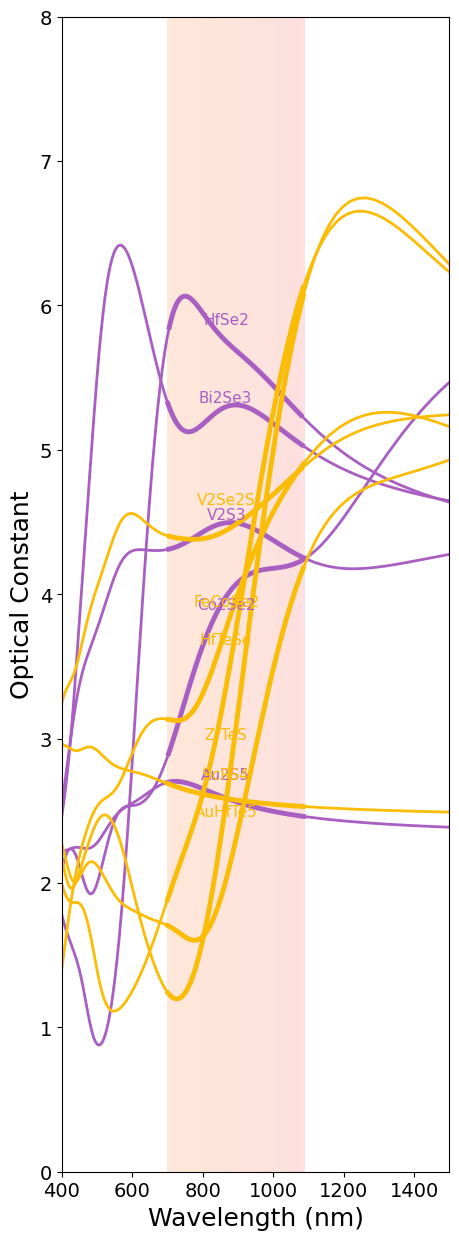

In [94]:
main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/')

In [9]:
d = {
    'dir_name': [
        'c2db_A2B3_2V2S3_1',   # -> V2S3
        'c2db_A2B3_1Bi2Se3_1', # -> Bi2Se3
        'c2db_AB_2CoSe_3',     # -> Co2Se2
        'c2db_AB2_1HfSe2_1',   # -> HfSe2
        'c2db_A2B5_1Au2S5_1',  # -> Au2S5
        'agm2000060793',       # -> V2Se2S
        'agm2000110562',       # -> Bi2Te2Se
        'agm2000064981',       # -> FeCoSe2
        'agm2000137470',       # -> HfTeSe
        'agm2000142235',       # -> AuHfTe5
        'agm2000110430'        # -> ScPS4 (leftover)
    ],
    'formula': [
        'V2S3', 'Bi2Se3','Co2Se2', 'HfSe2', 'Au2S5',
        'V2Se2S', 'Bi2Te2Se', 'FeCoSe2', 'HfTeSe', 'AuHfTe5', 'ScPS4'
    ],
    'thickness_2D': [
        12.6, 10.2, 6.34, 6.35, 6.32,
        10.122, 11.4, 6.574, 7.83, 8.116, 8.499
    ],
    'lattice_c': [
        24.3, 36.98, 17.45, 18.143, 31.73,
        21.322, 22.2, 17.774, 18.63, 18.916, 18.8991
    ]
}

df_new = pd.DataFrame(data=d)


In [10]:
pair_map = {
    'c2db_A2B3_2V2S3_1'  : 'agm2000060793',  # V2S3  -> V2Se2S
    'c2db_A2B3_1Bi2Se3_1': 'agm2000110562',  # Bi2Se3 -> Bi2Te2Se
    'c2db_AB_2CoSe_3'    : 'agm2000064981',  # Co2Se2 -> FeCoSe2
    'c2db_AB2_1HfSe2_1'  : 'agm2000137470',  # HfSe2 -> HfTeSe
    'c2db_A2B5_1Au2S5_1' : 'agm2000142235'   # Au2S5 -> AuHfTe5
}
# Leftover
leftover_name = 'agm2000110430'  # ScPS4


In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

# Example stubs for reading optics data
def read_optics_data(system, thickness_2d, thickness_3d, base_path):
    """
    Stub function that demonstrates how to load
    your optics data for 'system' and convert them
    to n_x, k_x, etc. Replace with your real code.
    """
    analyzer = OpticsAnalyzer(system=system)
    vasprun_dft = os.path.join(base_path, f"{system}/vasprun.xml")
    analyzer.read(vasprun_dft, thickness_2d=thickness_2d, thickness_3d=thickness_3d)

    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    dft_wavelengths = dft_data.real["Wavelength, nm"].values
    dft_n_xx = dft_data.real["xx"].values
    dft_k_xx = dft_data.imag["xx"].values
    return dft_wavelengths, dft_n_xx, dft_k_xx

def _gradient_fill(ax, x_start, x_end, y_low, y_high,
                   color_start='#FFB380', color_end='#FA9895', alpha=0.3):
    """
    Draw a horizontal gradient from color_start to color_end
    spanning x = x_start to x_end, and y = y_low to y_high.
    """
    N = 256
    gradient_array = np.linspace(0, 1, N)
    gradient_array = np.vstack((gradient_array, gradient_array))

    cmap = LinearSegmentedColormap.from_list(
        'my_cmap',
        [to_rgba(color_start), to_rgba(color_end)]
    )
    ax.imshow(
        gradient_array,
        extent=(x_start, x_end, y_low, y_high),
        origin='lower',
        aspect='auto',
        cmap=cmap,
        alpha=alpha,
        zorder=0
    )

def _plot_with_bold_region(ax, x, y, color, label=None,
                           region=(700, 1090),
                           lw_normal=2.0, lw_bold=3.5, linestyle='-'):
    """
    Plot a line over the full wavelength range at lw_normal,
    then re-plot the line over the specified region with lw_bold
    to emphasize that portion.
    """
    ax.plot(x, y, color=color, linestyle=linestyle, linewidth=lw_normal)
    mask = (x >= region[0]) & (x <= region[1])
    if np.any(mask):
        ax.plot(x[mask], y[mask], color=color, linestyle=linestyle,
                linewidth=lw_bold, label=label)

def plot_one_structure(ax, row, base_path, color, label_prefix='',
                       gradient_region=(700, 1090)):
    """
    Helper function: plot n_x and k_x for one structure row.
    """
    x, n_x, k_x = read_optics_data(
        system=row['dir_name'],
        thickness_2d=row['lattice_c'],
        thickness_3d=row['thickness_2D'],
        base_path=base_path
    )

    _plot_with_bold_region(
        ax, x, n_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (n)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='-'
    )
    # Plot k_x with dashed line if desired
    _plot_with_bold_region(
        ax, x, k_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (k)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='--'
    )

def make_pair_plot(ax, row_c2db, row_alex, base_path,
                   c2db_color='#FBBC05', alex_color='#A95EC2',
                   gradient_region=(700, 1090)):
    """
    Plot both the C2DB (row_c2db) and Alexandria (row_alex) structures
    on the same Axes, including the gradient highlight.
    """
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 8.0)

    # Apply gradient fill
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )

    plot_one_structure(
        ax, row_c2db, base_path,
        color=c2db_color, label_prefix=''
    )
    plot_one_structure(
        ax, row_alex, base_path,
        color=alex_color, label_prefix=''
    )

    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    #ax.legend(fontsize=9)
    ax.set_title(f"{row_c2db['formula']} vs {row_alex['formula']}", fontsize=13)

def make_single_plot(ax, row_single, base_path,
                     color='#FBBC05', gradient_region=(700, 1090)):
    """
    For the leftover unpaired structure, just plot a single line.
    """
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 4.0)
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )
    plot_one_structure(
        ax, row_single, base_path,
        color=color, label_prefix=''
    )
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    #ax.legend(fontsize=9)
    ax.set_title(f"Unpaired: {row_single['formula']}", fontsize=13)


def main_visualization(df, base_path="..."):
    """
    1) Define pairs (C2DB -> Alexandria).
    2) Create subplots for each pair.
    3) Plot leftover row if it exists.
    """

    # >>> UPDATED PAIR MAP <<<
    pair_map = {
        'c2db_A2B3_2V2S3_1'  : 'agm2000060793',   # V2S3    -> V2Se2S
        'c2db_A2B3_1Bi2Se3_1': 'agm2000110562',   # Bi2Se3  -> Bi2Te2Se
        'c2db_AB_2CoSe_3'    : 'agm2000064981',   # Co2Se2  -> FeCoSe2
        'c2db_AB2_1HfSe2_1'  : 'agm2000137470',   # HfSe2   -> HfTeSe
        'c2db_A2B5_1Au2S5_1' : 'agm2000142235'    # Au2S5   -> AuHfTe5
    }
    leftover_name = 'agm2000110430'  # ScPS4

    # Decide how many subplots you need
    n_pairs = len(pair_map)  # 5
    n_subplots = n_pairs + 1 # 6 => 5 pairs + 1 leftover

    # For example: a 3×2 grid to hold 6 subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 9))
    axes = axes.ravel()  # Flatten into 1D array

    # Plot each pair in its own subplot
    for i, (c2db_dir, alex_dir) in enumerate(pair_map.items()):
        # Grab the rows from df
        row_c2db = df[df['dir_name'] == c2db_dir]
        row_alex = df[df['dir_name'] == alex_dir]

        # Safety check: skip if the row doesn't exist
        if len(row_c2db) == 0 or len(row_alex) == 0:
            print(f"Warning: one of these is missing: {c2db_dir}, {alex_dir}")
            continue

        row_c2db = row_c2db.iloc[0]  # safe, we just checked length
        row_alex = row_alex.iloc[0]

        ax = axes[i]
        make_pair_plot(ax, row_c2db, row_alex, base_path)

    # Plot the leftover single structure on the next subplot
    leftover_row = df[df['dir_name'] == leftover_name]
    if len(leftover_row) > 0:
        leftover_row = leftover_row.iloc[0]
        ax = axes[n_pairs]  # next available subplot index
        make_single_plot(ax, leftover_row, base_path)
    else:
        # If leftover name is not found, just turn that subplot off or skip
        axes[n_pairs].axis('off')

    # Any unused subplots => turn them off
    for j in range(n_pairs + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    save_name = "V2Se2S_dn_dk.png"
    save_path = os.path.join('/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vis/', 'spectrum', save_name)
    plt.savefig(save_path, dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()


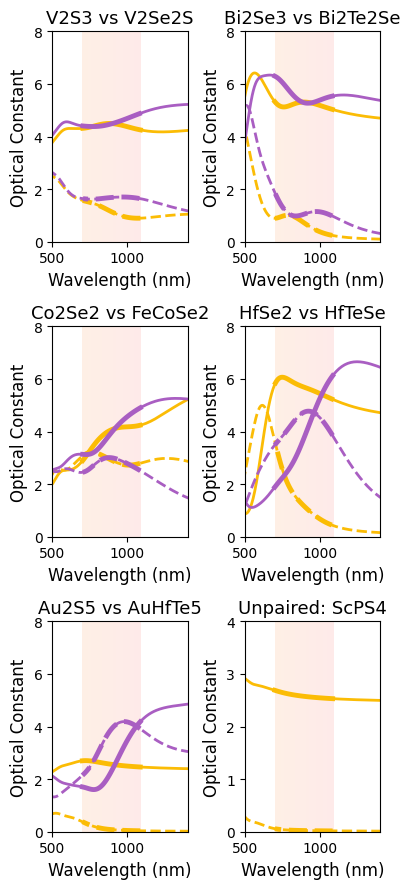

In [24]:
main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/')

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

# EXAMPLE: Fill in your actual code for reading data here
def read_optics_data(system, thickness_2d, thickness_3d, base_path):
    """
    Stub function that demonstrates how to load
    your optics data for 'system' and convert them
    to n_x, k_x, etc.
    """
    analyzer = OpticsAnalyzer(system=system)
    vasprun_dft = os.path.join(base_path, f"{system}/vasprun.xml")
    analyzer.read(vasprun_dft, thickness_2d=thickness_2d, thickness_3d=thickness_3d)

    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    dft_wavelengths = dft_data.real["Wavelength, nm"].values
    dft_n_xx = dft_data.real["xx"].values
    dft_k_xx = dft_data.imag["xx"].values
    return dft_wavelengths, dft_n_xx, dft_k_xx

def _gradient_fill(ax, x_start, x_end, y_low, y_high,
                   color_start='#FFB380', color_end='#FA9895', alpha=0.3):
    """
    Draw a horizontal gradient from color_start to color_end
    spanning x = x_start to x_end, and y = y_low to y_high.
    """
    N = 256
    gradient_array = np.linspace(0, 1, N)
    gradient_array = np.vstack((gradient_array, gradient_array))

    cmap = LinearSegmentedColormap.from_list(
        'my_cmap',
        [to_rgba(color_start), to_rgba(color_end)]
    )
    ax.imshow(
        gradient_array,
        extent=(x_start, x_end, y_low, y_high),
        origin='lower',
        aspect='auto',
        cmap=cmap,
        alpha=alpha,
        zorder=0
    )

def _plot_with_bold_region(ax, x, y, color, label=None,
                           region=(700, 1090),
                           lw_normal=2.0, lw_bold=3.5, linestyle='-'):
    """
    Plot a line over the full wavelength range at lw_normal,
    then re-plot the line over the specified region with lw_bold
    to emphasize that portion.
    """
    # Plot the entire line
    ax.plot(x, y, color=color, linestyle=linestyle,
            linewidth=lw_normal)

    # Highlight region 700–1090 nm in bold
    mask = (x >= region[0]) & (x <= region[1])
    if any(mask):
        ax.plot(x[mask], y[mask], color=color, linestyle=linestyle,
                linewidth=lw_bold, label=label)

def plot_one_structure(ax, row, base_path, color, label_prefix='',
                       gradient_region=(700, 1090)):
    """
    Helper function: plot n_x and k_x for one structure row.
    """
    # Read data
    x, n_x, k_x = read_optics_data(
        system=row['dir_name'],
        thickness_2d=row['lattice_c'],
        thickness_3d=row['thickness_2D'],
        base_path=base_path
    )

    # Plot n_x
    _plot_with_bold_region(
        ax, x, n_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (n)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='-'
    )

    # Plot k_x (optional, dashed line)
    _plot_with_bold_region(
        ax, x, k_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (k)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='--'
    )

def make_pair_plot(ax, row_c2db, row_alex, base_path,
                   c2db_color='#FBBC05', alex_color='#A95EC2',
                   gradient_region=(700, 1090)):
    """
    Plot both the C2DB (row_c2db) and Alexandria (row_alex) structures
    on the same Axes, including the gradient highlight.
    """
    # Set up a consistent y-range if you wish; or let it auto-scale
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 8.0)

    # Apply gradient fill
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )

    # Plot the two lines
    plot_one_structure(
        ax, row_c2db, base_path,
        color=c2db_color, label_prefix=''
    )
    plot_one_structure(
        ax, row_alex, base_path,
        color=alex_color, label_prefix=''
    )

    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    #ax.legend(fontsize=10)
    ax.set_title(
        f"{row_c2db['formula']} vs {row_alex['formula']}",
        fontsize=13
    )

def make_single_plot(ax, row_single, base_path,
                     color='#FBBC05', gradient_region=(700, 1090)):
    """
    For the leftover unpaired structure, just plot a single line.
    """
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 4.0)
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )
    plot_one_structure(
        ax, row_single, base_path,
        color=color, label_prefix=''
    )
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    #ax.legend(fontsize=10)
    ax.set_title(f"Unpaired: {row_single['formula']}", fontsize=13)


def main_visualization(df, base_path):
    """
    1) Define pairs (C2DB -> Alexandria).
    2) Create subplots for each pair.
    3) If there's a leftover row from Alexandria with no pair,
       plot it alone.
    """

    # Map the c2db structure name to the matching Alexandria name
    pair_map = {
        'c2db_A2B3_2V2S3_1' : 'agm2000060793',
        'c2db_A2B3_1Bi2Se3_1' : 'agm2000110778',
        'c2db_AB_2CoSe_3'    : 'agm2000064981',
        'c2db_AB2_1HfSe2_1'  : 'agm2000142235',
        'c2db_A2B5_1Au2S5_1' : 'agm2000137470'
    }
    # The leftover (no pair in C2DB)
    leftover_name = 'agm2000110430'

    # Prepare subplots: 3 rows × 2 cols = 6 total
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 9))
    axes = axes.ravel()  # Flatten into 1D array

    # -- Plot each pair in its own subplot
    for i, (c2db_dir, alex_dir) in enumerate(pair_map.items()):
        # Grab the rows from df
        row_c2db = df[df['dir_name'] == c2db_dir].iloc[0]
        row_alex = df[df['dir_name'] == alex_dir].iloc[0]

        ax = axes[i]
        make_pair_plot(ax, row_c2db, row_alex, base_path)

    # -- Now plot leftover single structure in the last subplot
    leftover_row = df[df['dir_name'] == leftover_name].iloc[0]
    ax = axes[len(pair_map)]  # next available subplot index
    make_single_plot(ax, leftover_row, base_path)

    # If you have any empty subplot cells (e.g., if you used more
    # subplots than pairs), you can hide them
    for j in range(len(pair_map) + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    save_name = "V2Se2S_dn_dk.png"
    save_path = os.path.join('/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vis/', 'spectrum', save_name)
    plt.savefig(save_path, dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

# Then you simply call:
# main_visualization(df, base_path='/path/to/your/data')


IndexError: single positional indexer is out-of-bounds

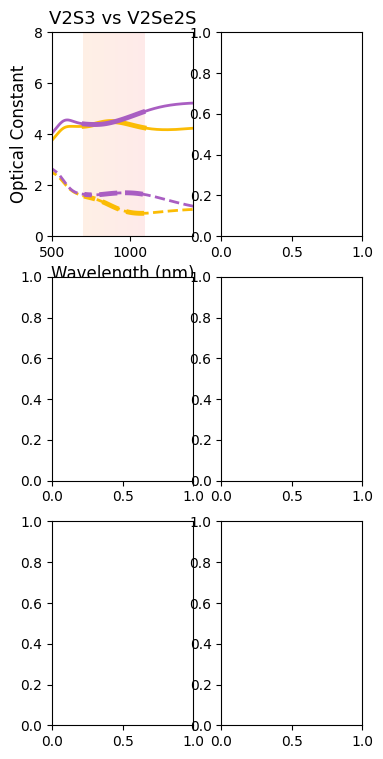

In [11]:
main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/')

In [101]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, LinearSegmentedColormap

# EXAMPLE: Fill in your actual code for reading data here
def read_optics_data(system, thickness_2d, thickness_3d, base_path):
    """
    Stub function that demonstrates how to load
    your optics data for 'system' and convert them
    to n_x, k_x, etc.
    """
    analyzer = OpticsAnalyzer(system=system)
    vasprun_dft = os.path.join(base_path, f"{system}/vasprun.xml")
    analyzer.read(vasprun_dft, thickness_2d=thickness_2d, thickness_3d=thickness_3d)

    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    dft_wavelengths = dft_data.real["Wavelength, nm"].values
    dft_n_xx = dft_data.real["xx"].values
    dft_k_xx = dft_data.imag["xx"].values
    return dft_wavelengths, dft_n_xx, dft_k_xx

def _gradient_fill(ax, x_start, x_end, y_low, y_high,
                   color_start='#FFB380', color_end='#FA9895', alpha=0.3):
    """
    Draw a horizontal gradient from color_start to color_end
    spanning x = x_start to x_end, and y = y_low to y_high.
    """
    N = 256
    gradient_array = np.linspace(0, 1, N)
    gradient_array = np.vstack((gradient_array, gradient_array))

    cmap = LinearSegmentedColormap.from_list(
        'my_cmap',
        [to_rgba(color_start), to_rgba(color_end)]
    )
    ax.imshow(
        gradient_array,
        extent=(x_start, x_end, y_low, y_high),
        origin='lower',
        aspect='auto',
        cmap=cmap,
        alpha=alpha,
        zorder=0
    )

def _plot_with_bold_region(ax, x, y, color, label=None,
                           region=(700, 1090),
                           lw_normal=2.0, lw_bold=3.5, linestyle='-'):
    """
    Plot a line over the full wavelength range at lw_normal,
    then re-plot the line over the specified region with lw_bold
    to emphasize that portion.
    """
    # Plot the entire line
    ax.plot(x, y, color=color, linestyle=linestyle,
            linewidth=lw_normal)

    # Highlight region 700–1090 nm in bold
    mask = (x >= region[0]) & (x <= region[1])
    if any(mask):
        ax.plot(x[mask], y[mask], color=color, linestyle=linestyle,
                linewidth=lw_bold, label=label)

def plot_one_structure(ax, row, base_path, color, label_prefix='',
                       gradient_region=(700, 1090)):
    """
    Helper function: plot n_x and k_x for one structure row.
    """
    # Read data
    x, n_x, k_x = read_optics_data(
        system=row['dir_name'],
        thickness_2d=row['lattice_c'],
        thickness_3d=row['thickness_2D'],
        base_path=base_path
    )

    # Plot n_x
    _plot_with_bold_region(
        ax, x, n_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (n)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='-'
    )

    # Plot k_x (optional, dashed line)
    _plot_with_bold_region(
        ax, x, k_x,
        color=color,
        label=f"{label_prefix}{row['formula']} (k)",
        region=gradient_region,
        lw_normal=2.0,
        lw_bold=3.5,
        linestyle='--'
    )

def make_pair_plot(ax, row_c2db, row_alex, base_path,
                   c2db_color='#FBBC05', alex_color='#A95EC2',
                   gradient_region=(700, 1090)):
    """
    Plot both the C2DB (row_c2db) and Alexandria (row_alex) structures
    on the same Axes, including the gradient highlight.
    """
    # Set up a consistent y-range if you wish; or let it auto-scale
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 8.0)

    # Apply gradient fill
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )

    # Plot the two lines
    plot_one_structure(
        ax, row_c2db, base_path,
        color=c2db_color, label_prefix=''
    )
    plot_one_structure(
        ax, row_alex, base_path,
        color=alex_color, label_prefix=''
    )

    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    ax.legend(fontsize=10)
    ax.set_title(
        f"{row_c2db['formula']} vs {row_alex['formula']}",
        fontsize=13
    )

def make_single_plot(ax, row_single, base_path,
                     color='#FBBC05', gradient_region=(700, 1090)):
    """
    For the leftover unpaired structure, just plot a single line.
    """
    ax.set_xlim(500, 1400)
    ax.set_ylim(0, 4.0)
    _gradient_fill(
        ax,
        x_start=gradient_region[0],
        x_end=gradient_region[1],
        y_low=ax.get_ylim()[0],
        y_high=ax.get_ylim()[1],
        color_start='#FFB380',
        color_end='#FA9895',
        alpha=0.2
    )
    plot_one_structure(
        ax, row_single, base_path,
        color=color, label_prefix=''
    )
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Optical Constant', fontsize=12)
    ax.legend(fontsize=10)
    ax.set_title(f"Unpaired: {row_single['formula']}", fontsize=13)


def main_visualization(df, base_path="..."):
    """
    1) Define pairs (C2DB -> Alexandria).
    2) Create subplots for each pair.
    3) If there's a leftover row from Alexandria with no pair,
       plot it alone.
    """

    # Map the c2db structure name to the matching Alexandria name
    pair_map = {
        'c2db_A2B3_2V2S3_1' : 'agm2000060793',
        'c2db_A2B3_1Bi2Se3_1' : 'agm2000110778',
        'c2db_AB_2CoSe_3'    : 'agm2000064981',
        'c2db_AB2_1HfSe2_1'  : 'agm2000142235',
        'c2db_A2B5_1Au2S5_1' : 'agm2000137470'
    }
    # The leftover (no pair in C2DB)
    leftover_name = 'agm2000110430'

    # Prepare subplots: 3 rows × 2 cols = 6 total
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(4, 9))
    axes = axes.ravel()  # Flatten into 1D array

    # -- Plot each pair in its own subplot
    for i, (c2db_dir, alex_dir) in enumerate(pair_map.items()):
        # Grab the rows from df
        row_c2db = df[df['dir_name'] == c2db_dir].iloc[0]
        row_alex = df[df['dir_name'] == alex_dir].iloc[0]

        ax = axes[i]
        make_pair_plot(ax, row_c2db, row_alex, base_path)

    # -- Now plot leftover single structure in the last subplot
    leftover_row = df[df['dir_name'] == leftover_name].iloc[0]
    ax = axes[len(pair_map)]  # next available subplot index
    make_single_plot(ax, leftover_row, base_path)

    # If you have any empty subplot cells (e.g., if you used more
    # subplots than pairs), you can hide them
    for j in range(len(pair_map) + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Then you simply call:
# main_visualization(df, base_path='/path/to/your/data')


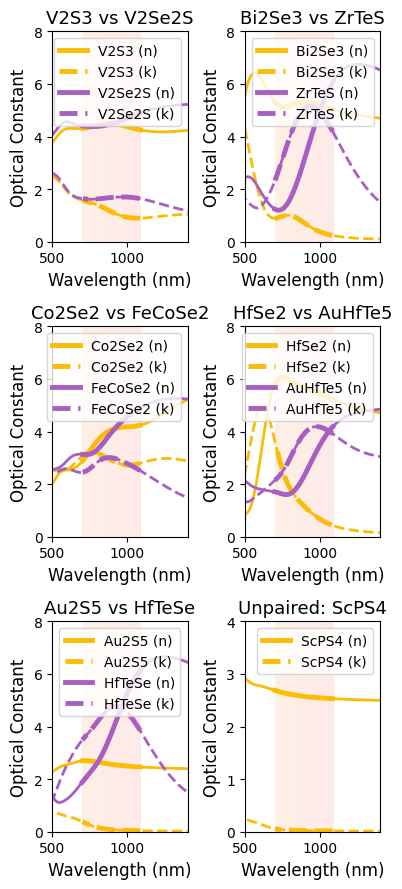

In [102]:
main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
from typing import List
import os
from dataclasses import dataclass
from typing import List, Tuple
import xml.etree.ElementTree as ET
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import gaussian_kde  # <-- IMPORTANT: for the KDE
import os

# We'll define a colormap for RMSE from 0.0 up to 0.5 as an example.
norm = colors.Normalize(vmin=0.0, vmax=0.75)
cmap = plt.cm.plasma

#def n_wavelength(wavelength, A, B):
#    """Cauchy-like formula for the refractive index."""
#    return A + B / wavelength**2 + 1.0 / wavelength**4

def main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/optics_vs2/'):
    # Prepare some arrays for analysis
    wavelength_range = np.linspace(700, 1100, 500)
    rmse_values = []  # to store RMSE for each material

    for j, dir_name in enumerate(df_new['dir_name']):
        SYSTEM = str(dir_name)
        print(SYSTEM)
        
        # ---------------------------------------------------
        # The following lines assume you have custom classes
        # and functions like OpticsAnalyzer, convert_epsilon_to_refractive_index,
        # evaluate_spectrum, etc. in your environment
        # ---------------------------------------------------
        analyzer = OpticsAnalyzer(system=SYSTEM)
        THICKNESS_2D = df_new['lattice_c'][j]
        THICKNESS_3D = df_new['thickness_2D'][j]
        FORMULA = df_new['formula'][j]
        #A_values = df_new['Ax_final'][j] 
        #B_values = df_new['Bx_final'][j] 

        # Predicted refractive index (model) over the range
        n_pred = n_wavelength(wavelength_range, A_values, B_values)
        
        # Read in the DFT data (assuming vasprun.xml is present)
        vasprun_dft = os.path.join(base_path, f'{SYSTEM}/vasprun.xml')
        try:
            analyzer.read(vasprun_dft, thickness_2d=THICKNESS_2D, thickness_3d=THICKNESS_3D)
            dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        except (FileNotFoundError, DataParsingError) as e:
            print(f"Skipping {SYSTEM} due to error: {e}")
            continue
        
        # Extract DFT-based refractive index for the "xx" component
        dft_wavelengths = dft_data.real['Wavelength, nm'].values
        dft_n_xx = dft_data.real['xx'].values
        dft_k_xx = dft_data.imag['xx'].values
        
        # Limit DFT data to the 700–1100 nm range
        mask = (dft_wavelengths >= 700) & (dft_wavelengths <= 1100)
        dft_wavelengths_cropped = dft_wavelengths[mask]
        dft_n_xx_cropped = dft_n_xx[mask]

        # Interpolate the DFT data to the model's wavelength grid
        #n_true_interpolated = np.interp(wavelength_range, dft_wavelengths_cropped, dft_n_xx_cropped)

        # Now compute error only in the near-IR range
        #results = evaluate_spectrum(n_true_interpolated, n_pred, wavelengths=wavelength_range)
        #rmse_value = results['RMSE']
        #rmse_values.append(rmse_value)
        
        # Decide the color of the model line based on the RMSE
        line_color = cmap(norm(rmse_value))
        
        # Plot
        plt.figure(figsize=(7, 7))
        # Shaded region
        plt.axvspan(700, 1090, facecolor='#FFC39E', alpha=0.3)
        
        # Plot DFT curve (xx component)
        plt.plot(dft_wavelengths, dft_n_xx, linewidth=3.0, color='#FFC39E', 
                 label='$n_{x}$ (DFT)')
        plt.plot(dft_wavelengths, dft_k_xx, '--', linewidth=3.0, color='#FFC39E', 
                 label='$k_{x}$ (DFT)')

        # Plot model predictions with color-coded line
        #plt.plot(wavelength_range, n_pred, alpha=1.0, linewidth=4.0, color=line_color,
        #         label=f'$n_{{model}}$ (RMSE={rmse_value:.3f})')
        
        plt.xlim(500, 3000)
        plt.ylim(0, 10)
        plt.xlabel('Wavelength (nm)', fontsize=20)
        plt.ylabel('Refractive Index', fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(f'${SYSTEM}, {FORMULA}$', fontsize=20)
        plt.legend(loc='best', edgecolor='white', fontsize=15)

        plt.show()

    # -------------------------------------------------


In [11]:
#####################################
# Error Evaluation Function
#####################################
def evaluate_spectrum(n_true, n_pred, wavelengths=None):
    """
    Computes common regression metrics (MAE, RMSE, R^2) 
    between true and predicted refractive index arrays.
    """
    mae = mean_absolute_error(n_true, n_pred)
    mse = np.mean((n_true - n_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(n_true, n_pred)
    
    results = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    # Optional: integrated absolute error if wavelengths are provided
    if wavelengths is not None and len(wavelengths) == len(n_true):
        sorted_indices = np.argsort(wavelengths)
        w_sorted = wavelengths[sorted_indices]
        n_true_sorted = n_true[sorted_indices]
        n_pred_sorted = n_pred[sorted_indices]
        absolute_diff = np.abs(n_true_sorted - n_pred_sorted)
        integrated_error = np.trapz(absolute_diff, x=w_sorted)
        results['Integrated Absolute Error'] = integrated_error
    
    return results

In [36]:
#####################################
# Visualization with Errors
#####################################
from matplotlib import colors 
from dataclasses import dataclass
from typing import List, Tuple
import xml.etree.ElementTree as ET
from sklearn.metrics import mean_absolute_error, r2_score
import os
# We'll define a colormap for RMSE from 0.0 up to 0.5 as an example.
norm = colors.Normalize(vmin=0.0, vmax=0.5)
cmap = plt.cm.plasma

def n_wavelength(wavelength, A, B):
    """Cauchy-like formula for the refractive index."""
    return A + B / wavelength**2 + 1.0 / wavelength**4

#####################################
# Example Main Loop
#####################################
def main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/alex_fin_full/'):
    # Prepare some arrays for analysis
    lst_dft = []
    # Example wavelength range where we want the ML predictions
    wavelength_range = np.linspace(700, 1100, 500)
    
    # Iterate over materials in df_new
    for j, dir_name in enumerate(df_new['mat_id']):
        SYSTEM = str(dir_name)
        print(SYSTEM)
        
        analyzer = OpticsAnalyzer(system=SYSTEM)
        THICKNESS_2D = df_new['lattice_c'][j]
        THICKNESS_3D = df_new['thickness_2D'][j]
        FORMULA = df_new['formula'][j]
        A_values = df_new['Ax_final'][j] 
        B_values = df_new['Bx_final'][j] 
        
        # Predicted refractive index (model) over the range
        n_pred = n_wavelength(wavelength_range, A_values, B_values)
        
        # Read in the DFT data (assuming vasprun.xml is present)
        vasprun_dft = os.path.join(base_path, f'{SYSTEM}/vasprun.xml')
        
        try:
            # Load and convert to n, k
            analyzer.read(vasprun_dft, thickness_2d=THICKNESS_2D, thickness_3d=THICKNESS_3D)
            dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        except (FileNotFoundError, DataParsingError) as e:
            print(f"Skipping {SYSTEM} due to error: {e}")
            continue
        
        # Extract DFT-based refractive index for the "xx" component
        # We'll interpolate it to the same wavelengths as the ML predictions
        dft_wavelengths = dft_data.real['Wavelength, nm'].values
        dft_n_xx = dft_data.real['xx'].values
        
        # Interpolate the DFT data to the model's wavelength grid
        n_true_interpolated = np.interp(wavelength_range, dft_wavelengths, dft_n_xx)
        
        mask = (dft_wavelengths >= 700) & (dft_wavelengths <= 1100)
        dft_wavelengths_cropped = dft_wavelengths[mask]
        dft_n_xx_cropped = dft_n_xx[mask]

# 2. Interpolate DFT onto the model grid 700–1100
        n_true_interpolated = np.interp(wavelength_range, 
                                dft_wavelengths_cropped, 
                                dft_n_xx_cropped)

# 3. Now compute error only in the near-IR range
        results = evaluate_spectrum(n_true_interpolated, n_pred, wavelengths=wavelength_range)
        print("RMSE (700–1100 nm only): ", results['RMSE'])
        rmse_value = results['RMSE']
        # Compute errors
        #results = evaluate_spectrum(n_true_interpolated, n_pred, wavelengths=wavelength_range)
        #rmse_value = results['RMSE']
        
        # Store one example DFT value for reference (optional)
        df_in_range = dft_data.real[dft_data.real['Wavelength, nm'].between(1050, 1075)]
        if not df_in_range.empty:
            lst_dft.append(df_in_range.iloc[0]['xx'])
        
        # Decide the color of the model line based on the RMSE
        line_color = cmap(norm(rmse_value))
        
        # Plot
        plt.figure(figsize=(10, 8))
        # Shaded region
        plt.axvspan(700, 1090, facecolor='#FFC39E', alpha=0.3)
        
        # Plot DFT curve
        plt.plot(dft_wavelengths, dft_n_xx, '--', linewidth=3.0, color='#FFC39E', 
                 label='$n_{x}$ (DFT)')

        # Plot model predictions with color-coded line
        plt.plot(wavelength_range, n_pred, alpha=0.8, linewidth=4.0, color=line_color,
                 label=f'$n_{{model}}$ (RMSE={rmse_value:.3f})')
        
        plt.xlim(500, 2000)
        plt.ylim(0, 10)
        plt.xlabel('Wavelength (nm)', fontsize=20)
        plt.ylabel('Refractive Index', fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(f'${SYSTEM}, {FORMULA}$', fontsize=20)
        plt.legend(loc='best', edgecolor='white', fontsize=15)
        
        # Save figure
        save_name = f"{SYSTEM}_dn_dk.png"
        save_path = os.path.join('/home/u7c/lusya/2D_materials/C2DB/alexandria/', "spectrum_png", save_name)
        plt.savefig(save_path, dpi=100, facecolor='w', bbox_inches='tight')
        plt.show()

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 
from typing import List
import os
from dataclasses import dataclass
from typing import List, Tuple
import xml.etree.ElementTree as ET
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import gaussian_kde  # <-- IMPORTANT: for the KDE
import os

# We'll define a colormap for RMSE from 0.0 up to 0.5 as an example.
norm = colors.Normalize(vmin=0.0, vmax=0.75)
cmap = plt.cm.plasma

def n_wavelength(wavelength, A, B):
    """Cauchy-like formula for the refractive index."""
    return A + B / wavelength**2 + 1.0 / wavelength**4

def main_visualization(df_new, base_path='/home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/'):
    # Prepare some arrays for analysis
    wavelength_range = np.linspace(700, 1100, 500)
    rmse_values = []  # to store RMSE for each material

    for j, dir_name in enumerate(df_new['mat_id']):
        SYSTEM = str(dir_name)
        print(SYSTEM)
        
        # ---------------------------------------------------
        # The following lines assume you have custom classes
        # and functions like OpticsAnalyzer, convert_epsilon_to_refractive_index,
        # evaluate_spectrum, etc. in your environment
        # ---------------------------------------------------
        analyzer = OpticsAnalyzer(system=SYSTEM)
        THICKNESS_2D = df_new['lattice_c'][j]
        THICKNESS_3D = df_new['thickness_2D'][j]
        FORMULA = df_new['formula'][j]
        A_values = df_new['Ax_final'][j] 
        B_values = df_new['Bx_final'][j] 

        # Predicted refractive index (model) over the range
        n_pred = n_wavelength(wavelength_range, A_values, B_values)
        
        # Read in the DFT data (assuming vasprun.xml is present)
        vasprun_dft = os.path.join(base_path, f'{SYSTEM}/vasprun.xml')
        try:
            analyzer.read(vasprun_dft, thickness_2d=THICKNESS_2D, thickness_3d=THICKNESS_3D)
            dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        except (FileNotFoundError, DataParsingError) as e:
            print(f"Skipping {SYSTEM} due to error: {e}")
            continue
        
        # Extract DFT-based refractive index for the "xx" component
        dft_wavelengths = dft_data.real['Wavelength, nm'].values
        dft_n_xx = dft_data.real['xx'].values
        dft_k_xx = dft_data.imag['xx'].values
        
        # Limit DFT data to the 700–1100 nm range
        mask = (dft_wavelengths >= 700) & (dft_wavelengths <= 1100)
        dft_wavelengths_cropped = dft_wavelengths[mask]
        dft_n_xx_cropped = dft_n_xx[mask]

        # Interpolate the DFT data to the model's wavelength grid
        n_true_interpolated = np.interp(wavelength_range, dft_wavelengths_cropped, dft_n_xx_cropped)

        # Now compute error only in the near-IR range
        results = evaluate_spectrum(n_true_interpolated, n_pred, wavelengths=wavelength_range)
        rmse_value = results['RMSE']
        rmse_values.append(rmse_value)
        
        # Decide the color of the model line based on the RMSE
        line_color = cmap(norm(rmse_value))
        
        # Plot
        plt.figure(figsize=(7, 7))
        # Shaded region
        plt.axvspan(700, 1090, facecolor='#FFC39E', alpha=0.3)
        
        # Plot DFT curve (xx component)
        plt.plot(dft_wavelengths, dft_n_xx, linewidth=3.0, color='#FFC39E', 
                 label='$n_{x}$ (DFT)')
        plt.plot(dft_wavelengths, dft_k_xx, '--', linewidth=3.0, color='#FFC39E', 
                 label='$k_{x}$ (DFT)')

        # Plot model predictions with color-coded line
        plt.plot(wavelength_range, n_pred, alpha=1.0, linewidth=4.0, color=line_color,
                 label=f'$n_{{model}}$ (RMSE={rmse_value:.3f})')
        
        plt.xlim(500, 2000)
        plt.ylim(0, 8)
        plt.xlabel('Wavelength (nm)', fontsize=20)
        plt.ylabel('Refractive Index', fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.title(f'${SYSTEM}, {FORMULA}$', fontsize=20)
        plt.legend(loc='best', edgecolor='white', fontsize=15)
        
        # Save figure
        save_name = f"{SYSTEM}_dn_dk.png"
        save_path = os.path.join('/home/u7c/lusya/2D_materials/C2DB/alexandria/', 
                                 "spectrum_recalc", save_name)
        plt.savefig(save_path, dpi=100, facecolor='w', bbox_inches='tight')
        #plt.show()

    # -------------------------------------------------
    # After plotting all materials, make a histogram of RMSE + KDE
    # -------------------------------------------------
    fig, ax = plt.subplots(figsize=(16, 4))
    
    # Build histogram from the collected RMSE values
    n_bins = 20
    counts, bin_edges = np.histogram(rmse_values, bins=n_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Plot each bin manually, colored by its RMSE center
    bar_widths = bin_edges[1:] - bin_edges[:-1]
    #for i, center in enumerate(bin_centers):
    #    color = cmap(norm(center))
    #    ax.bar(center, counts[i],
    #           width=bar_widths[i],
    #           color=color,
    #           align='center')
    
    # Compute KDE for the RMSE values
    kde = gaussian_kde(rmse_values)
    x_kde = np.linspace(min(rmse_values), max(rmse_values), 200)
    y_kde = kde(x_kde)

    # Scale KDE to match histogram height
    # (this ensures the area under KDE matches the histogram's total count)
    bin_width = (max(rmse_values) - min(rmse_values)) / n_bins
    y_kde_scaled = y_kde * len(rmse_values) * bin_width

    # --- Option A: Single-color KDE fill + line ---
    # Uncomment if you just want a simple overlay:
    #
    # ax.plot(x_kde, y_kde_scaled, color='black', linewidth=2, label='KDE')
    # ax.fill_between(x_kde, 0, y_kde_scaled, color='black', alpha=0.1)

    # --- Option B: Color-gradient KDE (segment-based) ---
    # This loops over small x intervals to give a gradient from the cmap
    for i in range(len(x_kde) - 1):
        x_seg = [x_kde[i], x_kde[i+1]]
        y_seg = [y_kde_scaled[i], y_kde_scaled[i+1]]
        
        # Fill under this small segment
        ax.fill_between(
            x_seg, 0, y_seg, 
            color=cmap(norm((x_kde[i] + x_kde[i+1]) / 2)), 
            alpha=0.6
        )
        # Optionally draw line segments with same gradient color
        #ax.plot(
        #    x_seg, y_seg,
        #    color=cmap(norm((x_kde[i] + x_kde[i+1]) / 2)),
        #    linewidth=2
        #)

    # Add a colorbar mapping RMSE to color
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # For older Matplotlib versions
    #cbar = plt.colorbar(sm, ax=ax)
    #cbar.set_label('RMSE', fontsize=12)

    # Labels and title
    ax.set_xlabel('RMSE', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Distribution of RMSE (700–1100 nm)', fontsize=14)
    plt.tight_layout()
    plt.xlim(0.1,2.1)
    plt.ylim(0,40)
    
    # Optionally save the histogram
    hist_save_path = os.path.join('/home/u7c/lusya/2D_materials/C2DB/alexandria/', 
                                  "spectrum_recalc", "RMSE_histogram.png")
    plt.savefig(hist_save_path, dpi=100, facecolor='w', bbox_inches='tight')
    #plt.show()


agm2000111658
Skipping agm2000111658 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000111658/vasprun.xml. Please check if file exists at specified path.
agm2000111649
Skipping agm2000111649 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000111649/vasprun.xml. Please check if file exists at specified path.
agm2000110749
Skipping agm2000110749 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000110749/vasprun.xml. Please check if file exists at specified path.
agm2000111659
Skipping agm2000111659 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000111659/vasprun.xml. Please check if file exists at specified path.
agm2000003615
Skipping agm2000003615 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000003615/vasprun.xml. Please check if file exists at specified path.
agm2000003

agm2000017485
Skipping agm2000017485 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000017485/vasprun.xml. Please check if file exists at specified path.
agm2000018697
Skipping agm2000018697 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000018697/vasprun.xml. Please check if file exists at specified path.
agm2000030309
Skipping agm2000030309 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000030309/vasprun.xml. Please check if file exists at specified path.
agm2000017221
Skipping agm2000017221 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000017221/vasprun.xml. Please check if file exists at specified path.
agm2000110026
Skipping agm2000110026 due to error: Cannot find /home/u7c/lusya/2D_materials/C2DB/alexandria/alex_recalc_fin/agm2000110026/vasprun.xml. Please check if file exists at specified path.
agm2000110

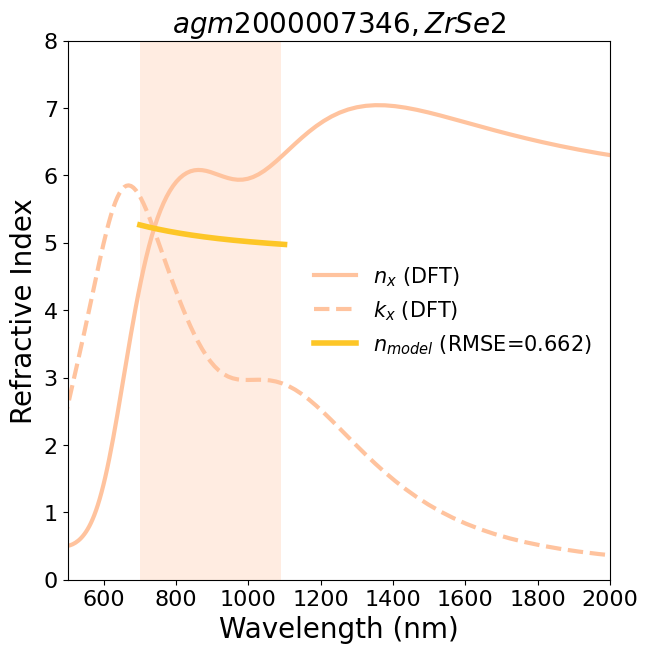

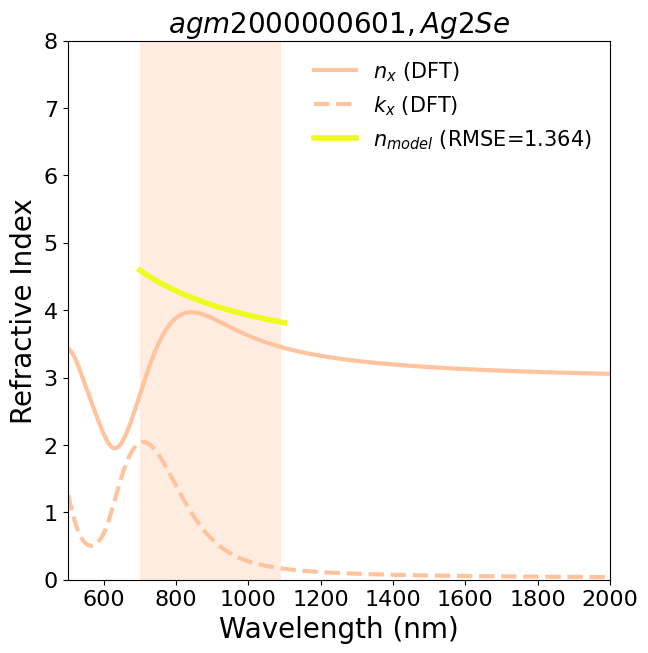

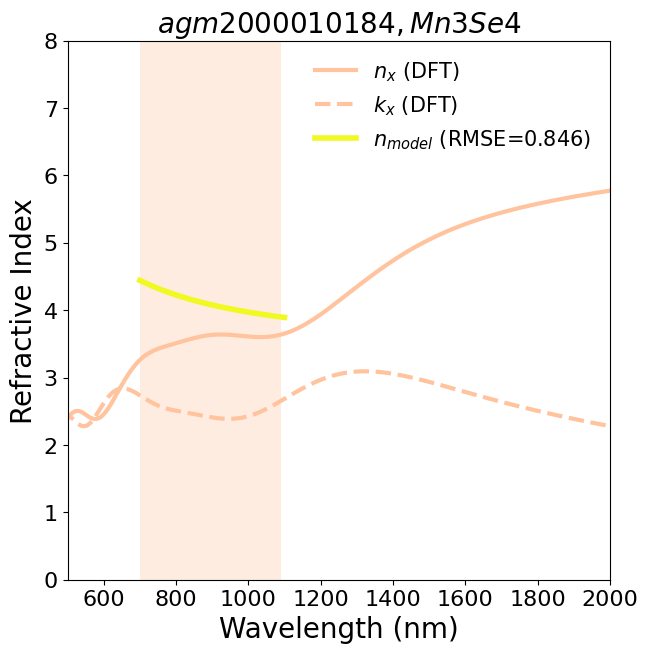

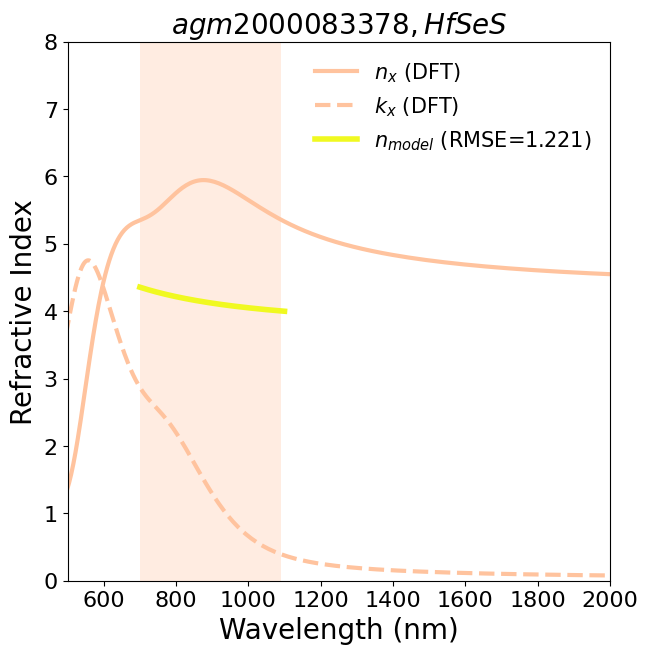

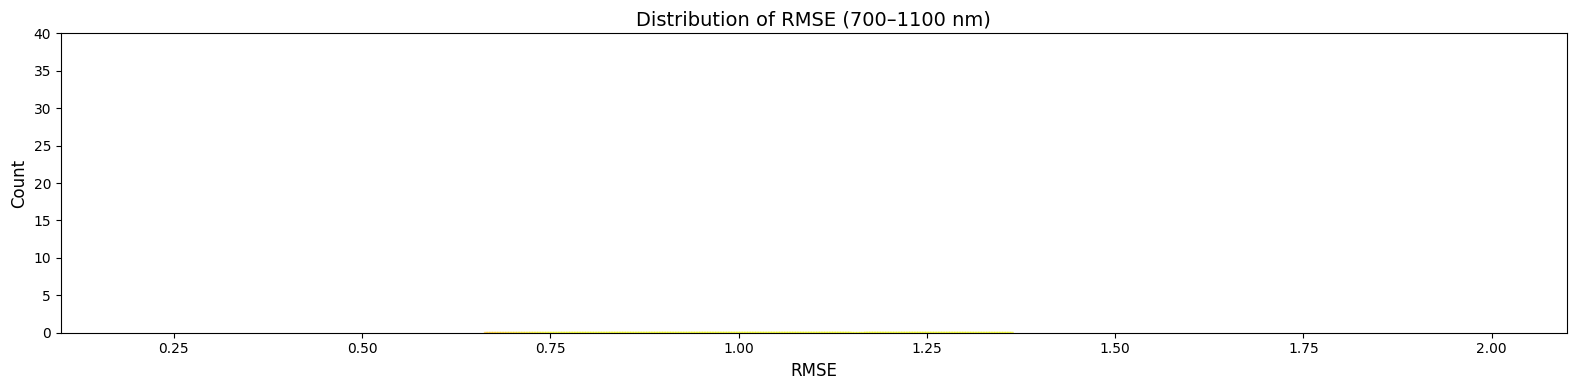

In [17]:
main_visualization(df_new)

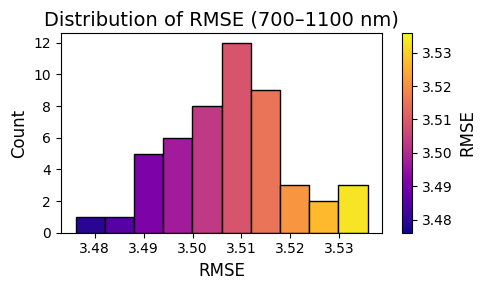

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Suppose you have:
#   1) multiple materials, each with a DFT curve n_true(λ)
#   2) a predicted ML curve n_pred(λ)
#   3) a shared wavelength array dft_wavelengths for each material
#   4) you only care about 700–1100 nm

def evaluate_spectrum(n_true, n_pred, wavelengths):
    """
    Example function to compute RMSE in a masked wavelength range.
    Returns just the RMSE for brevity, but you can expand as desired.
    """
    # Apply mask
    mask = (wavelengths >= 700) & (wavelengths <= 1100)
    lam_masked = wavelengths[mask]
    true_masked = n_true[mask]
    pred_masked = n_pred[mask]
    
    # Compute RMSE
    mse = np.mean((true_masked - pred_masked) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Example: We'll simulate RMSE values for N=50 materials
N = 50
rmse_values = []

# Let's assume you have arrays: dft_wavelengths, dft_n, ml_n for each material
# Here we'll just generate synthetic data
wavelengths_full = np.linspace(500, 1500, 1000)  # large range
for i in range(N):
    # Synthetic "true" data
    n_true_full = 5.0 - 1.0e-3 * (wavelengths_full - 800)**2 + 0.2 * np.random.randn(len(wavelengths_full))
    # Synthetic "pred" data
    n_pred_full = 5.0 - 1.1e-3 * (wavelengths_full - 800)**2 + 0.2 * np.random.randn(len(wavelengths_full))
    
    # Compute RMSE in 700–1100 nm only
    rmse = evaluate_spectrum(n_true_full, n_pred_full, wavelengths_full)
    rmse_values.append(rmse)

# --------------
# Now create a histogram of RMSE values, color-coded by bin
# --------------
fig, ax = plt.subplots(figsize=(5, 3))

counts, bin_edges = np.histogram(rmse_values, bins=10)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Use a plasma colormap and normalize over the min–max of the RMSE distribution
norm = Normalize(vmin=min(rmse_values), vmax=max(rmse_values))
cmap = cm.plasma

bar_widths = bin_edges[1:] - bin_edges[:-1]

for i in range(len(bin_centers)):
    # The bin's representative error is its center value
    rmse_center = bin_centers[i]
    color = cmap(norm(rmse_center))
    ax.bar(bin_centers[i], counts[i], 
           width=bar_widths[i], 
           color=color, 
           edgecolor='black',
           align='center')

# Add a colorbar that maps RMSE to color
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # For older Matplotlib versions
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('RMSE', fontsize=12)

ax.set_xlabel('RMSE', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of RMSE (700–1100 nm)', fontsize=14)

plt.tight_layout()
plt.show()


agm2000111658


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


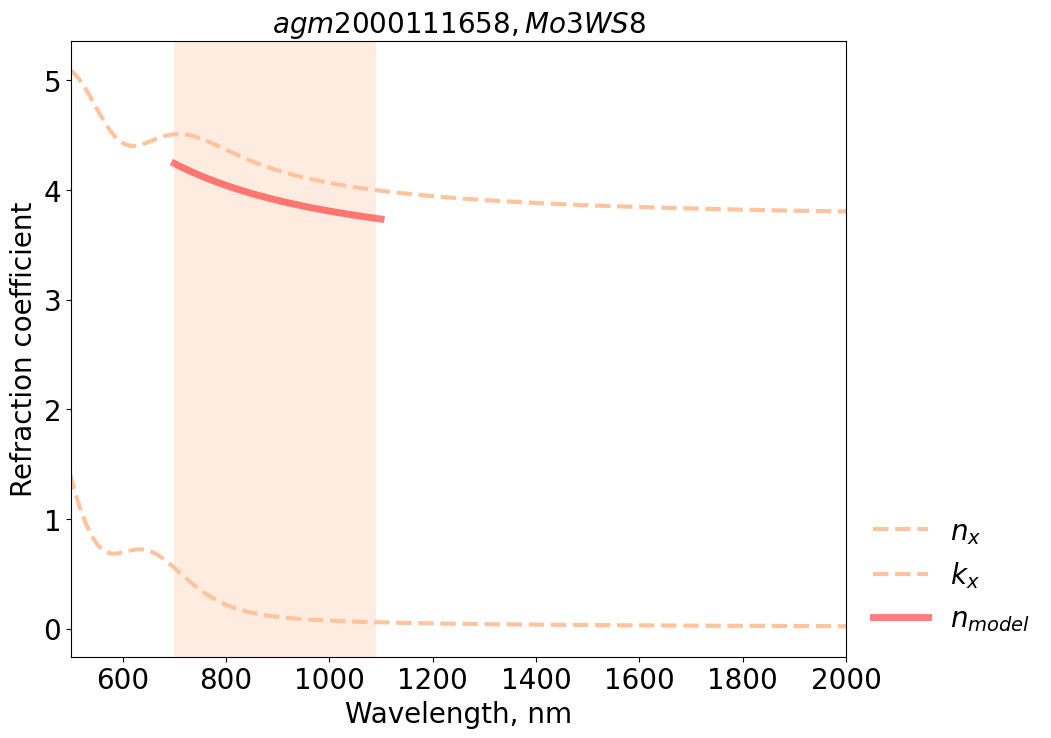

agm2000111649


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


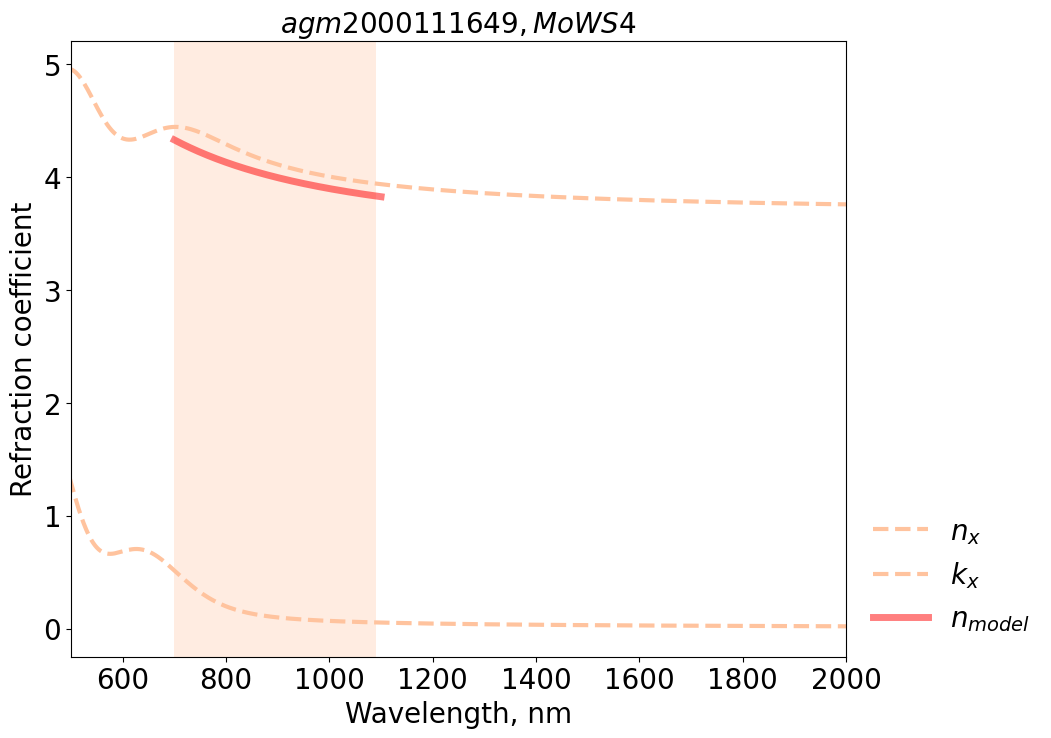

agm2000110749


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


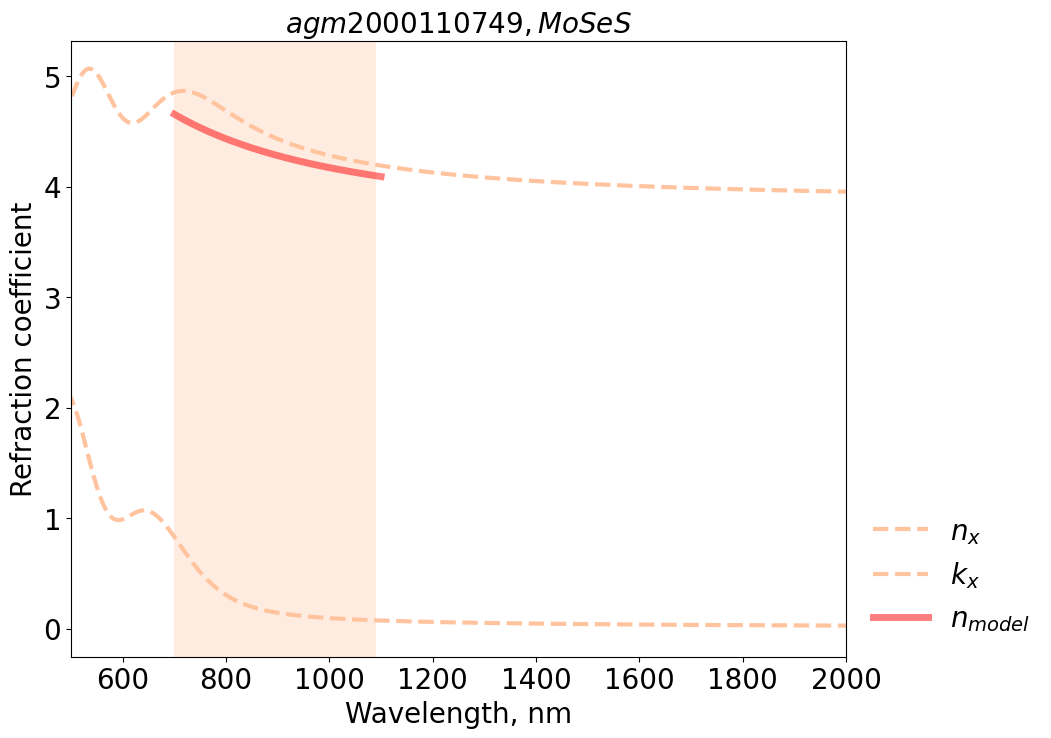

agm2000111659


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


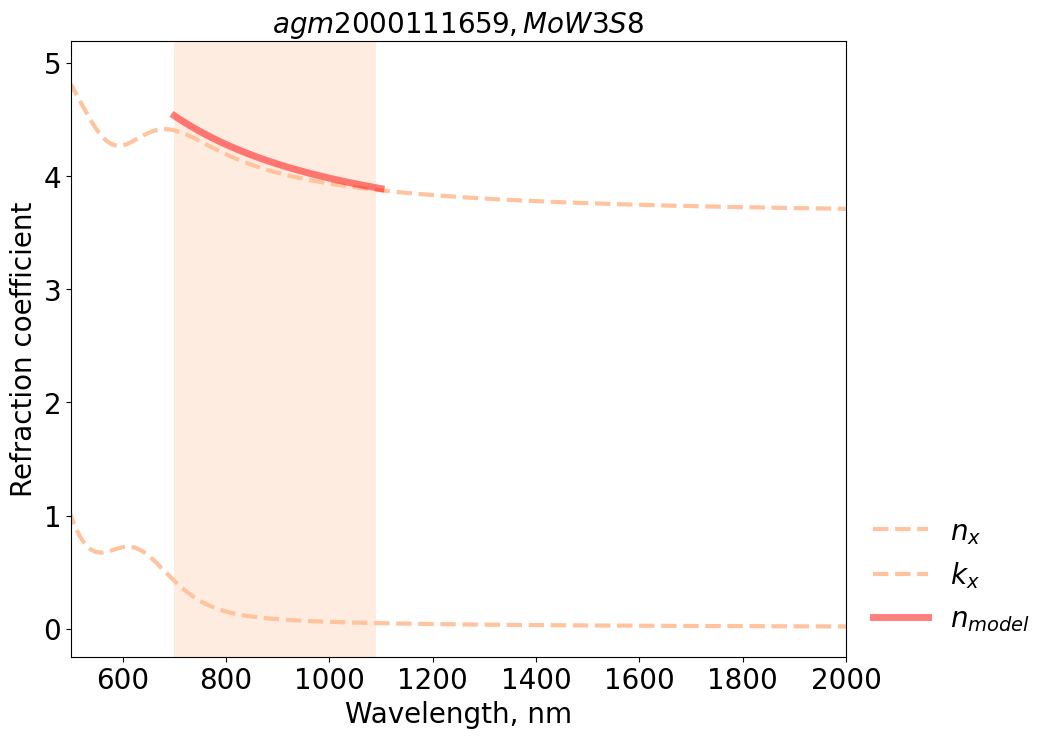

agm2000003615


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


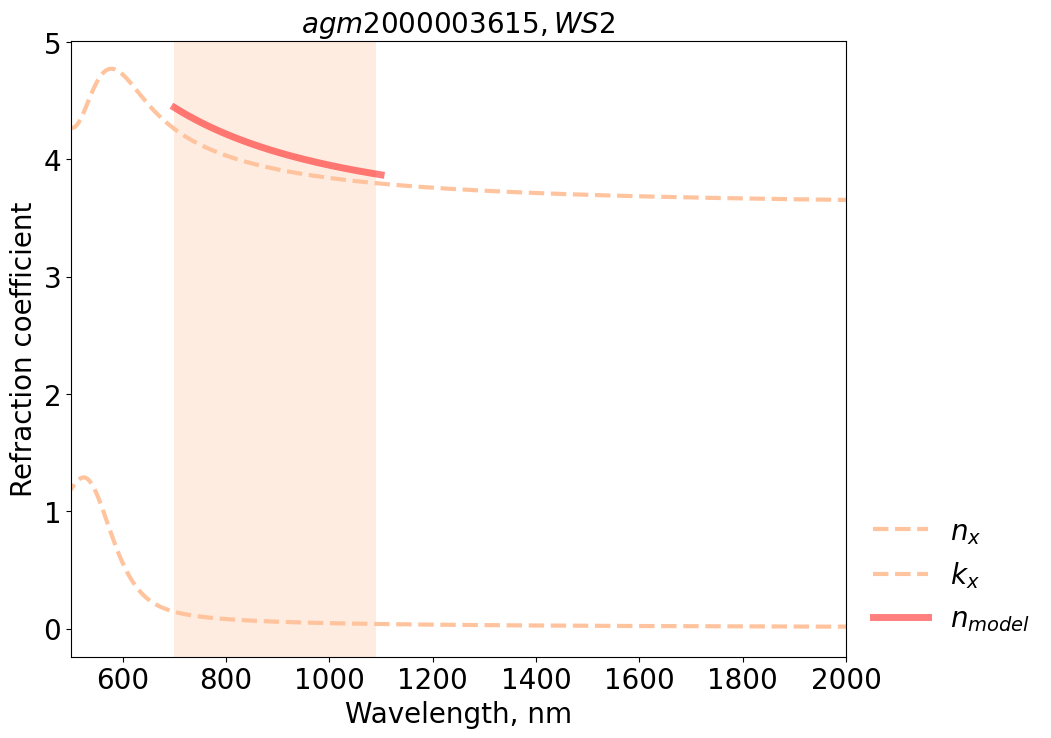

agm2000003540


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


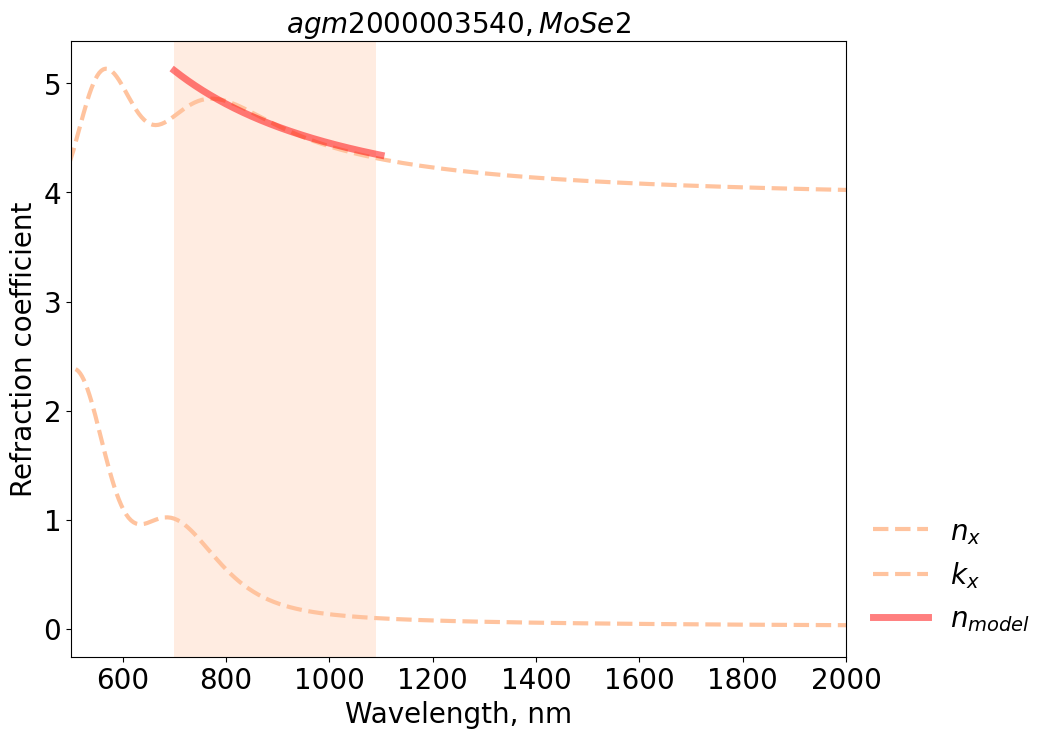

agm2000111612


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


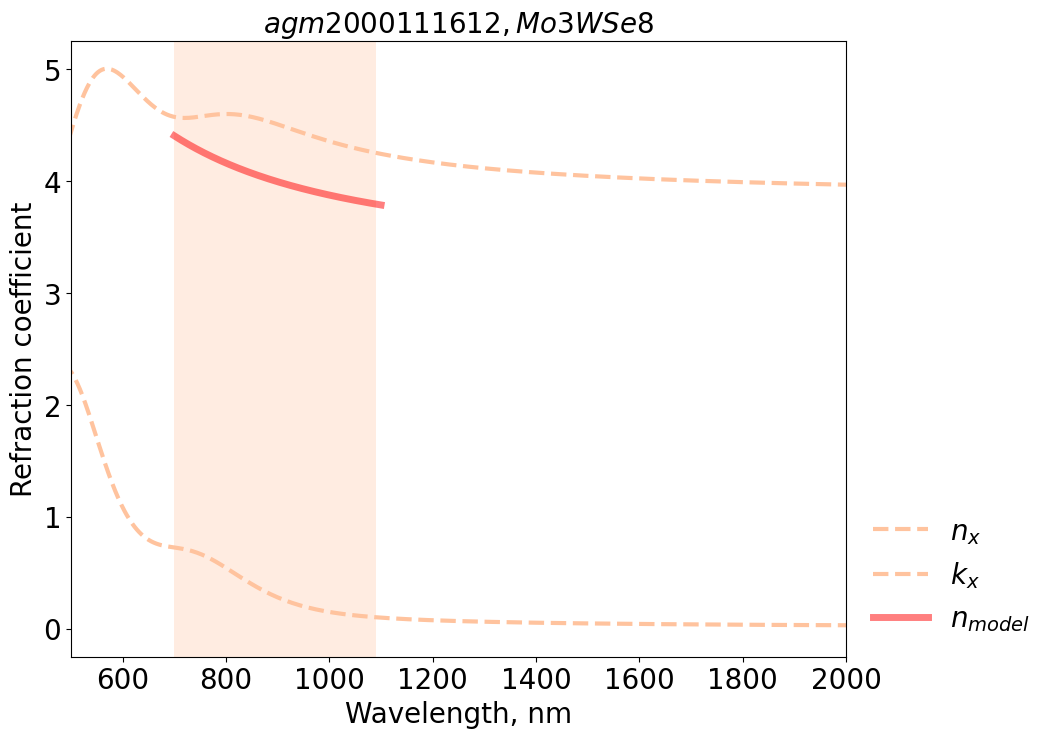

agm2000111608


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


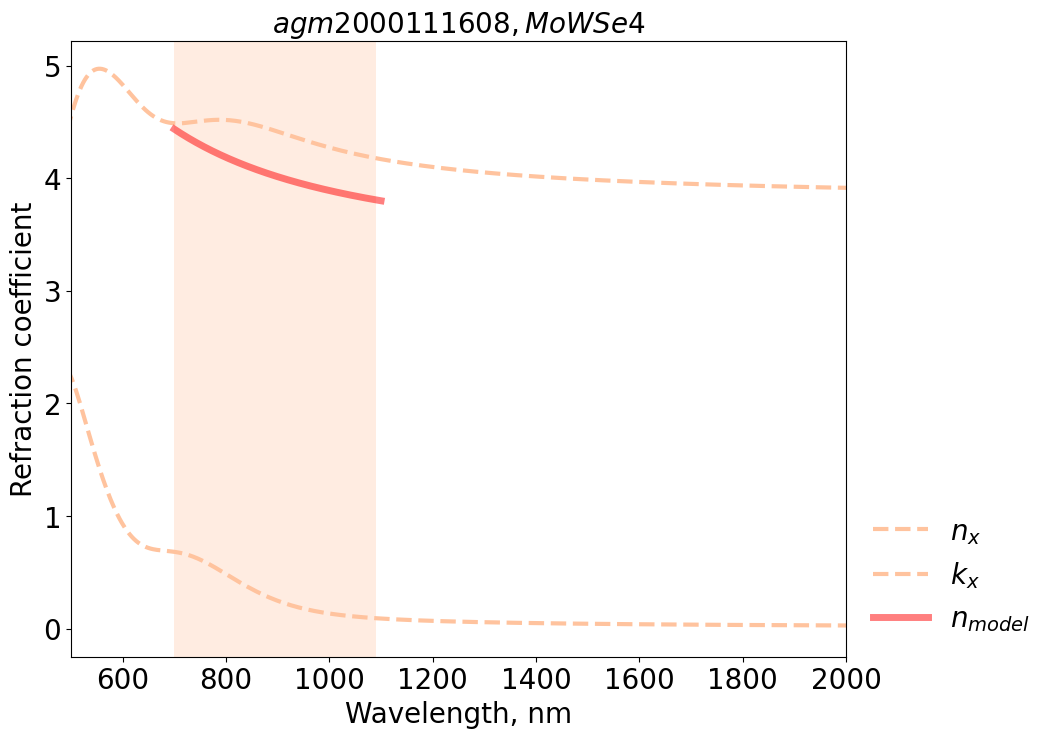

agm2000110769


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


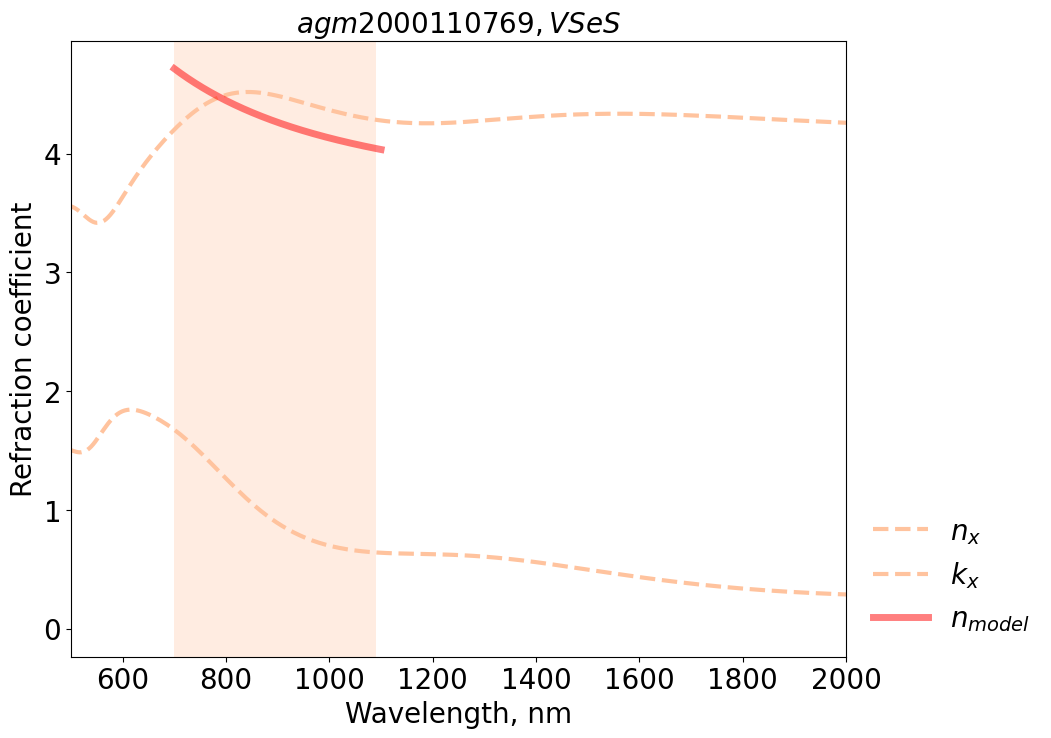

agm2000009025


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


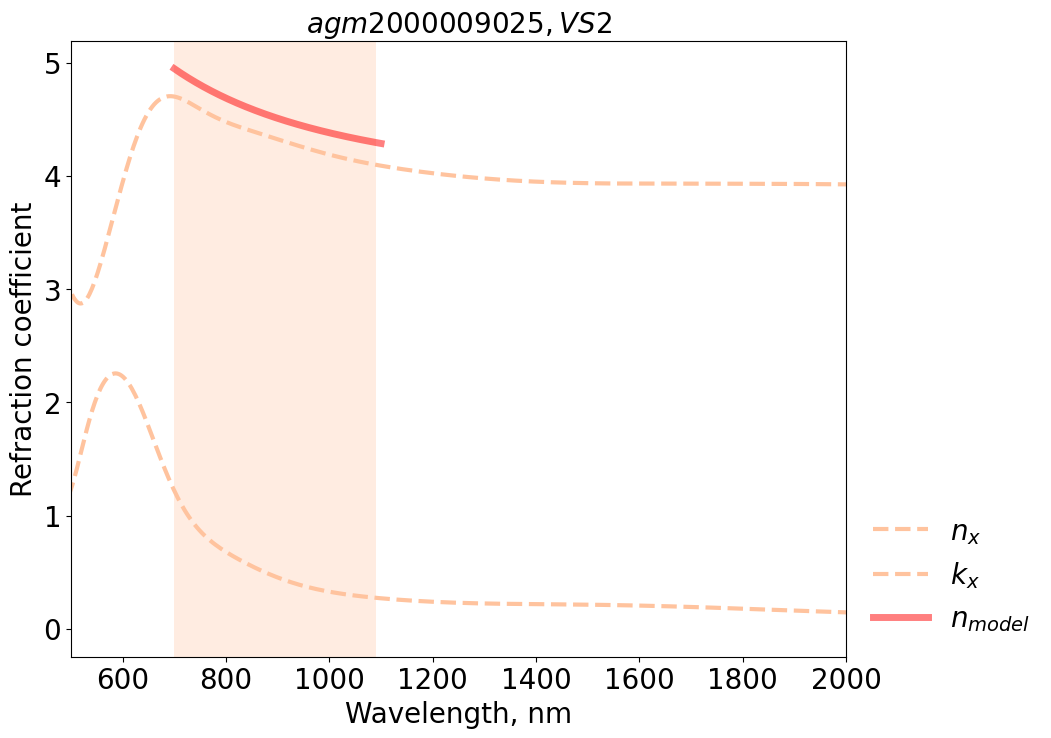

agm2000094075


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


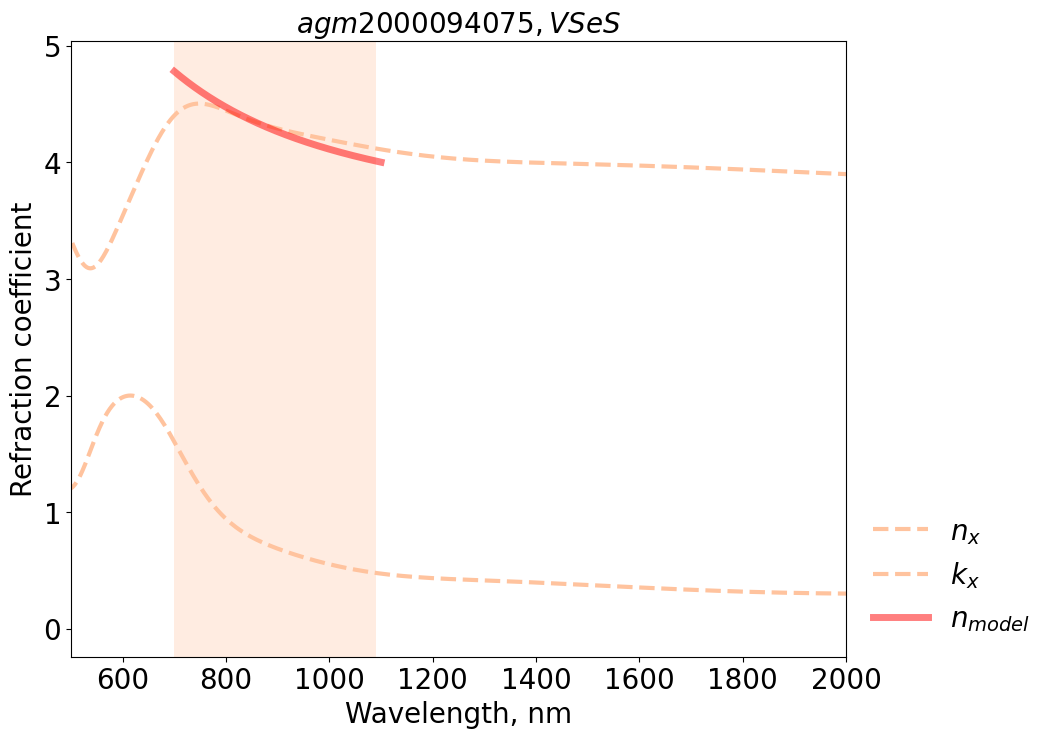

agm2000140584


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


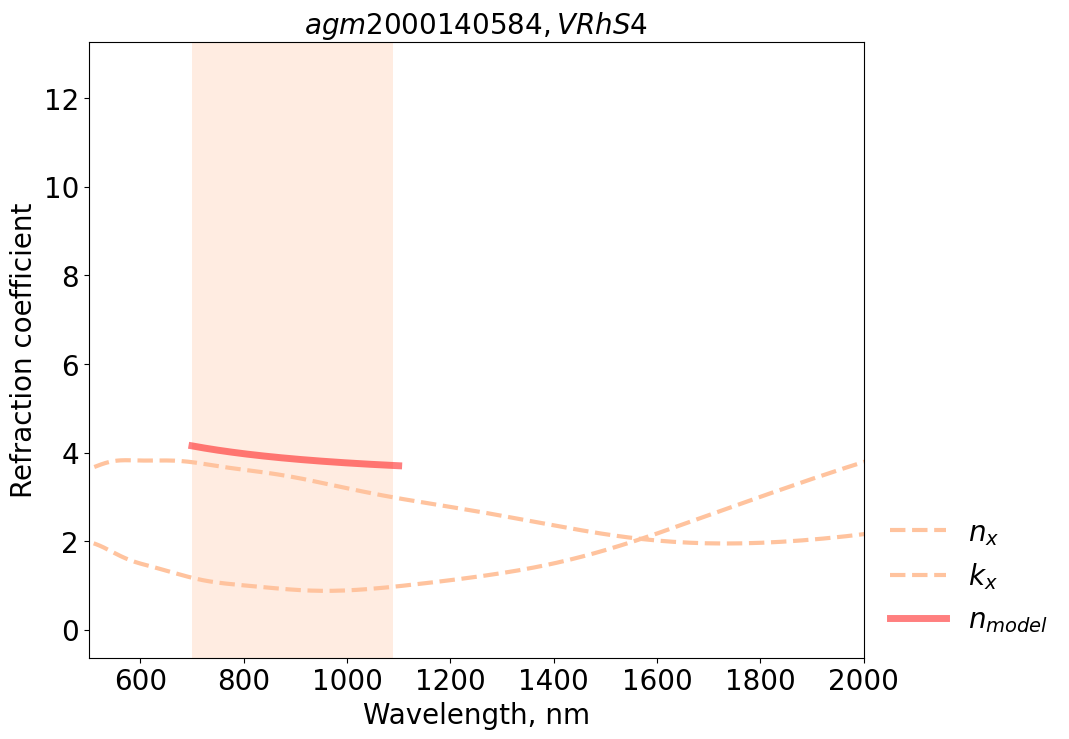

agm2000140574


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


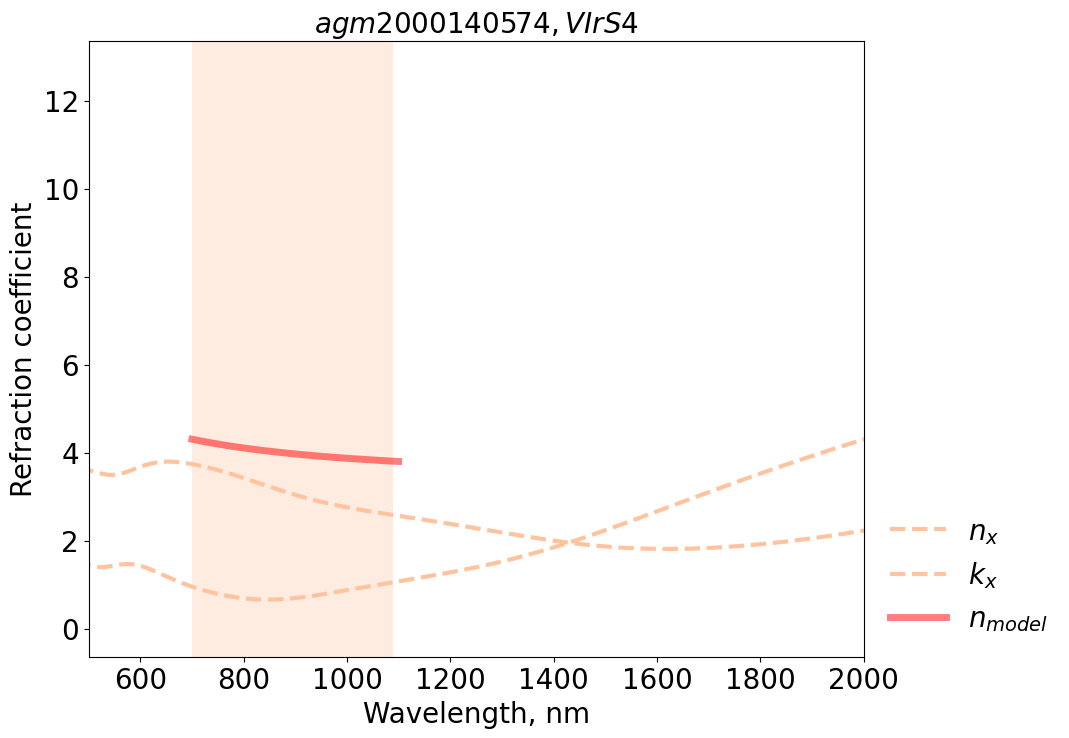

agm2000111613


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


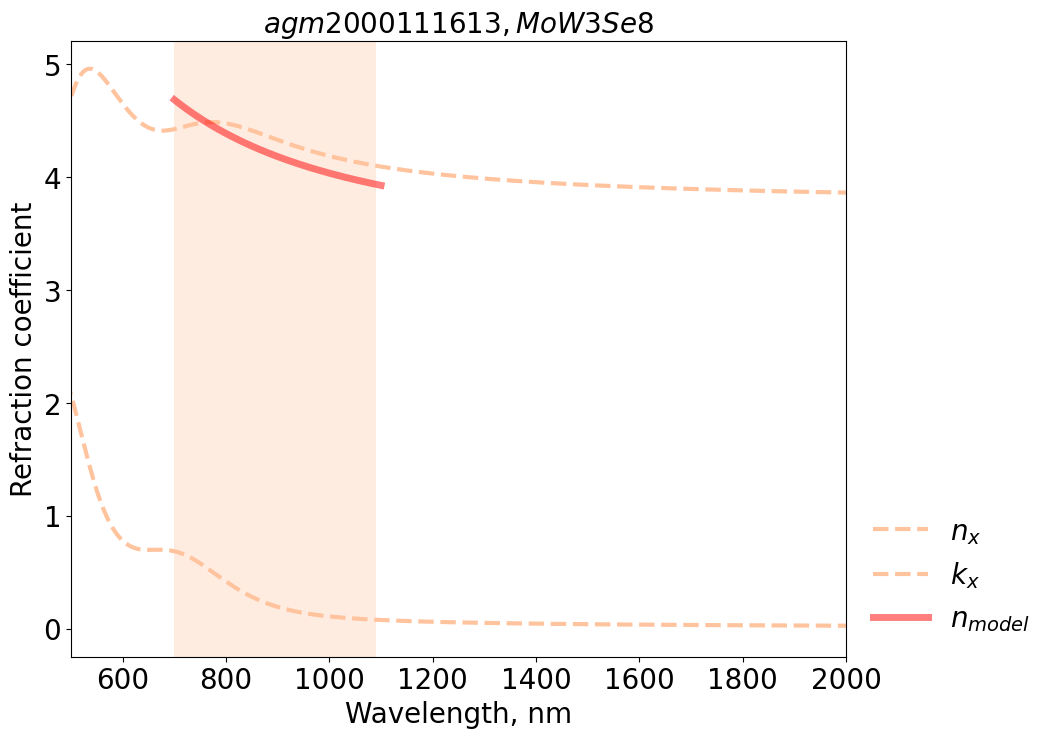

agm2000140568


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


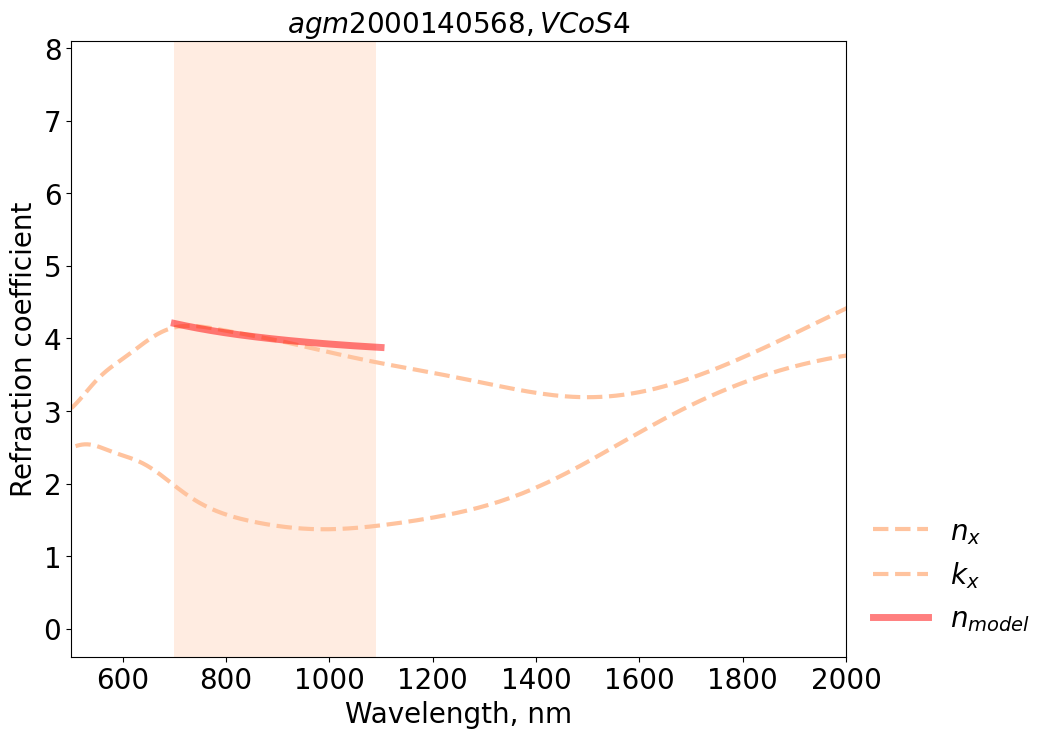

agm2000140575


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


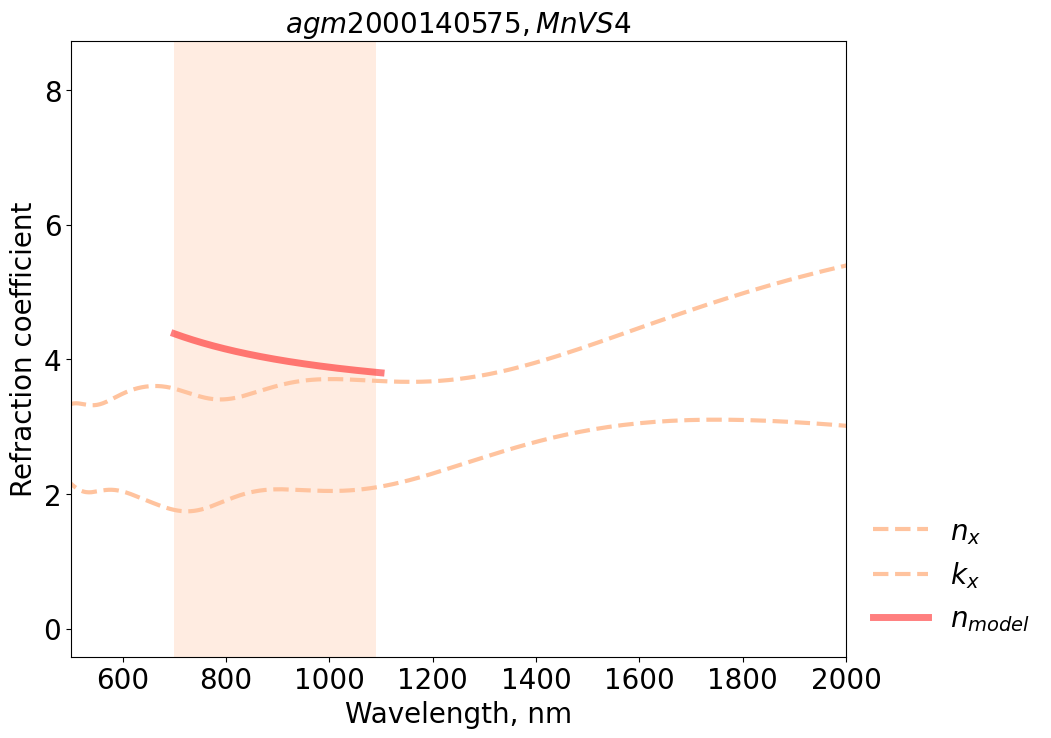

agm2000060793


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


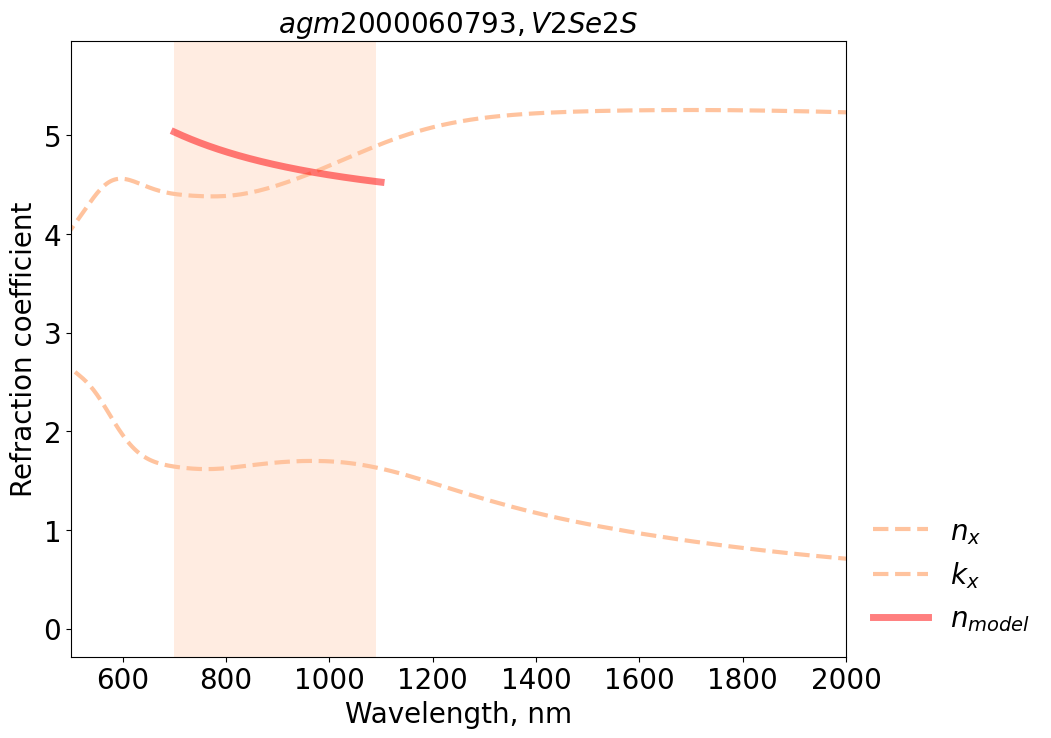

agm2000003547


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


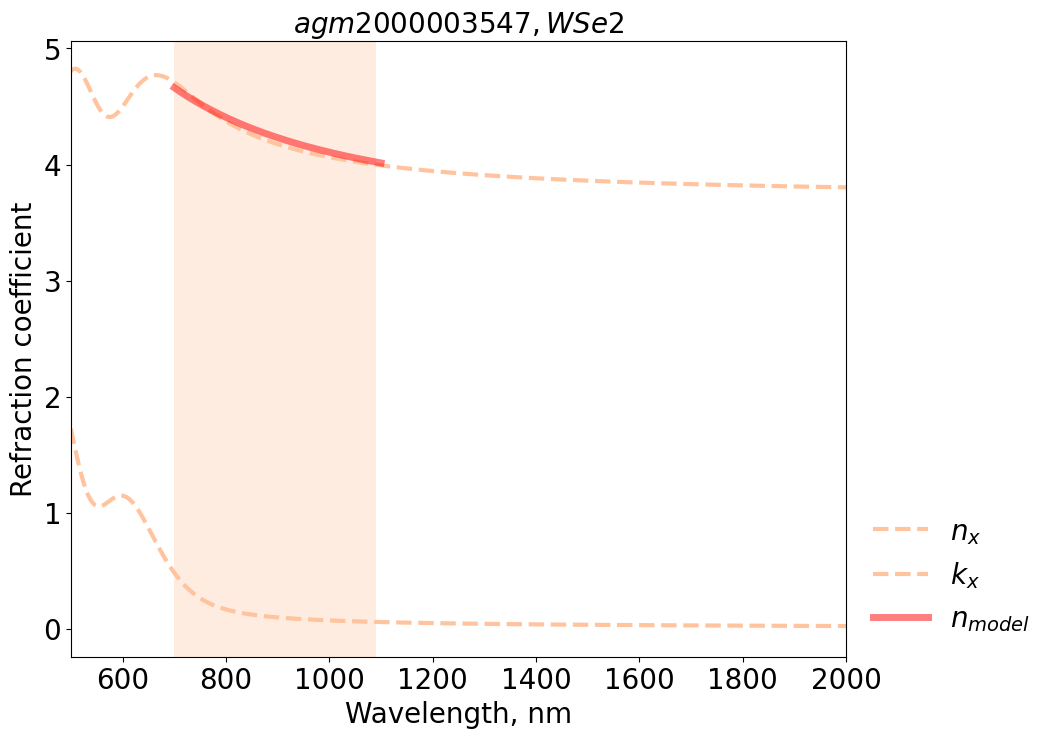

agm2000140587


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


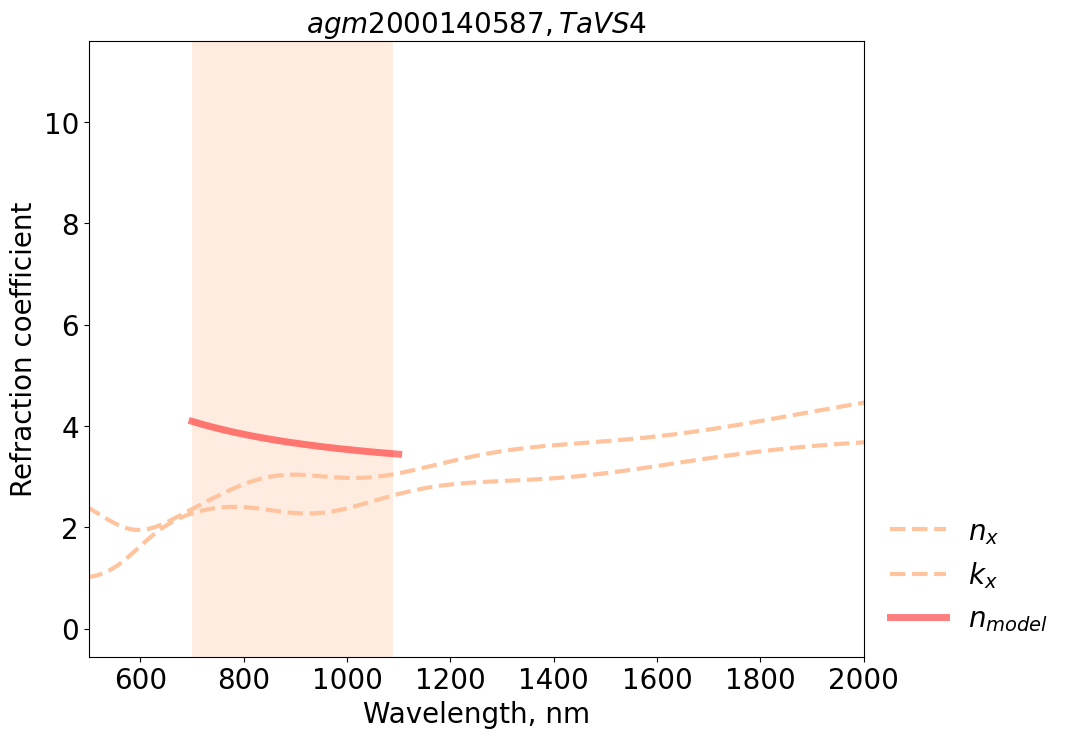

agm2000110598


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


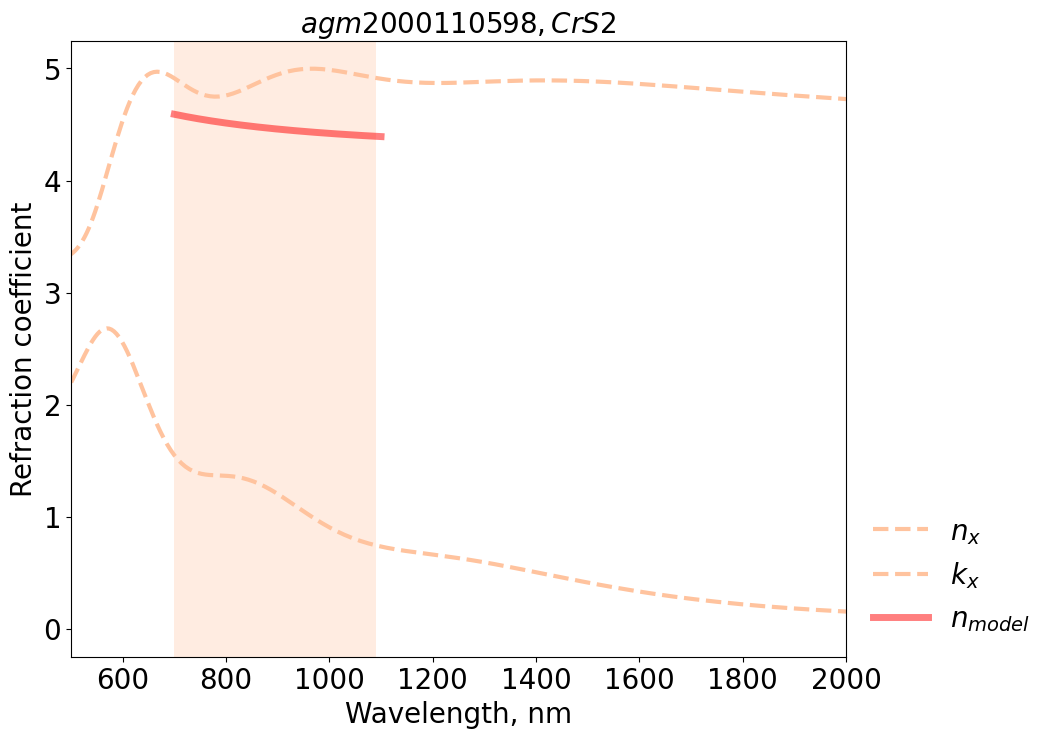

agm2000140432


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


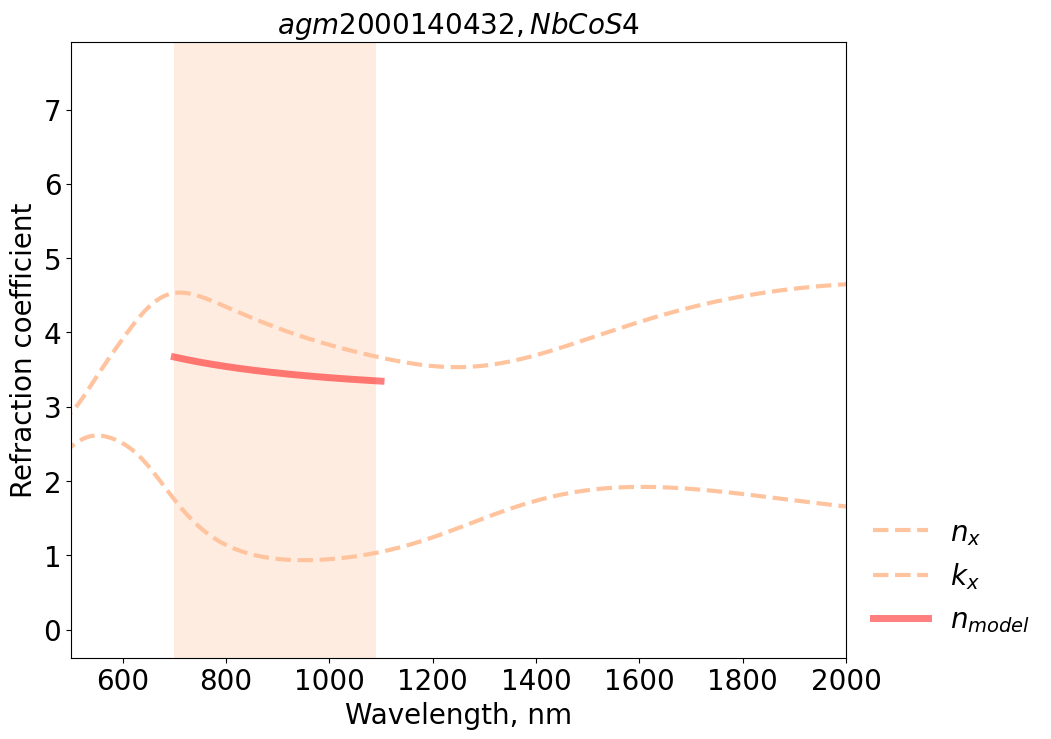

agm2000140493


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


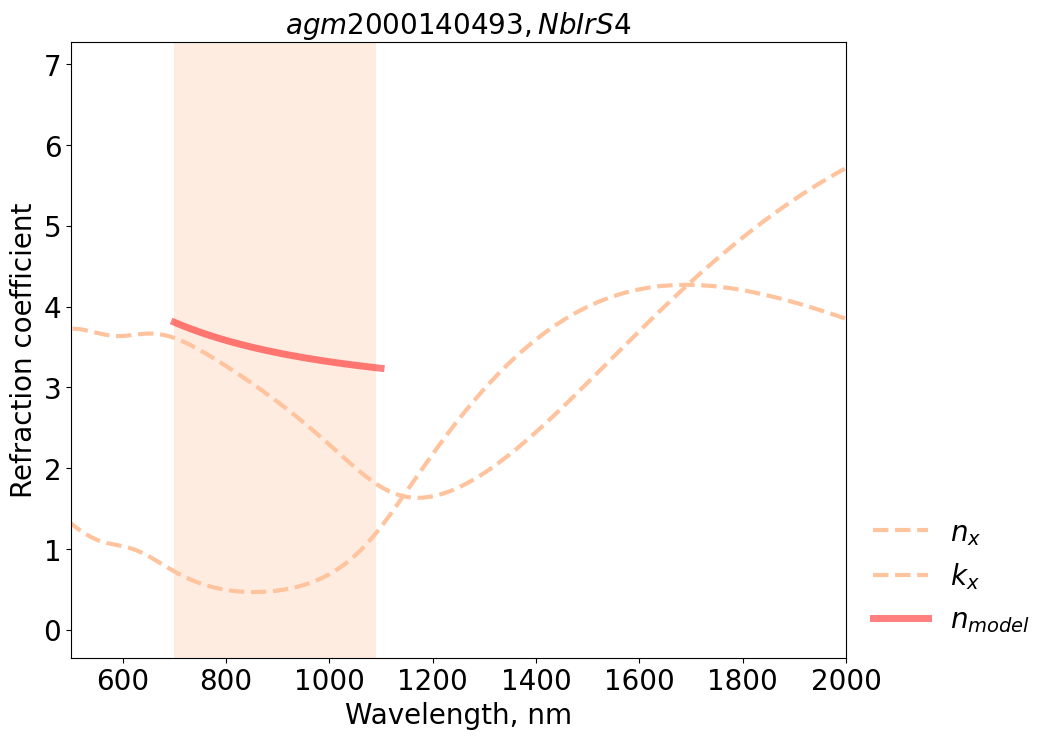

agm2000030431


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


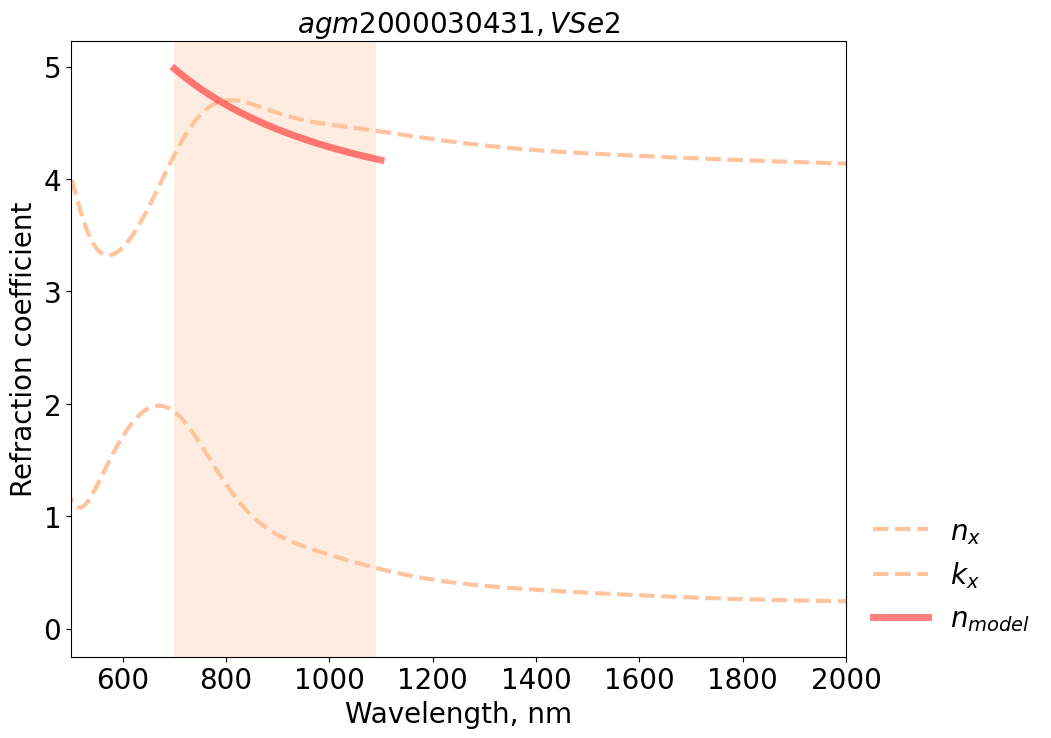

agm2000110618


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


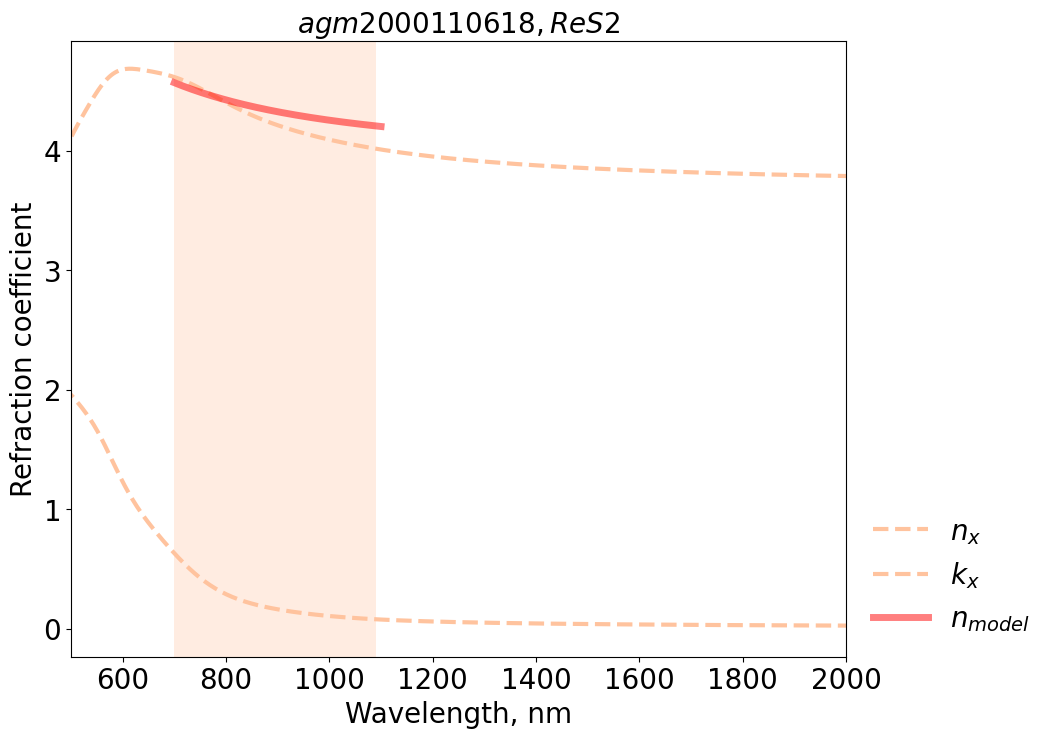

agm2000140551


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


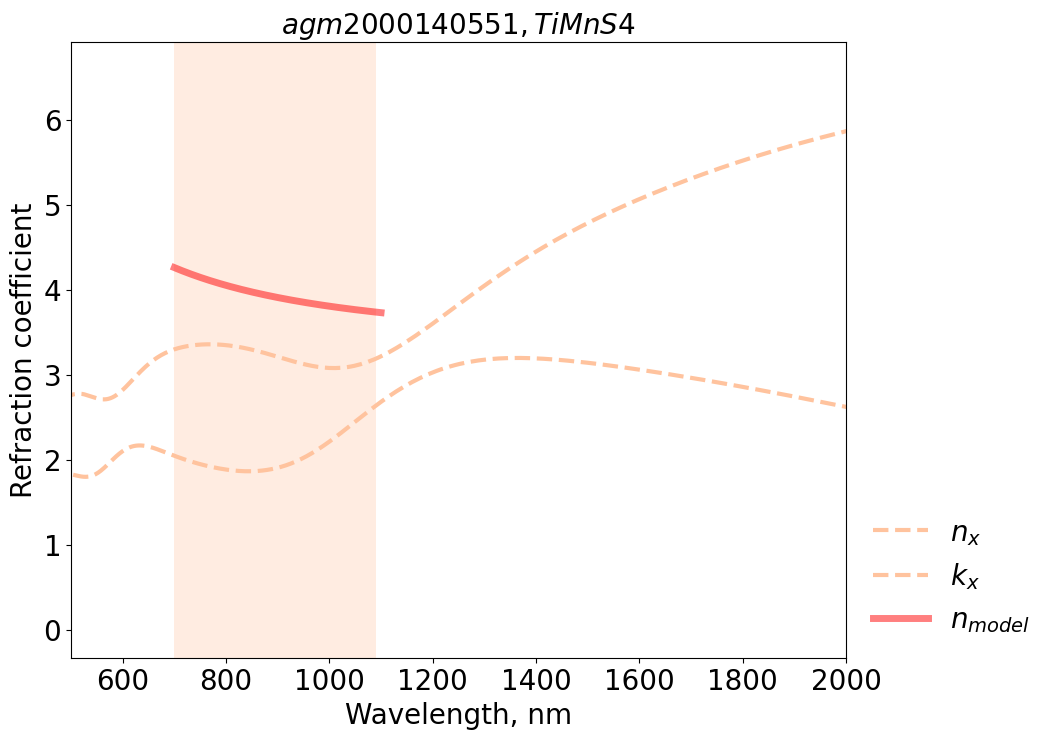

agm2000140474


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


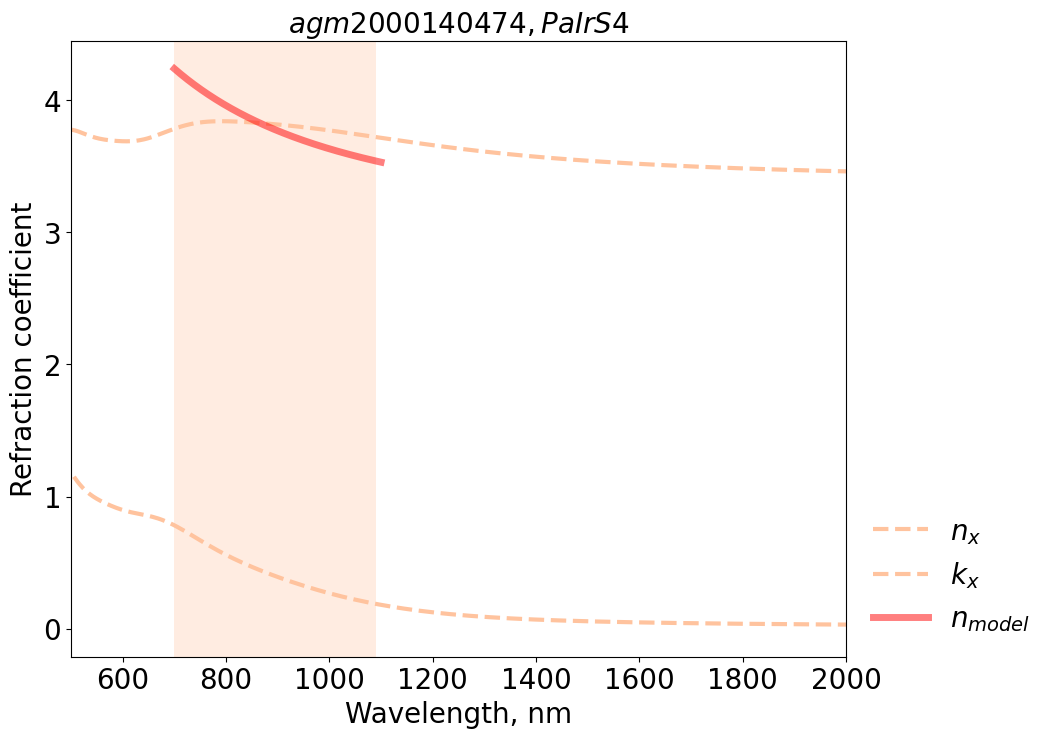

agm2000140434


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


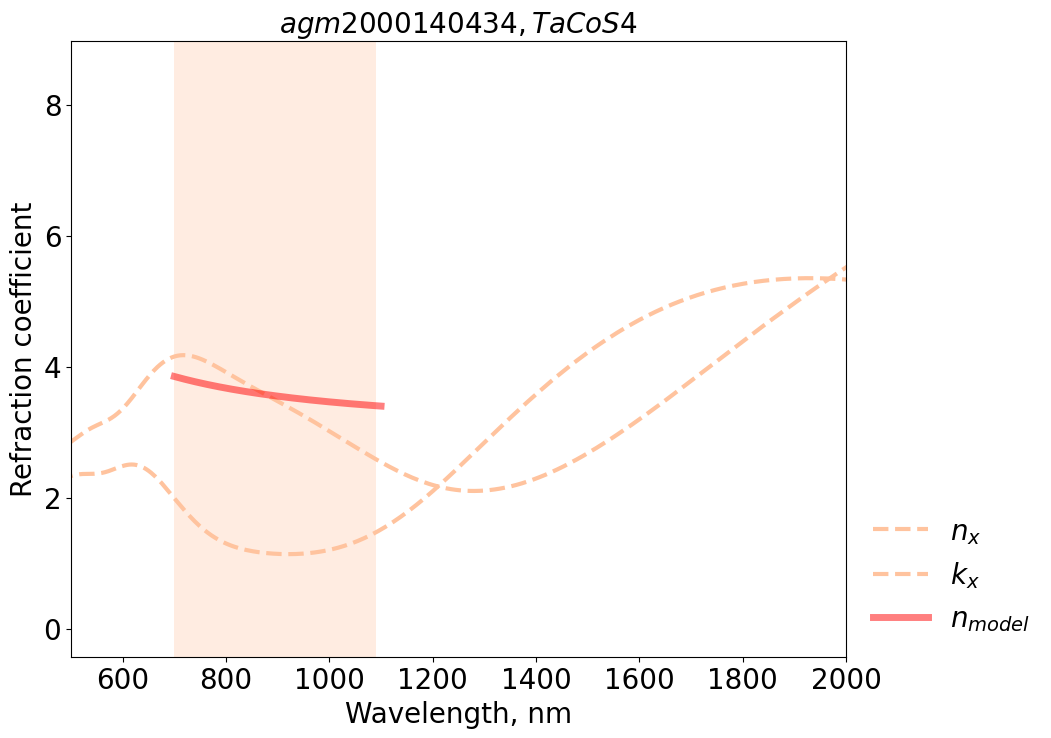

agm2000140500


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


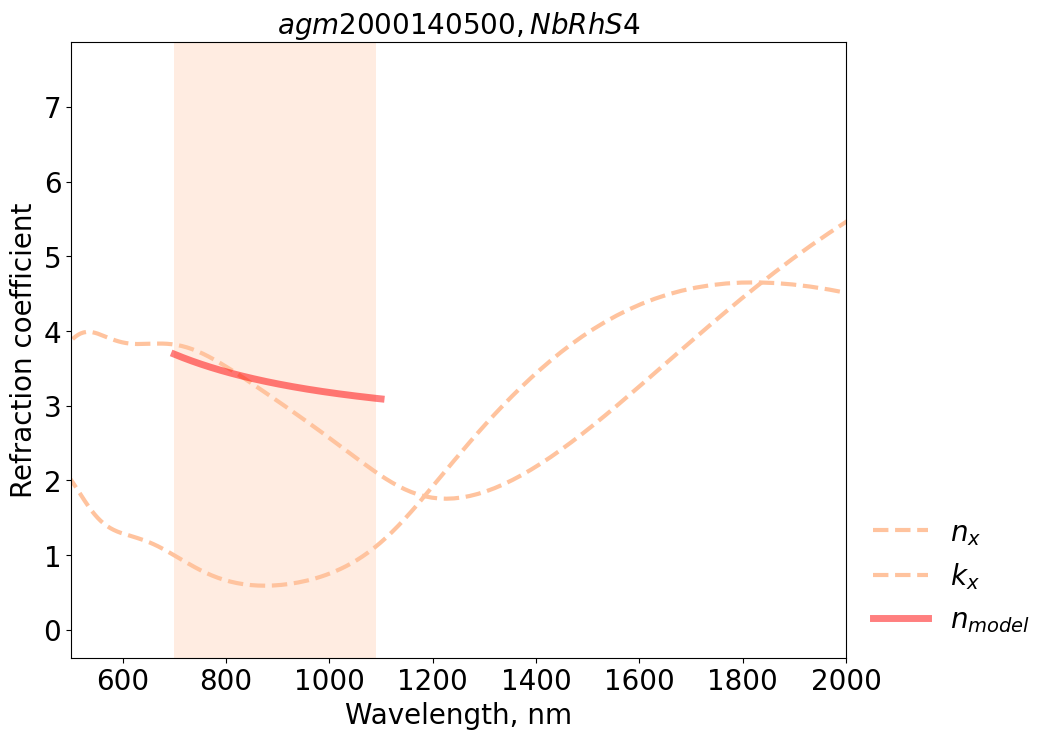

agm2000140484


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


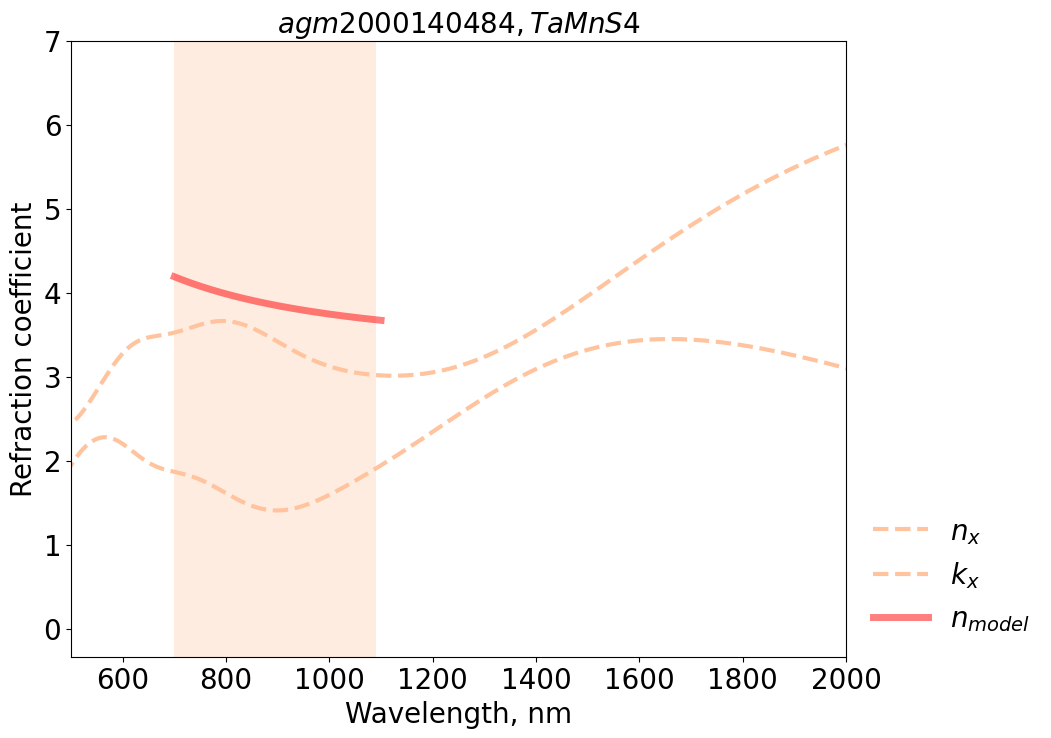

agm2000140531


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


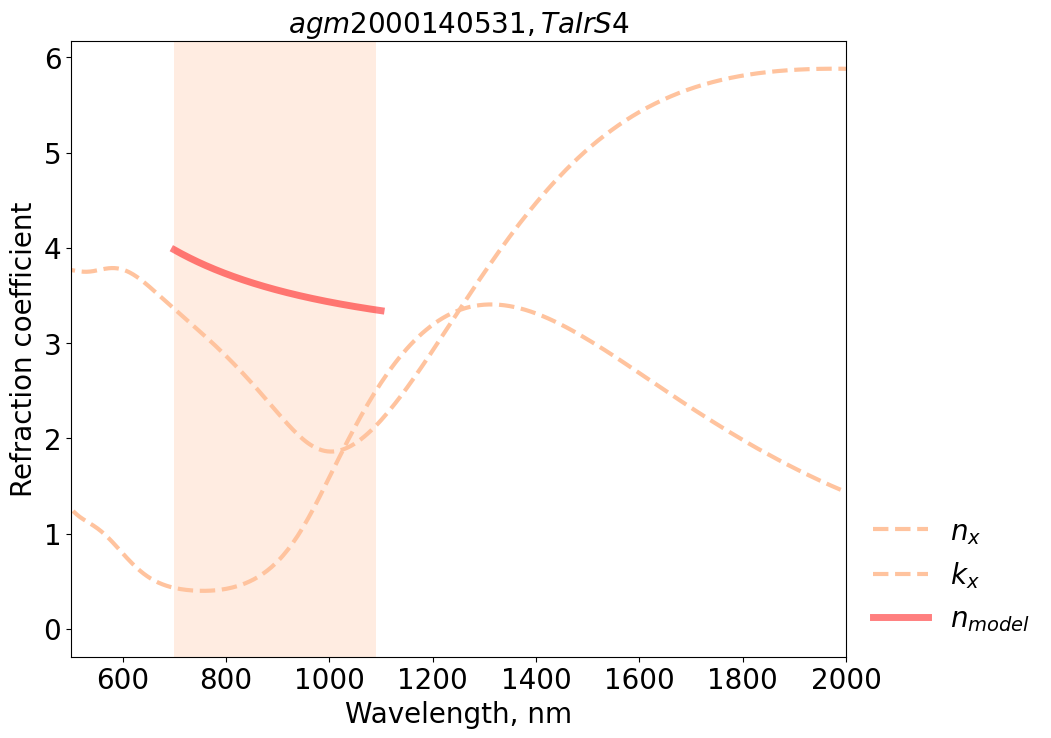

agm2000140793


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


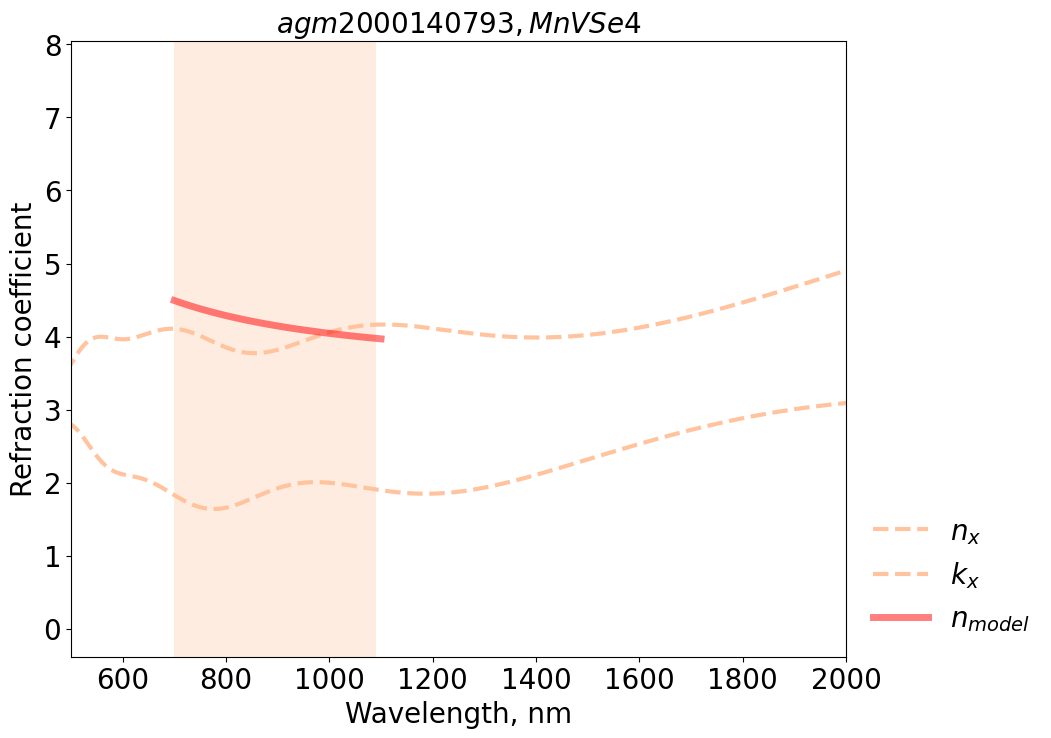

agm2000140517


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


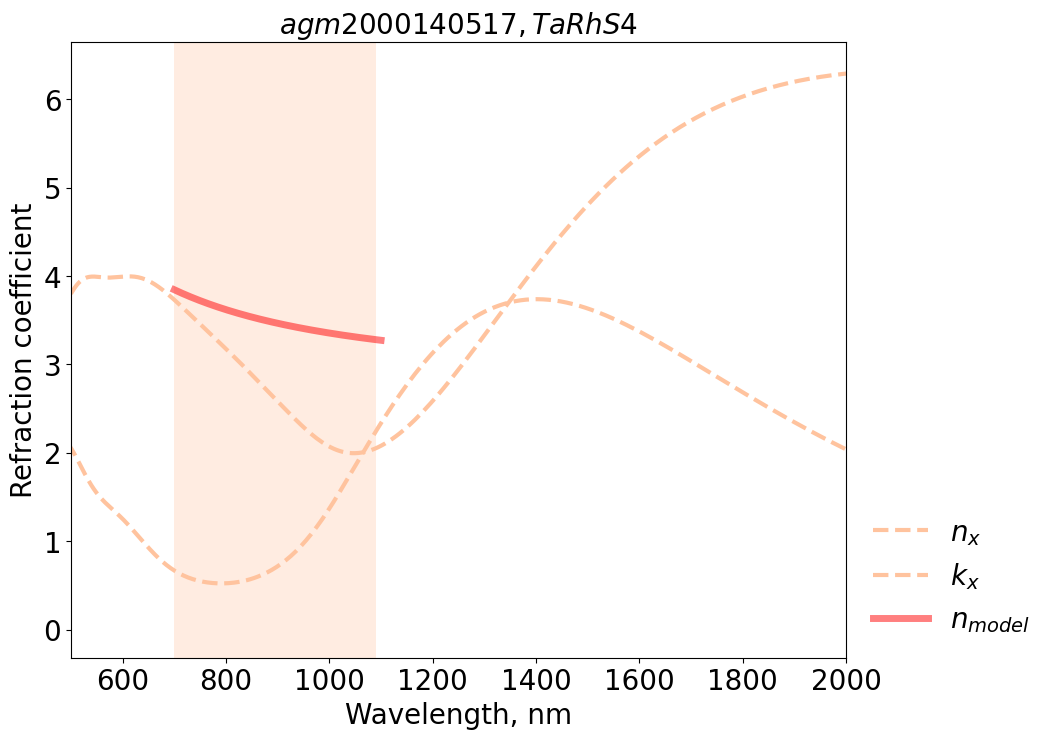

agm2000133939


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


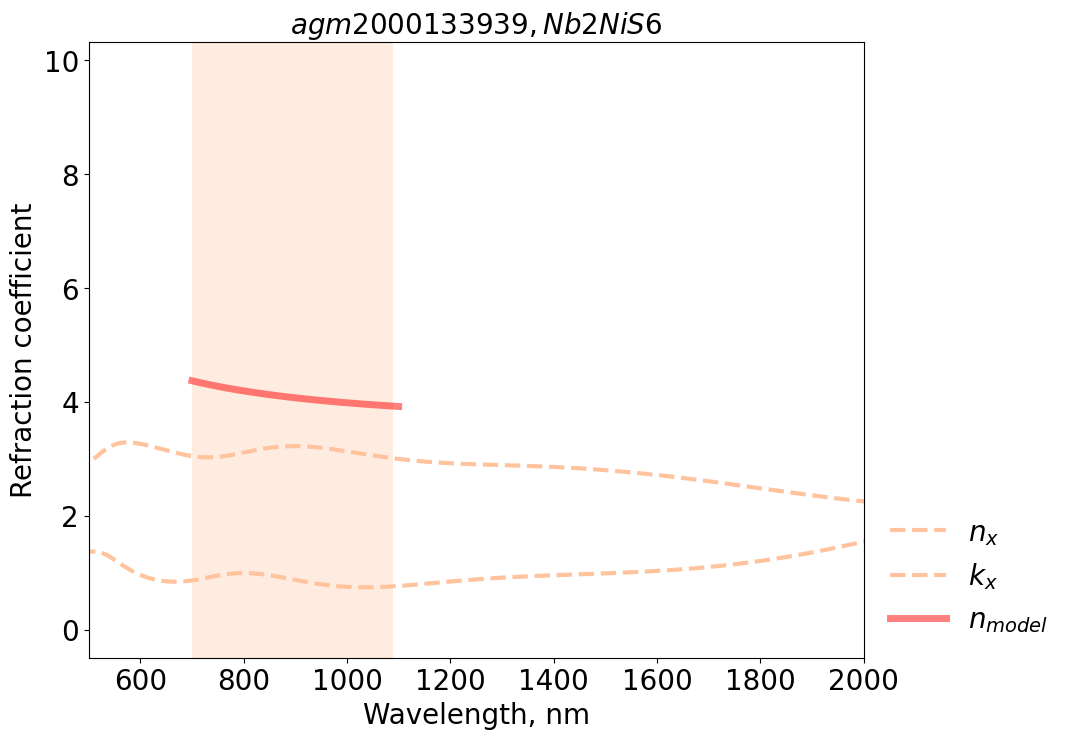

agm2000109806


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


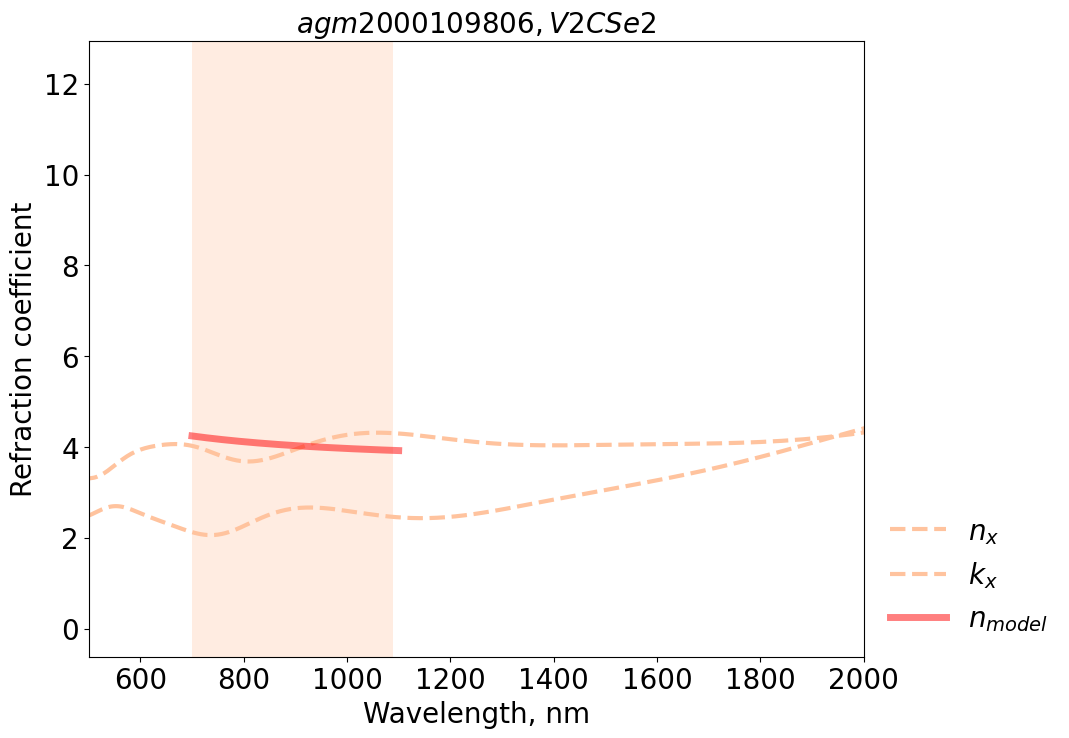

agm2000111646


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


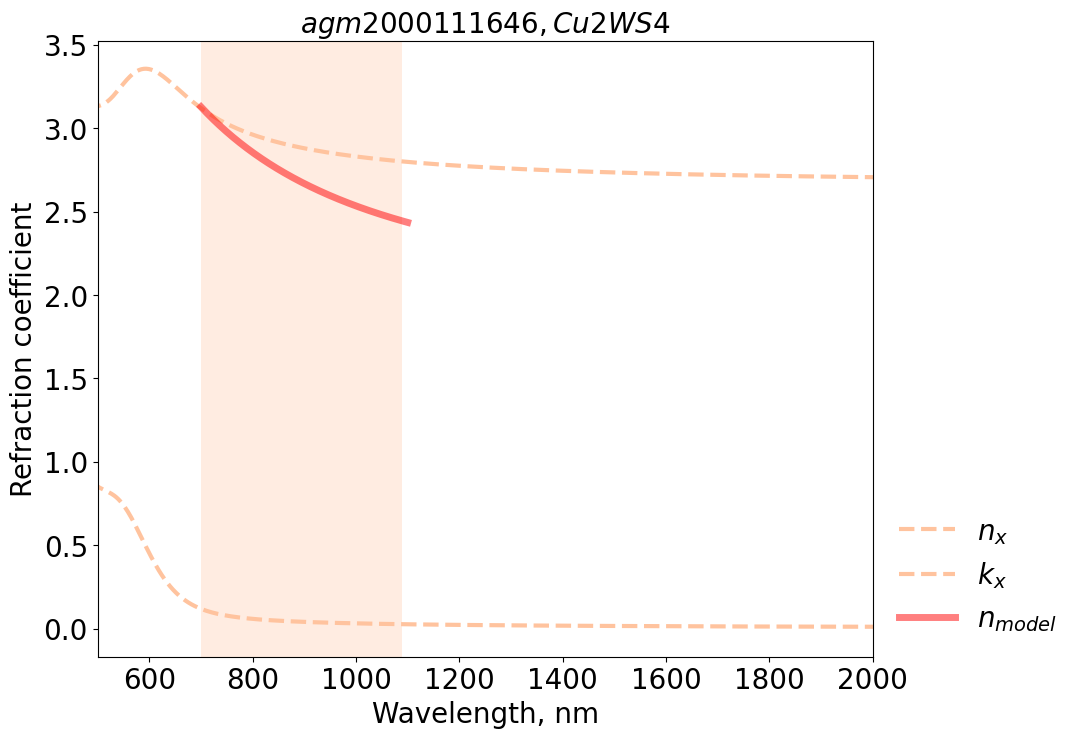

agm2000140784


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


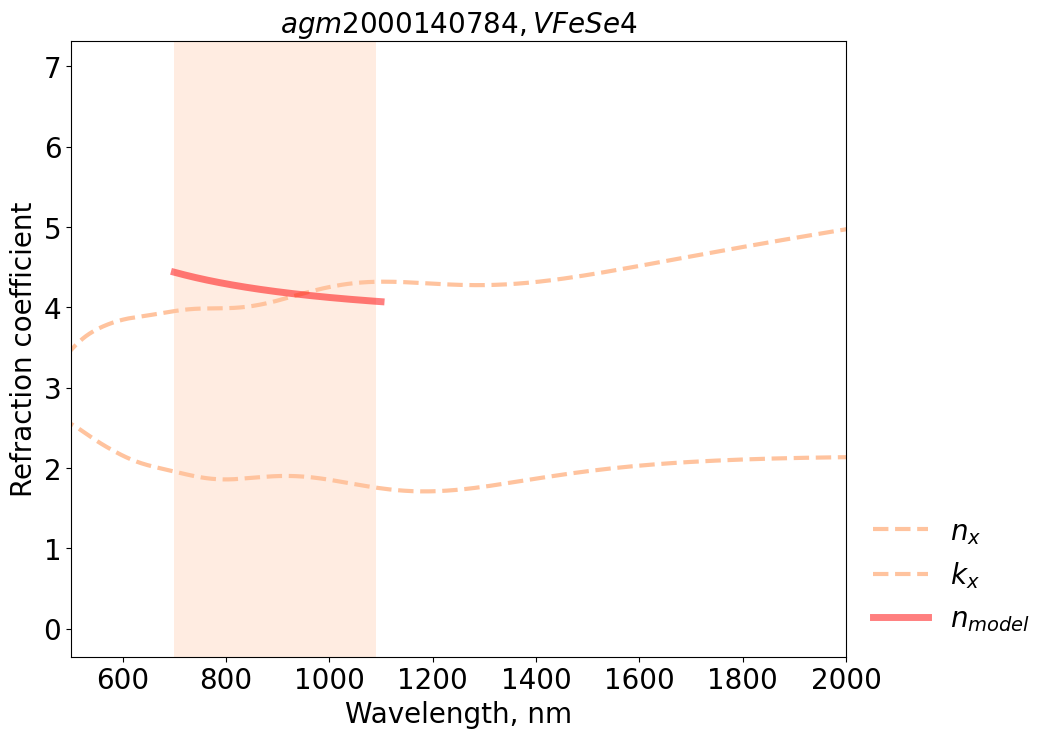

agm2000140776


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


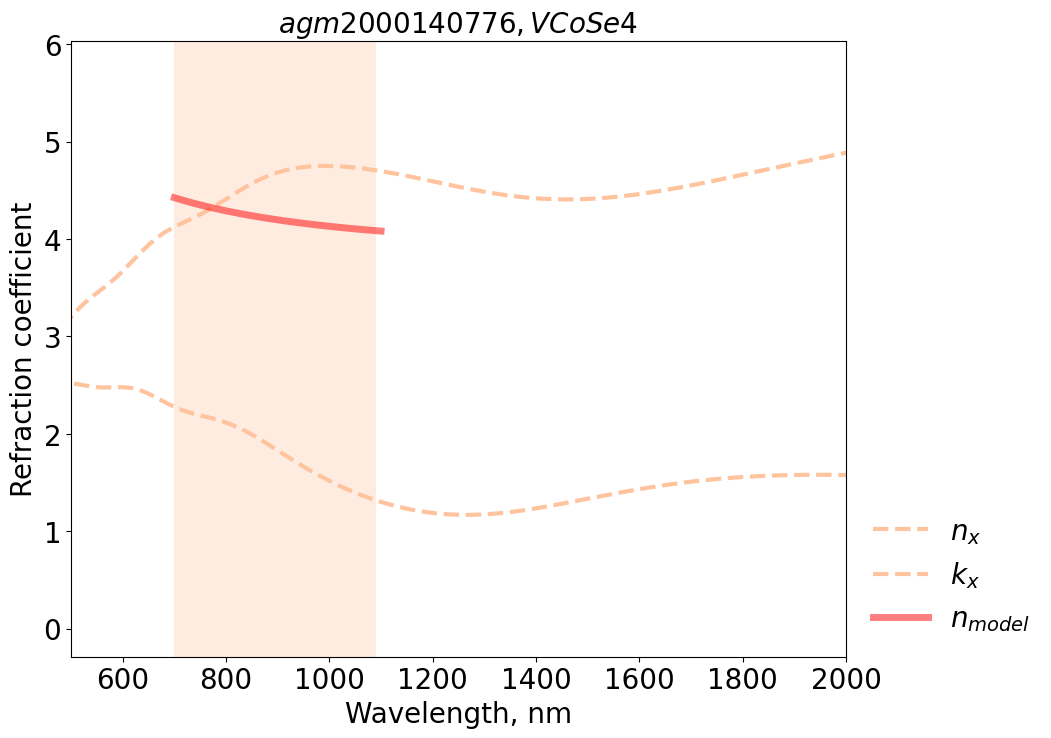

agm2000140808


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


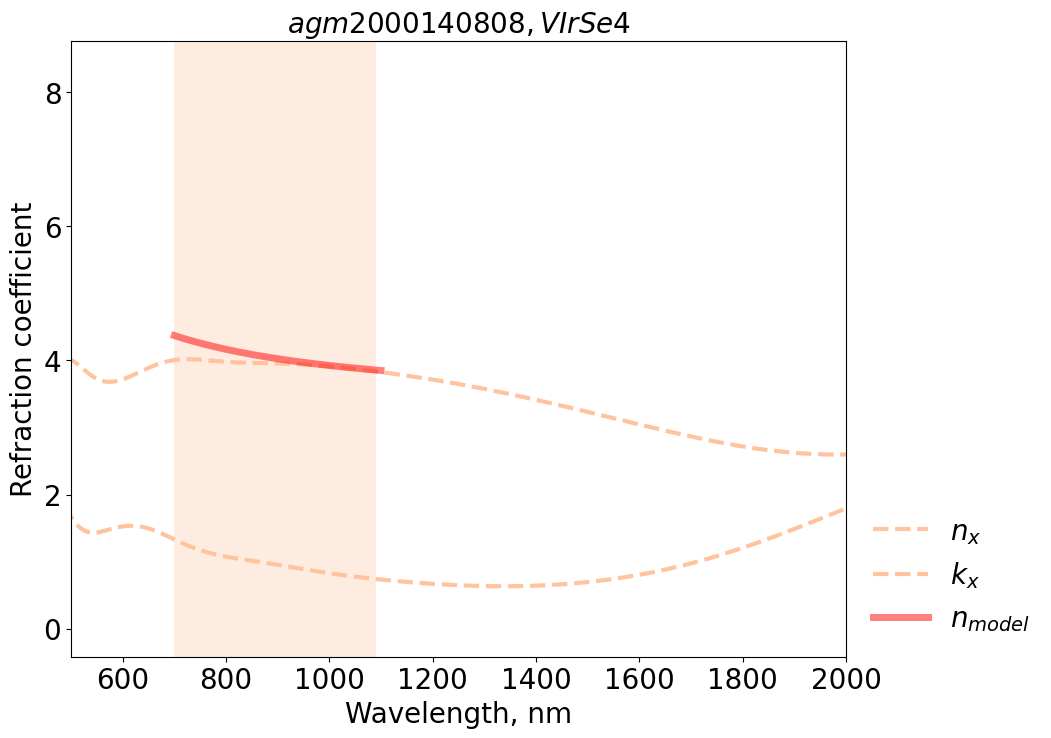

agm2000140817


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


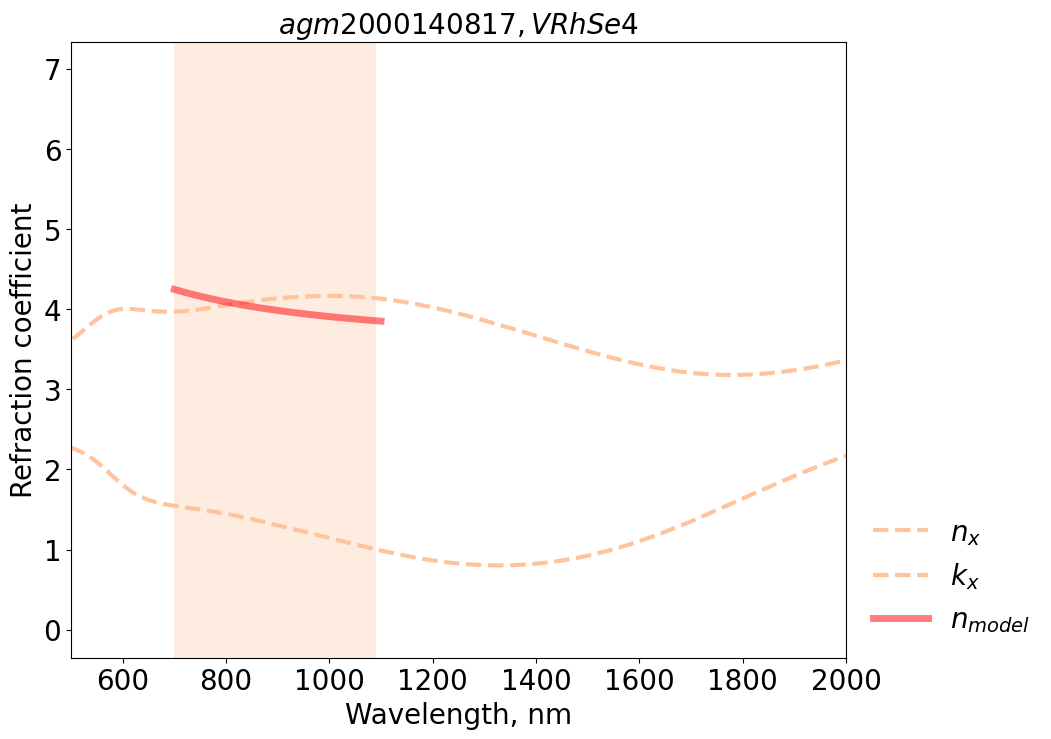

agm2000140812


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


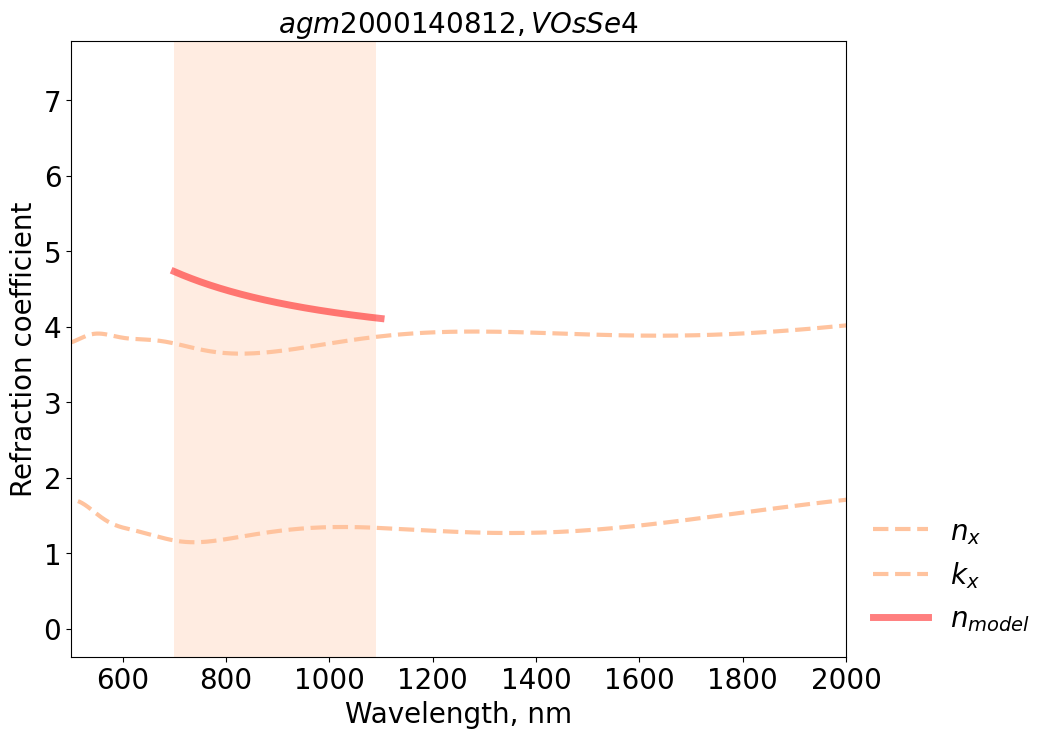

agm2000081611


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


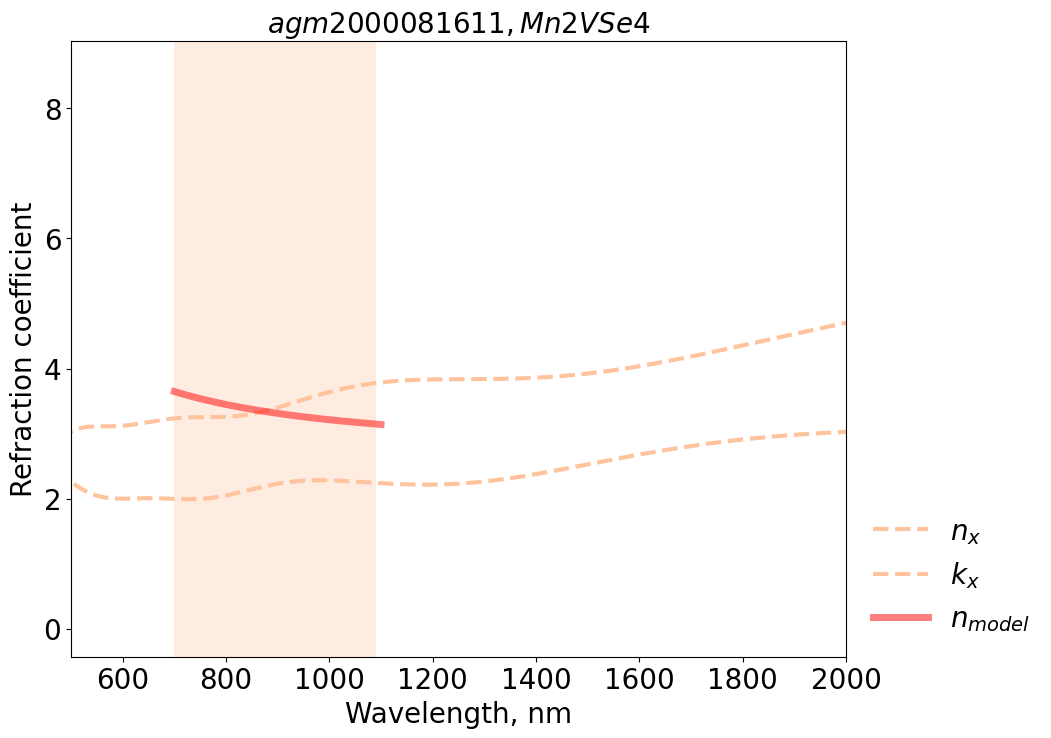

agm2000133943


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


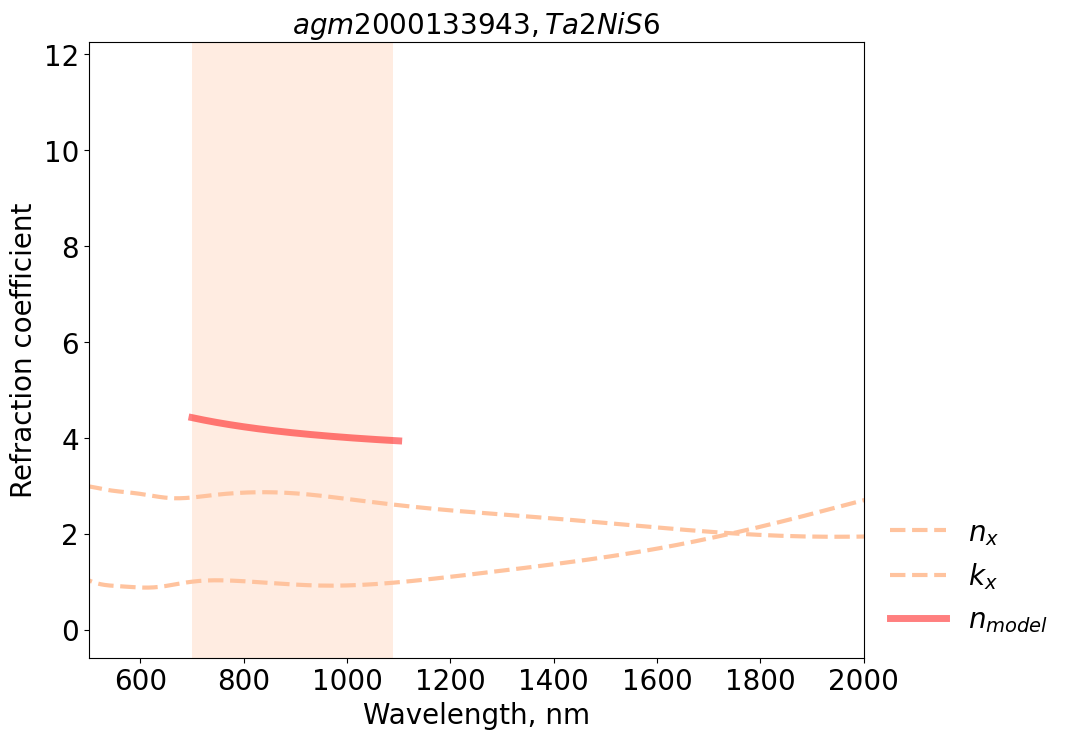

agm2000133940


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


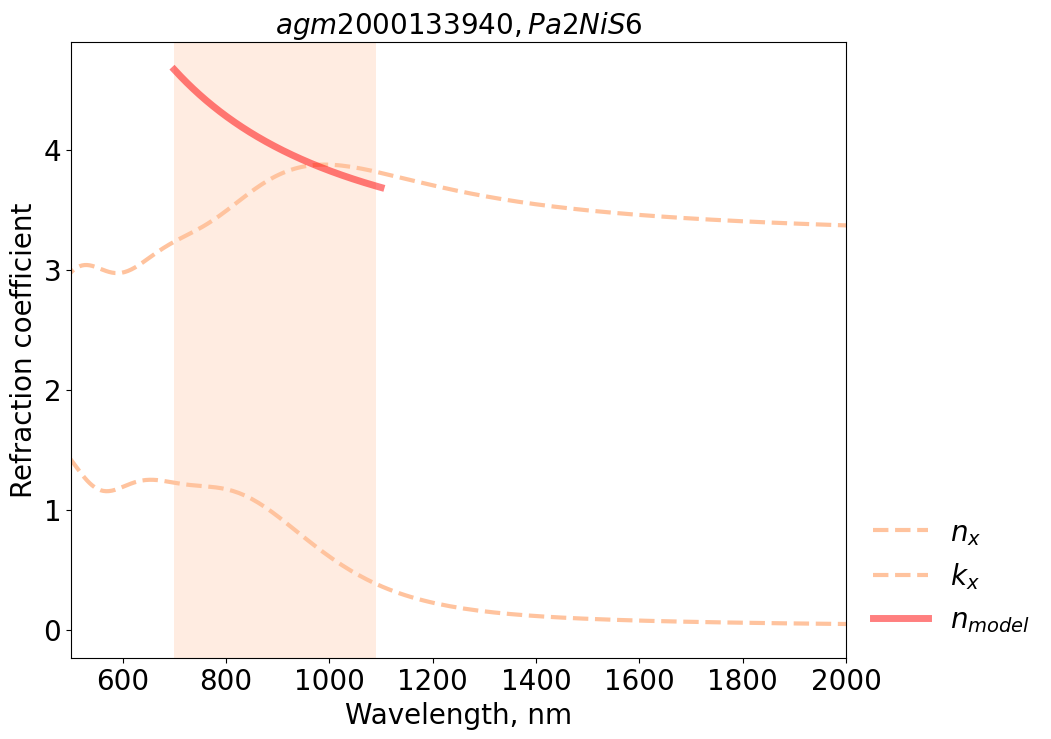

agm2000133931


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


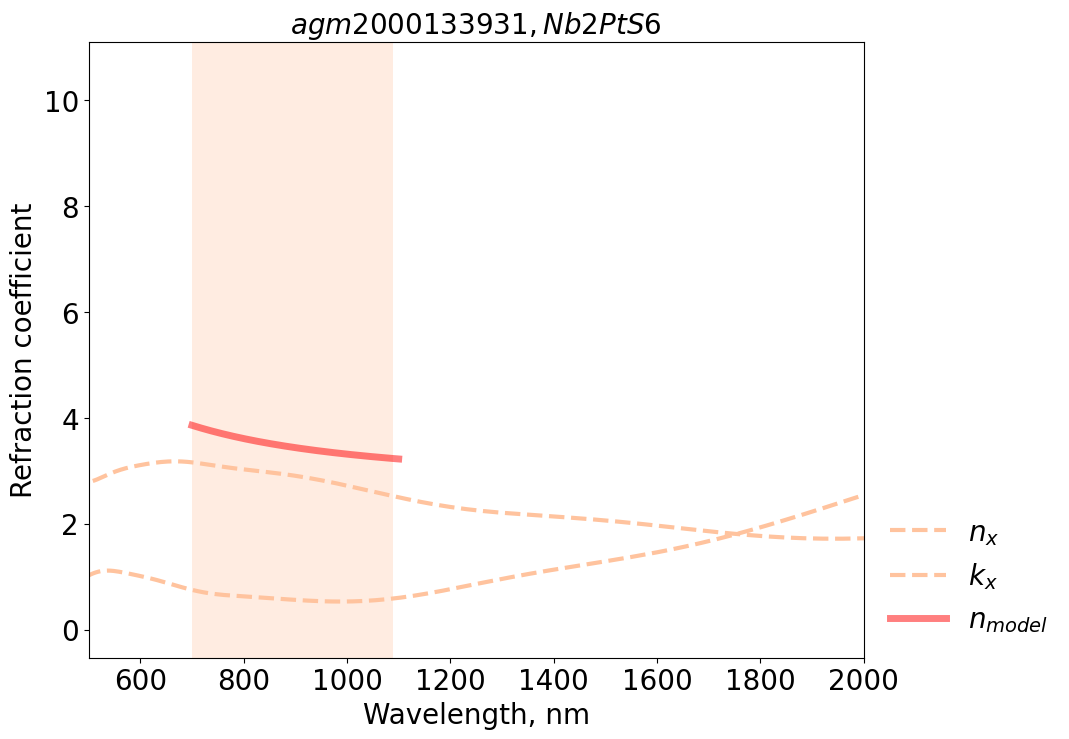

agm2000110650


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


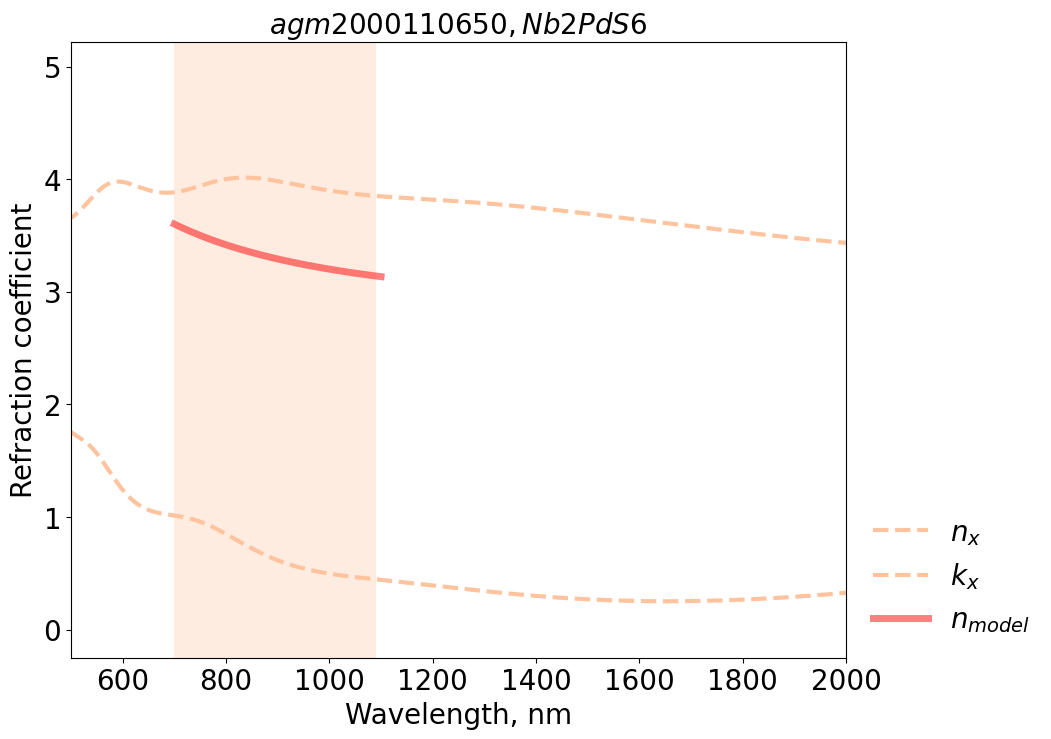

agm2000110606


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


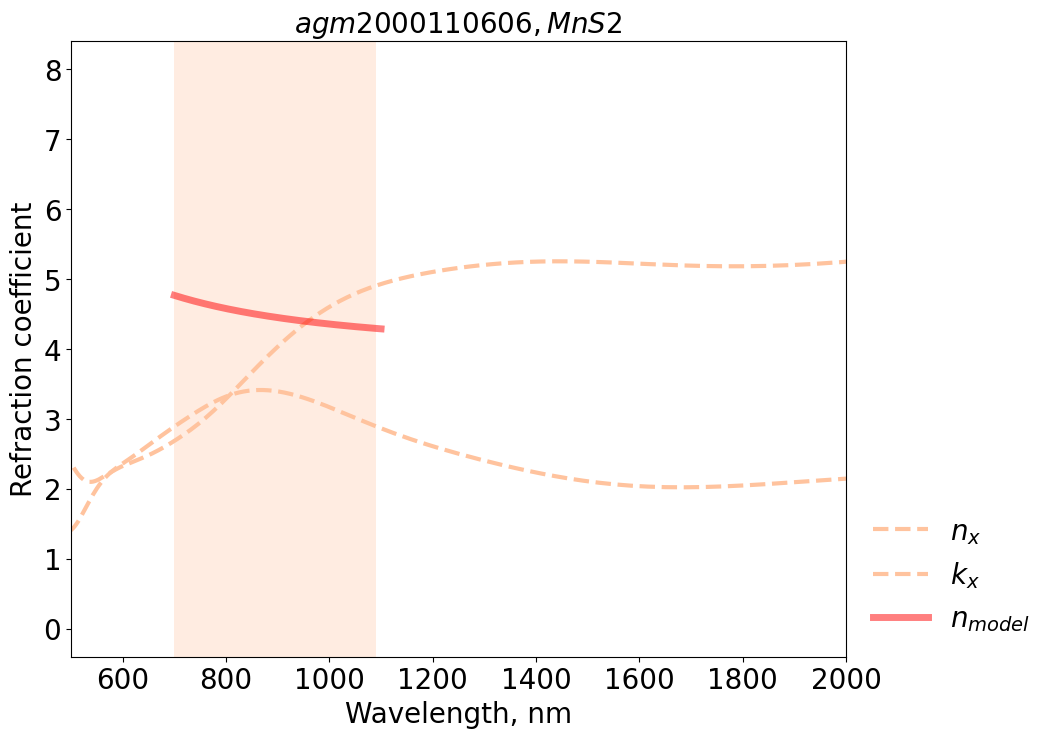

agm2000083361


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


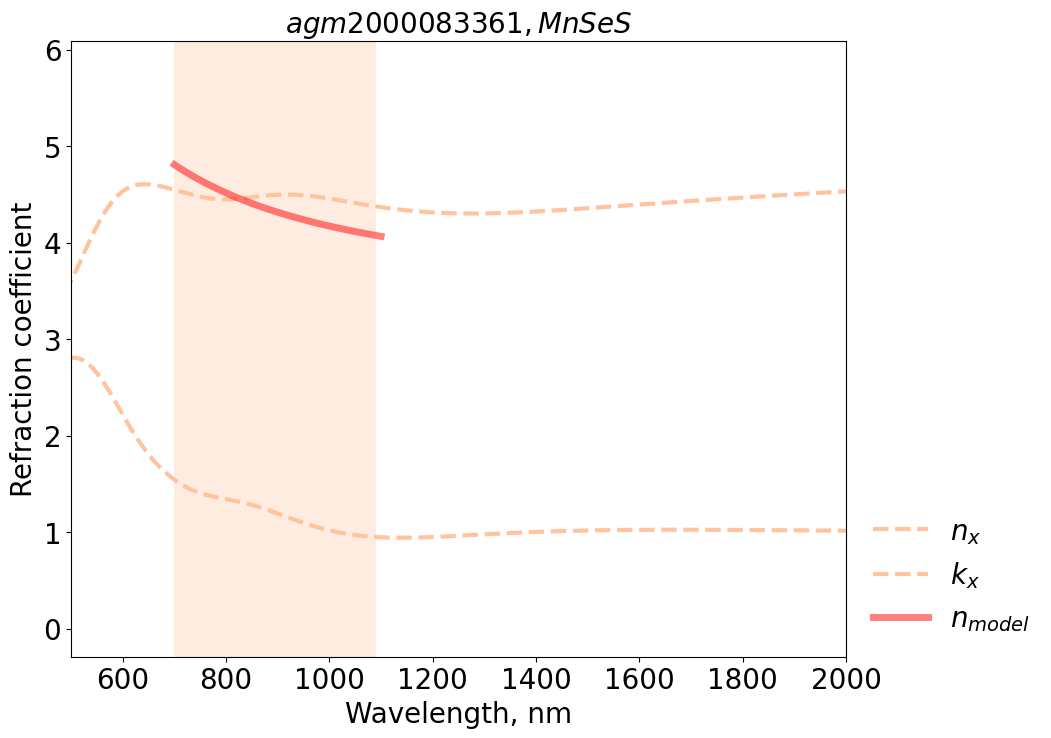

agm2000137728


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


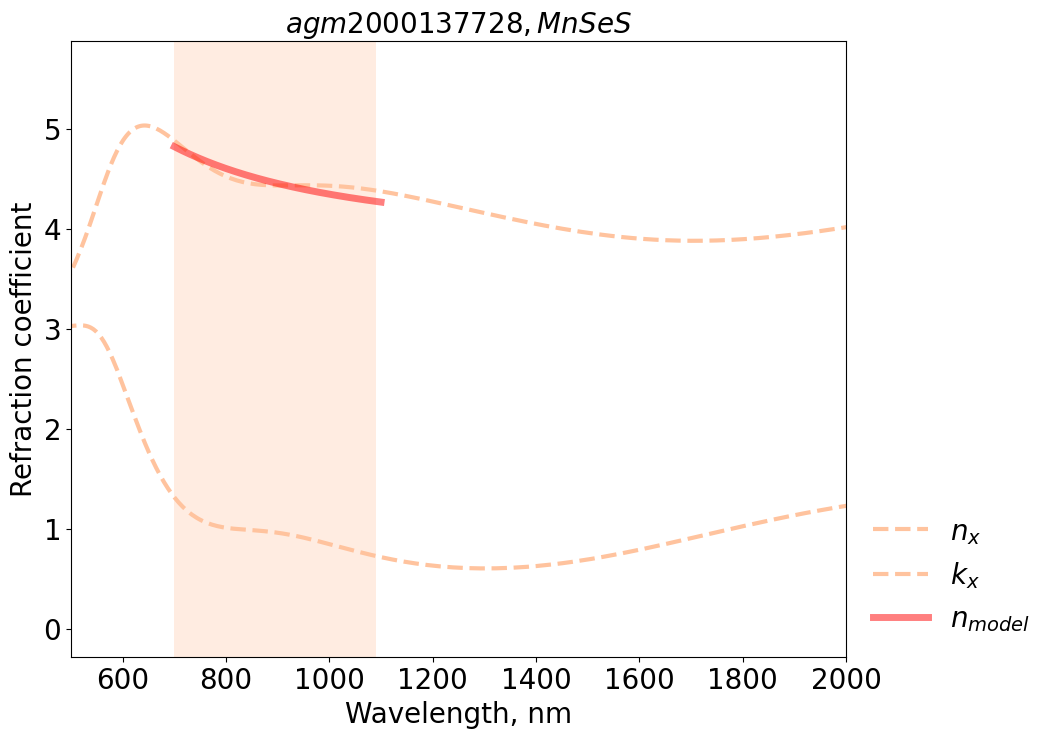

agm2000111201


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


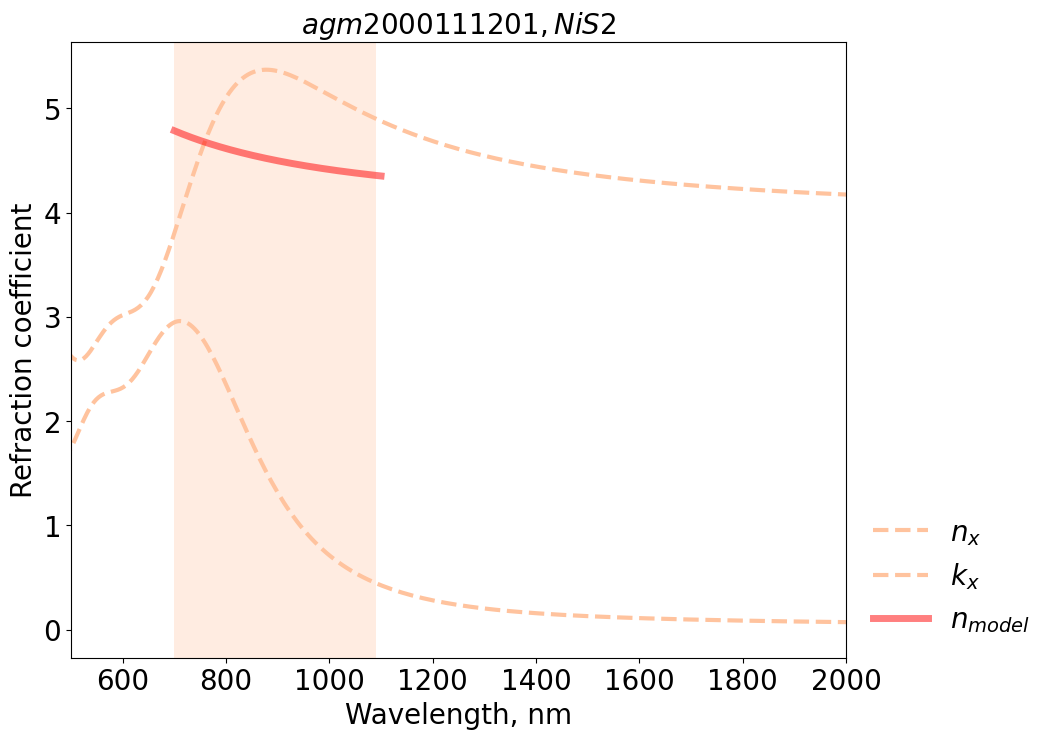

agm2000133950


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


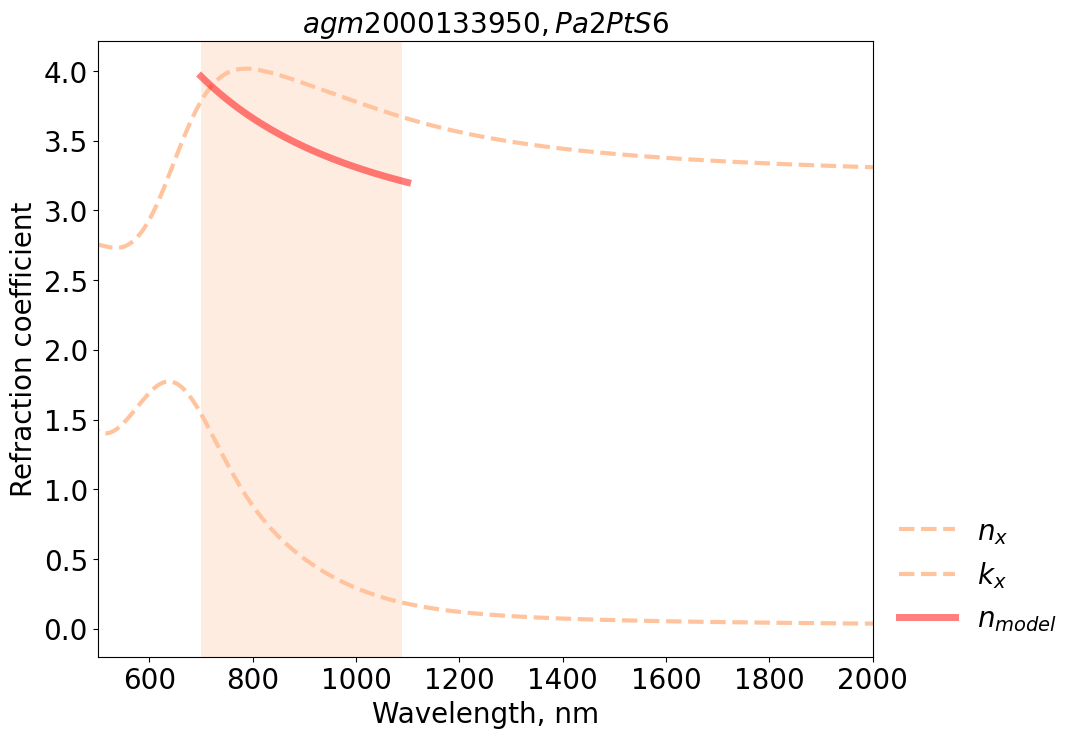

agm2000110649


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


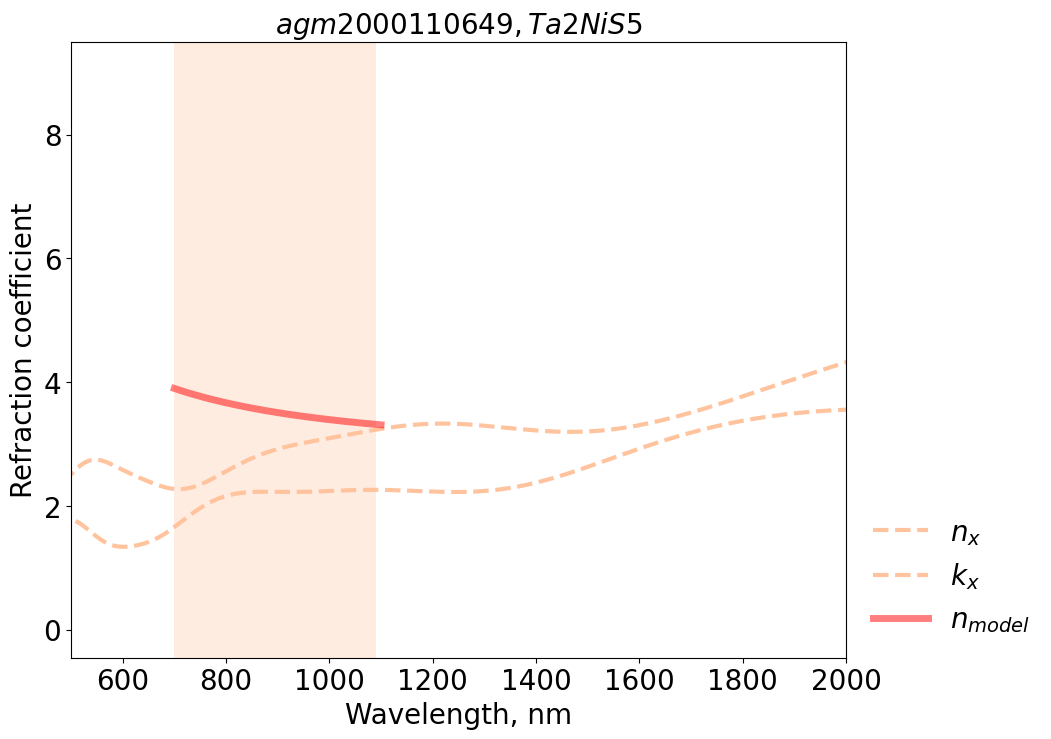

agm2000009024


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


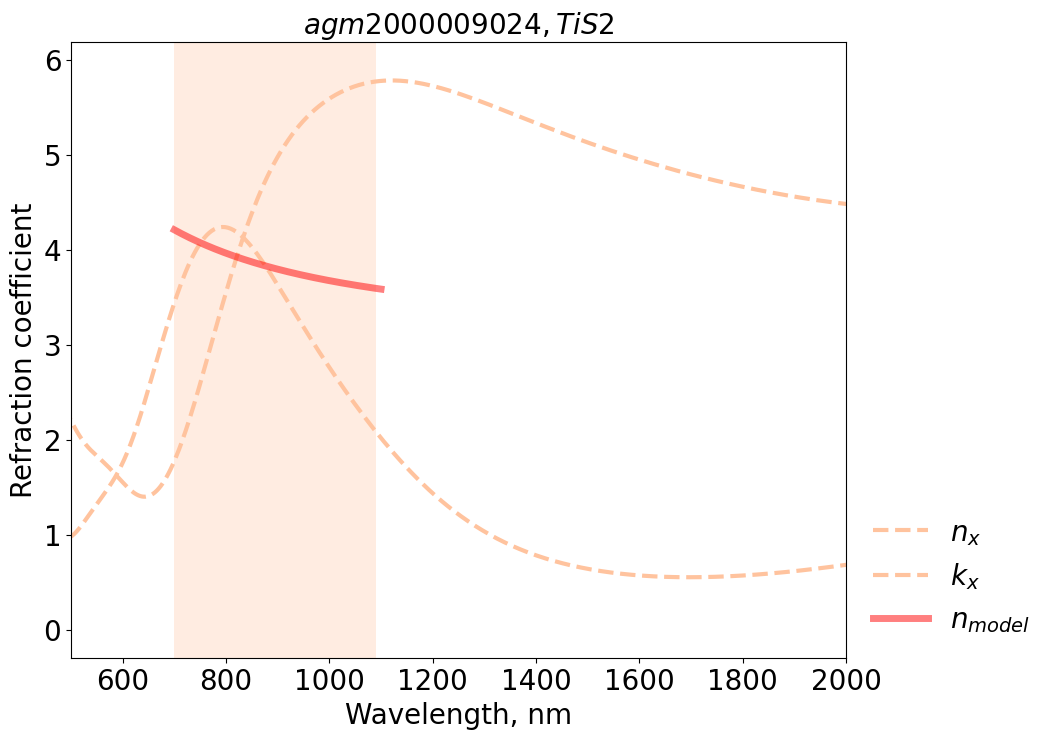

agm2000017467


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


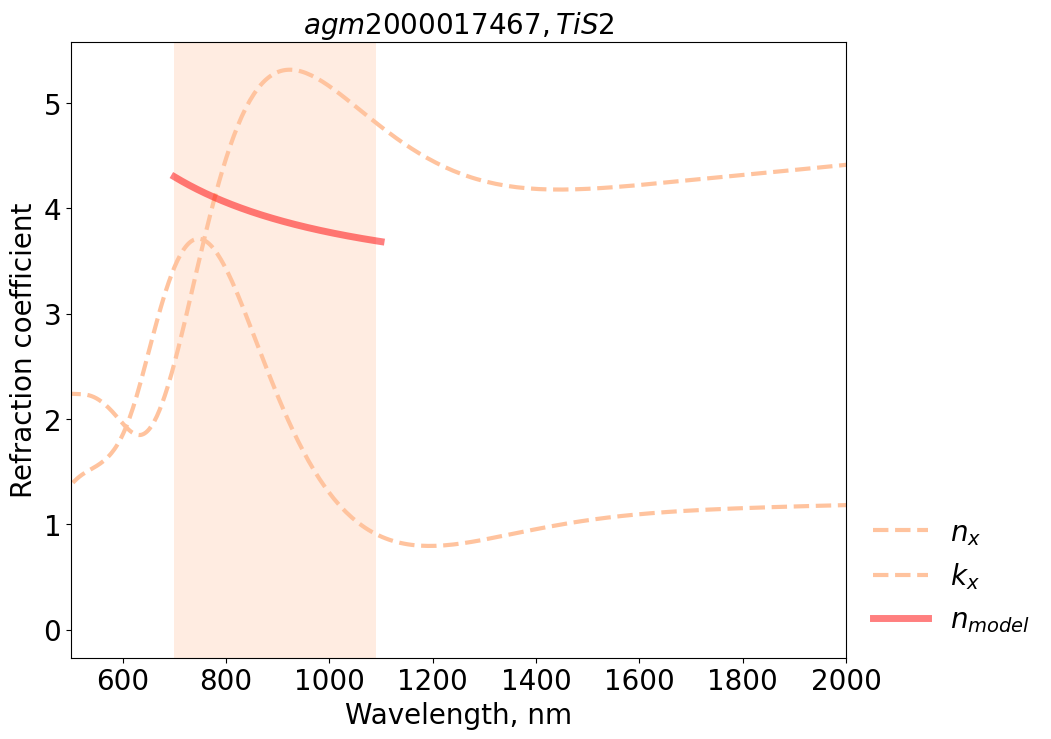

agm2000003608


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


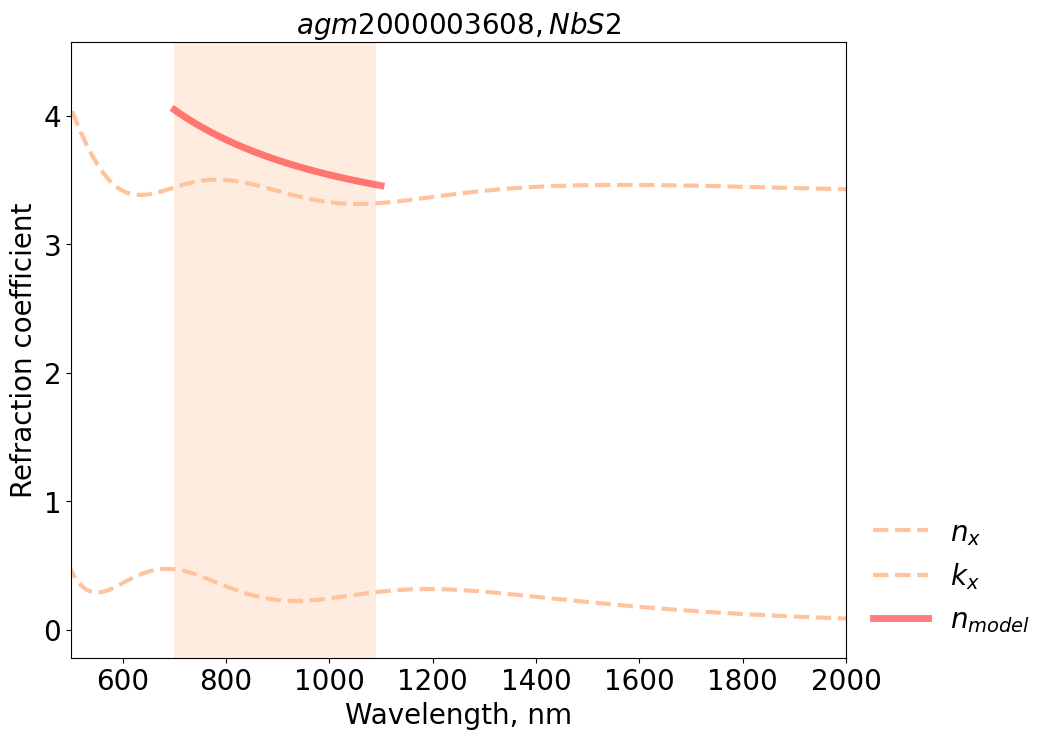

agm2000133978


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


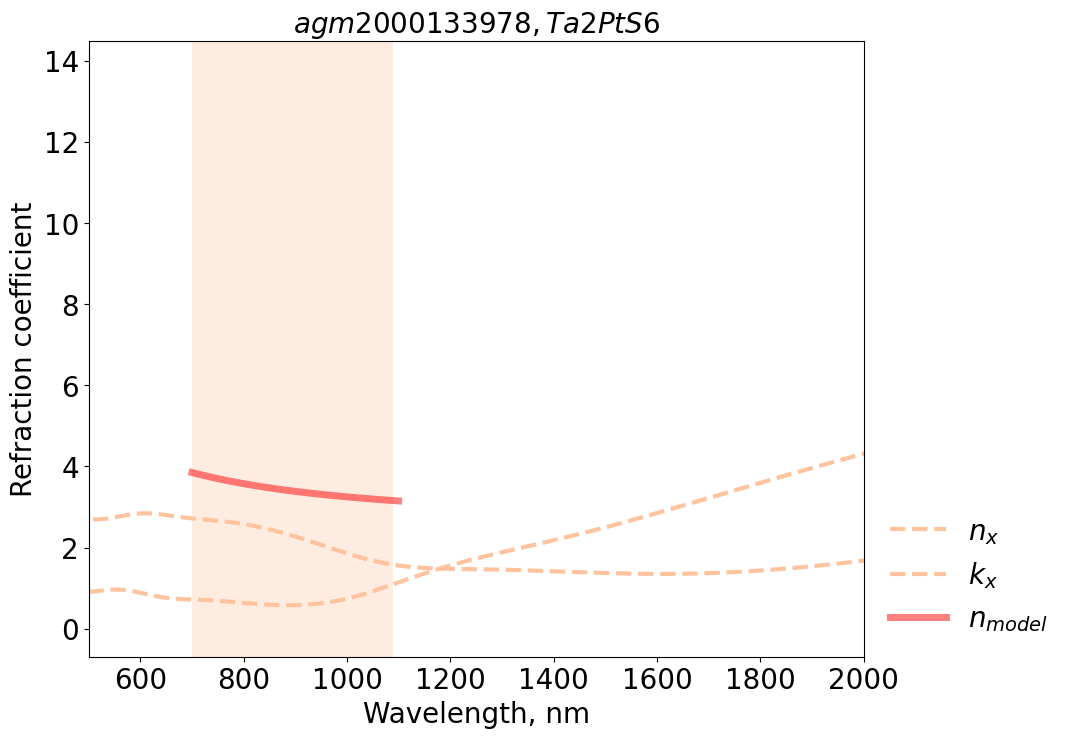

agm2000110651


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


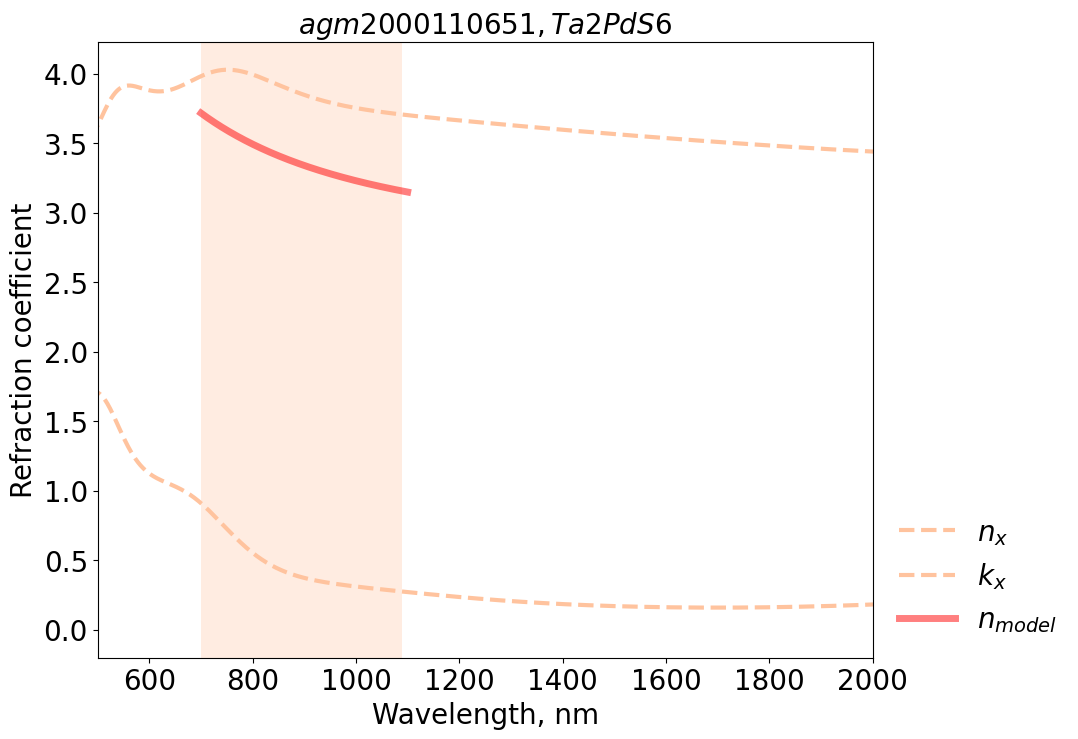

agm2000110680


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


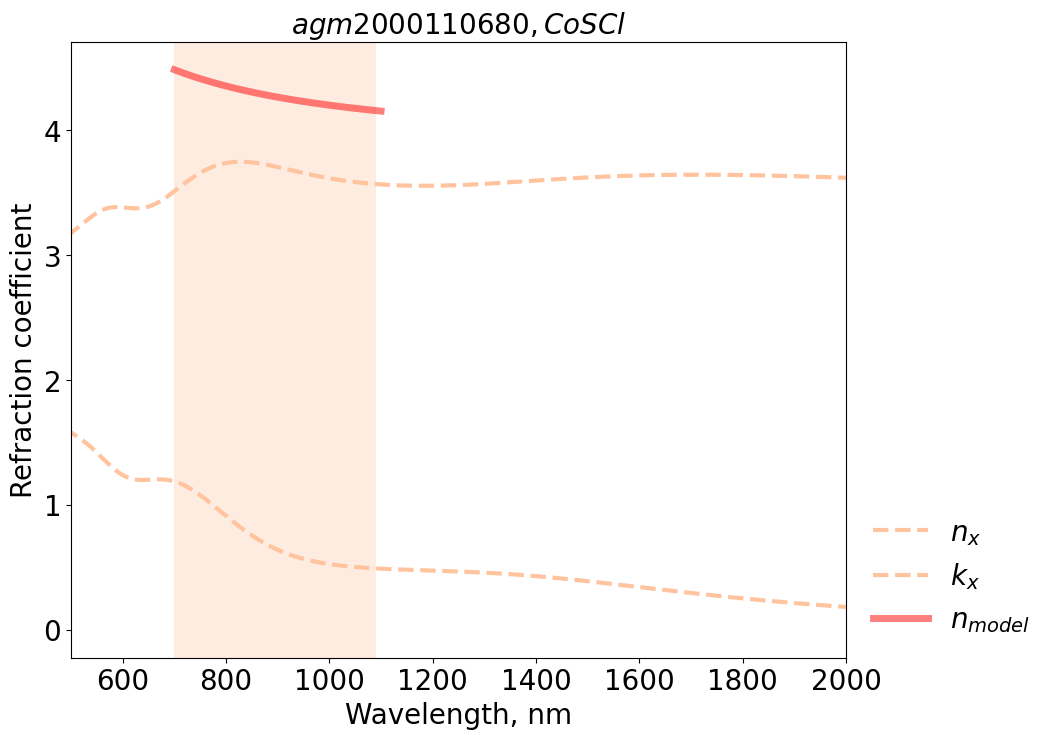

agm2000062172


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


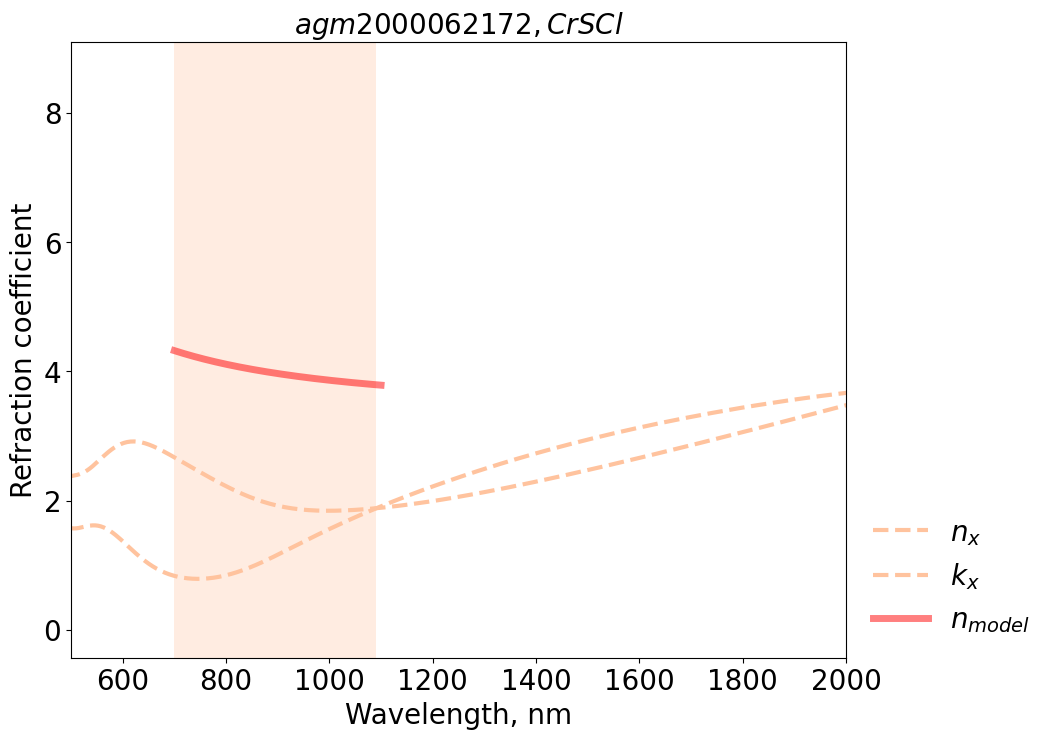

agm2000068504


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


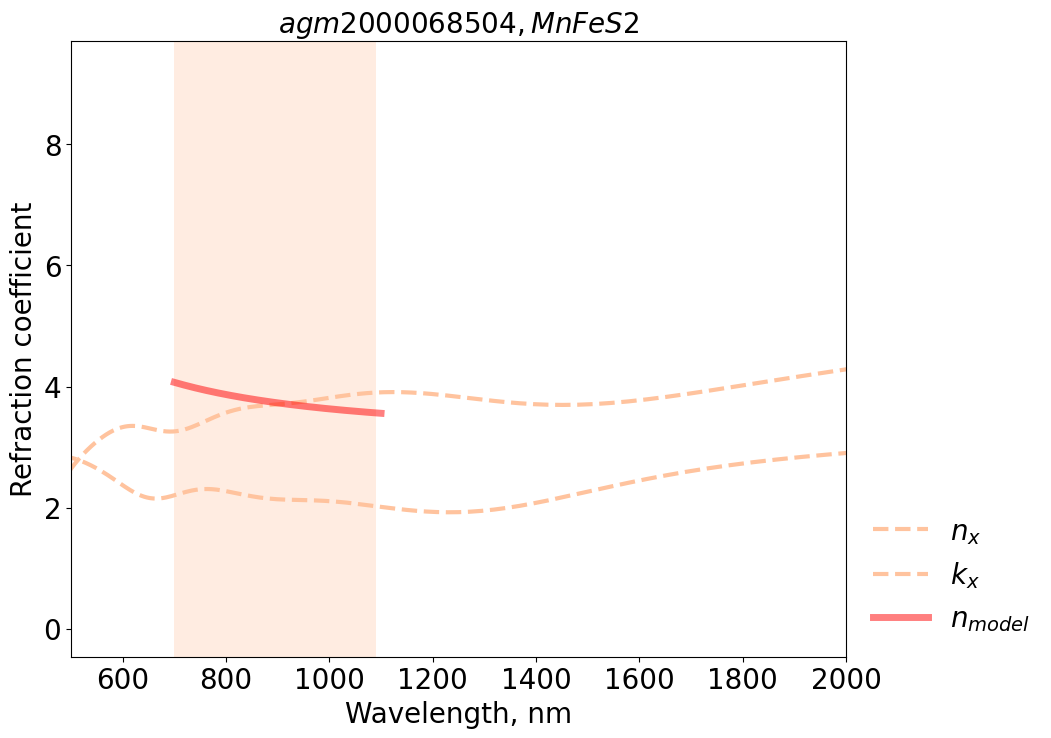

agm2000140821


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


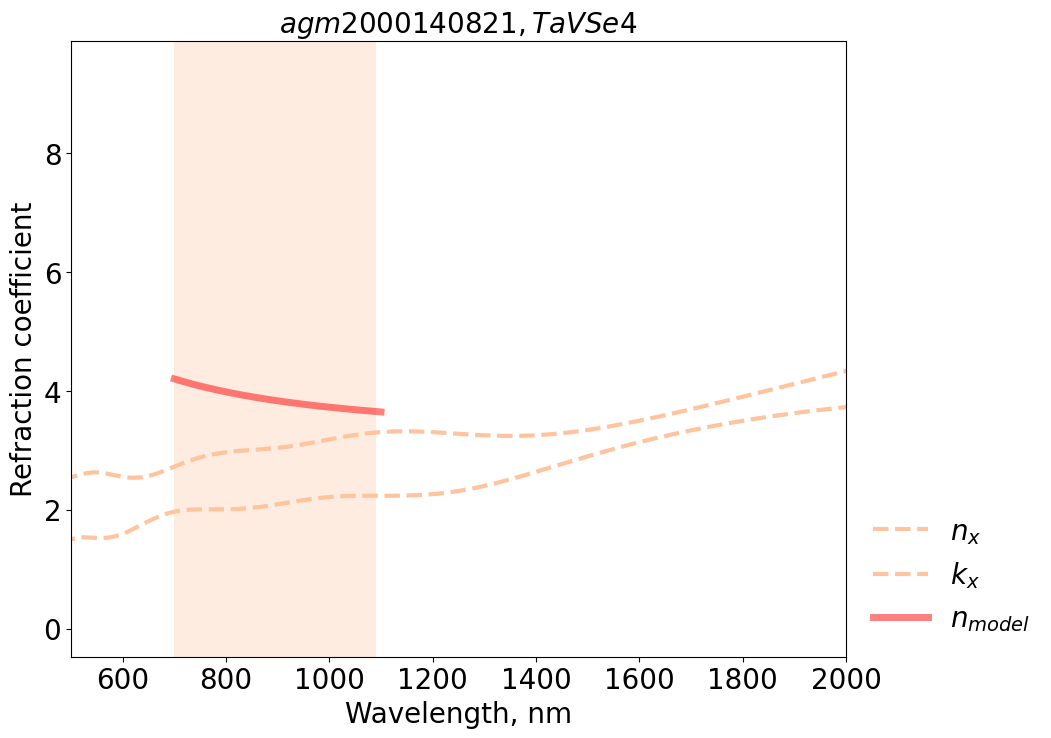

agm2000128966


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


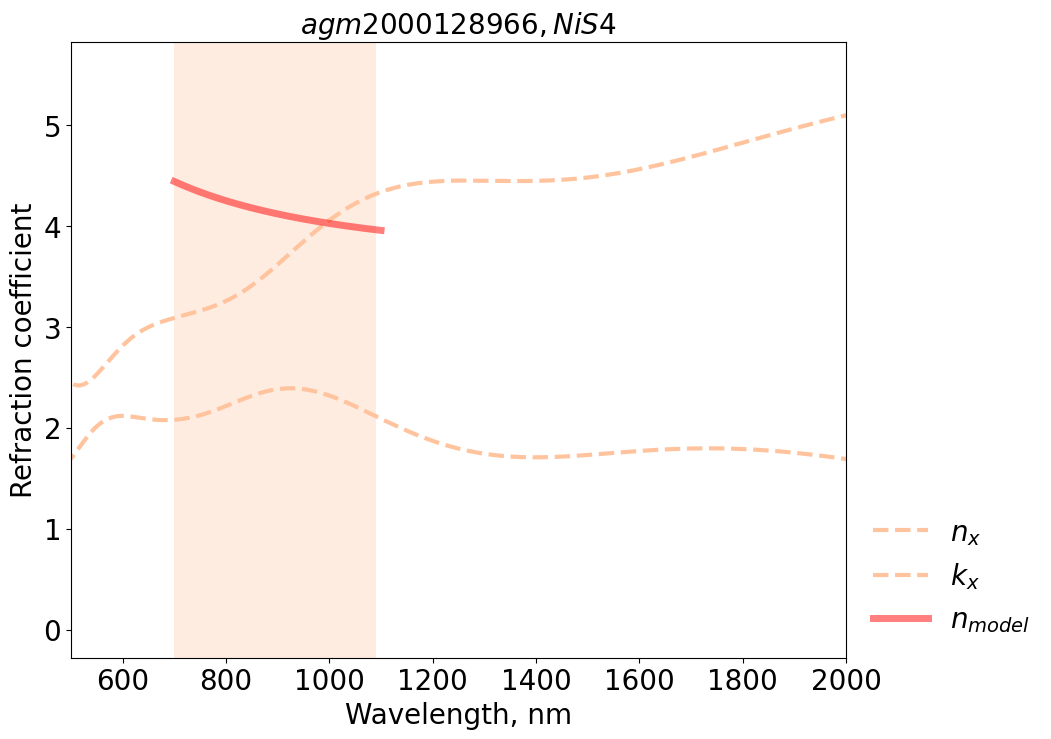

agm2000140560


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


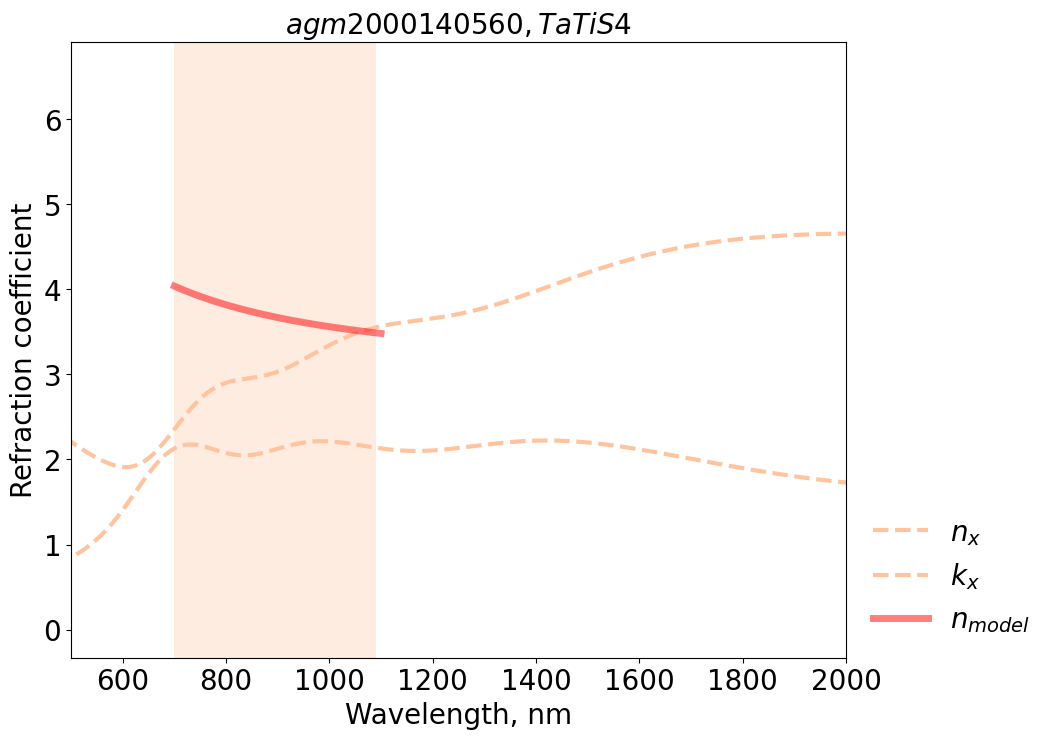

agm2000110697


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


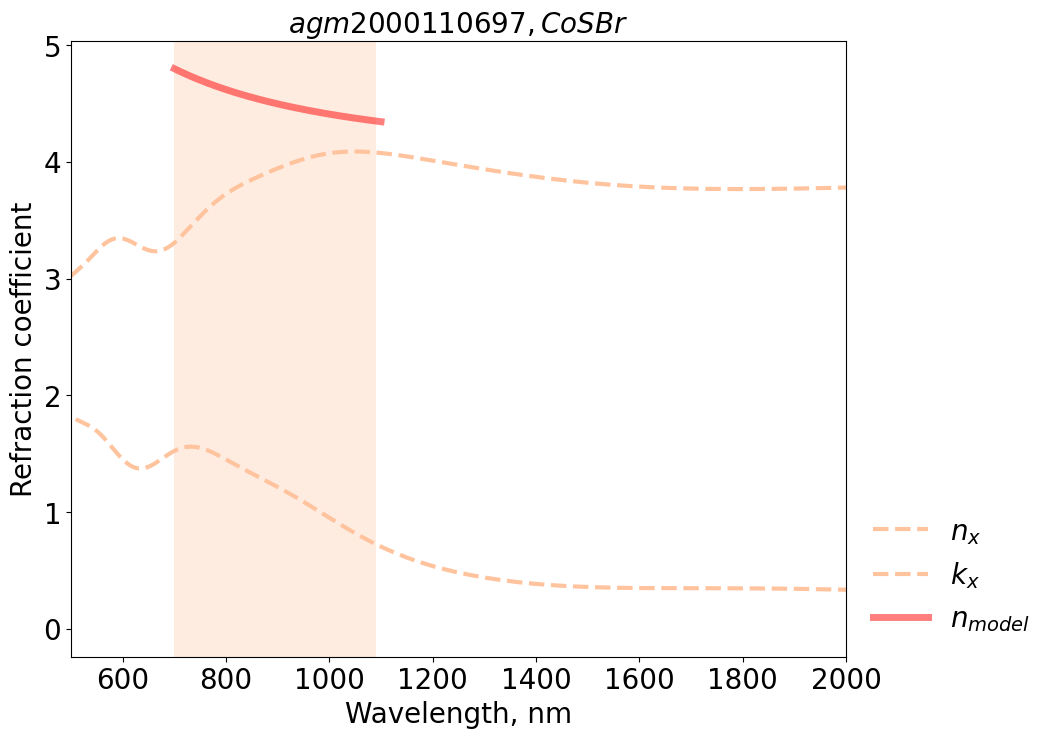

agm2000003006


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


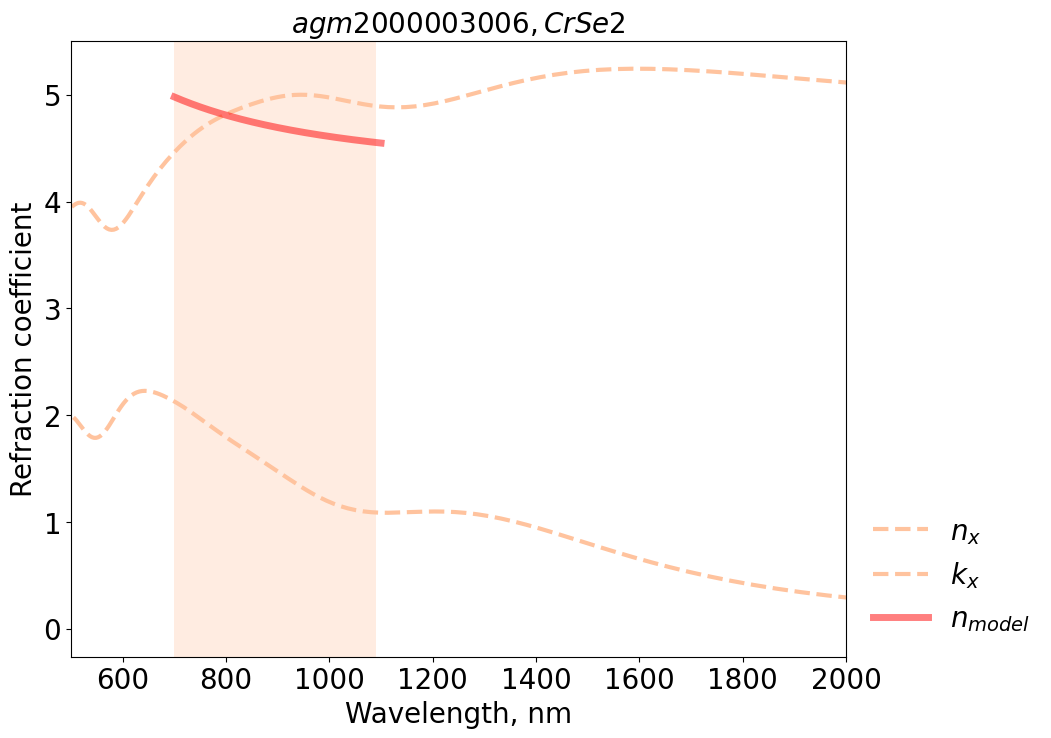

agm2000110643


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


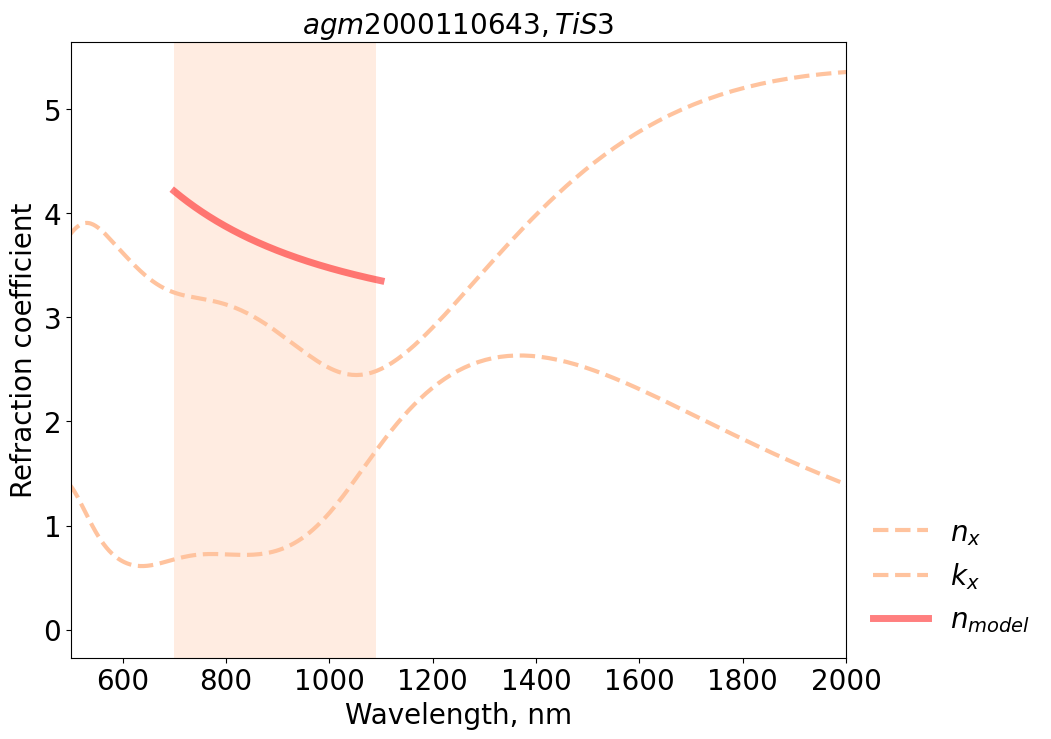

agm2000081362


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


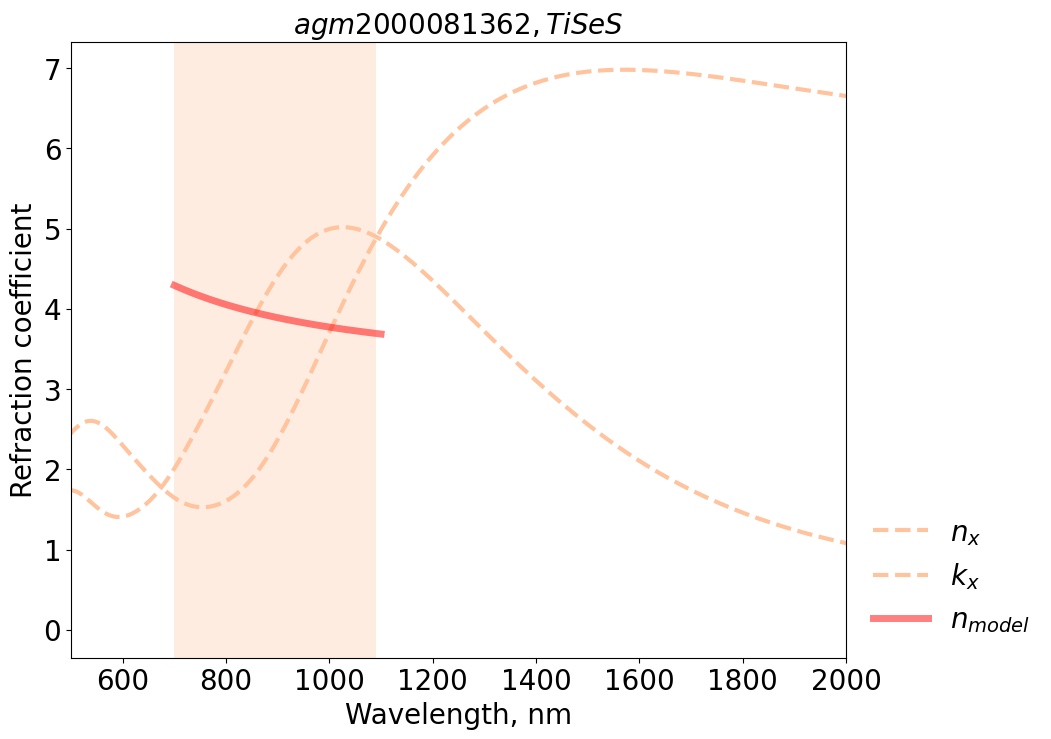

agm2000110638


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


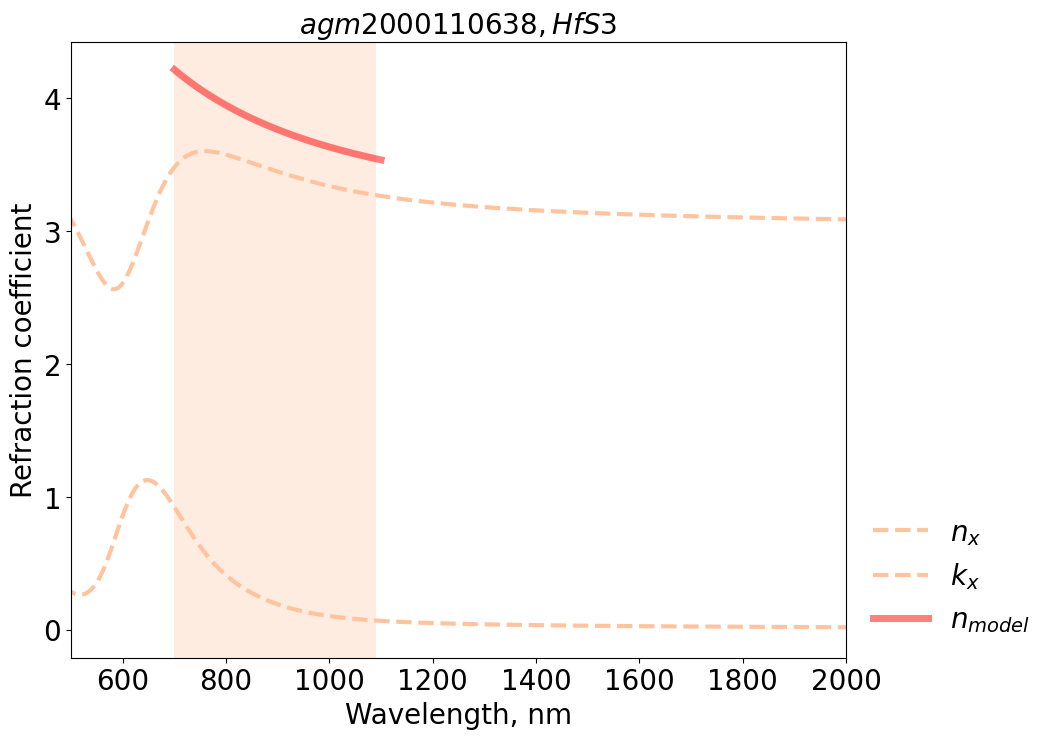

agm2000139177


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


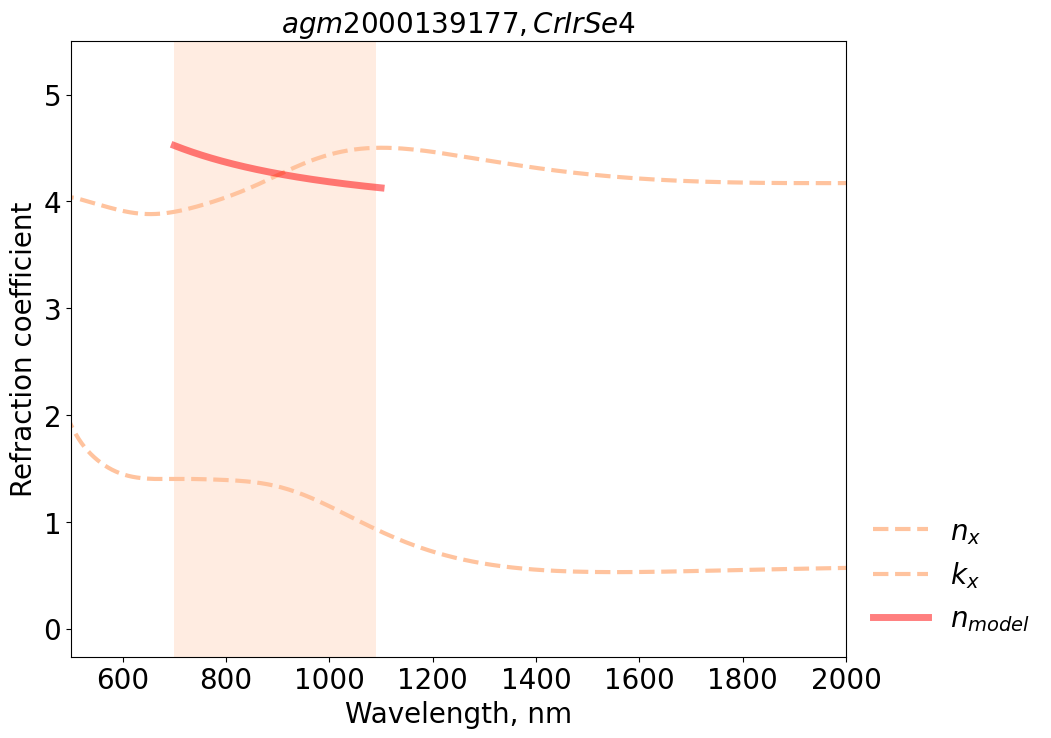

agm2000111289


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


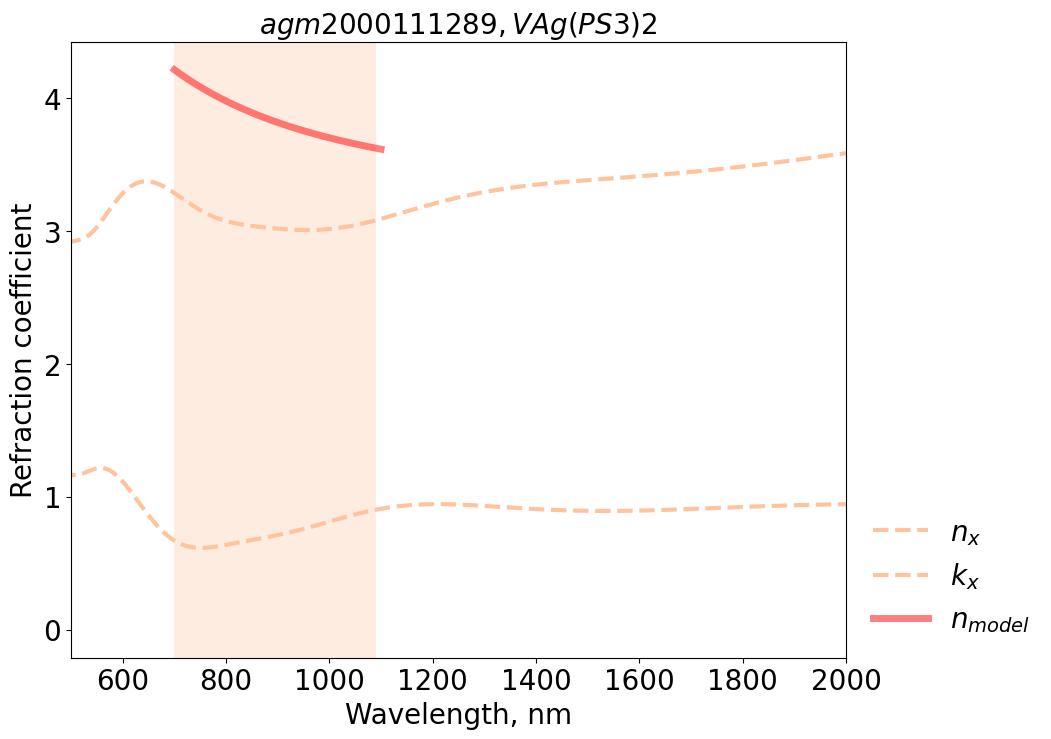

agm2000139113


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


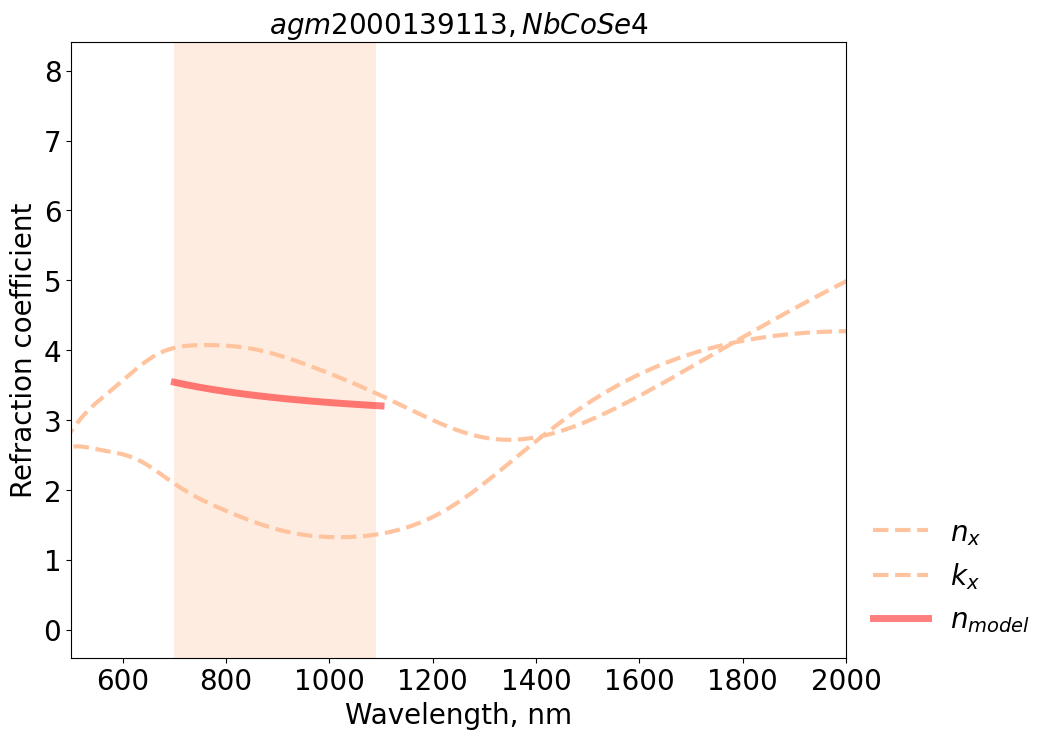

agm2000110686


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


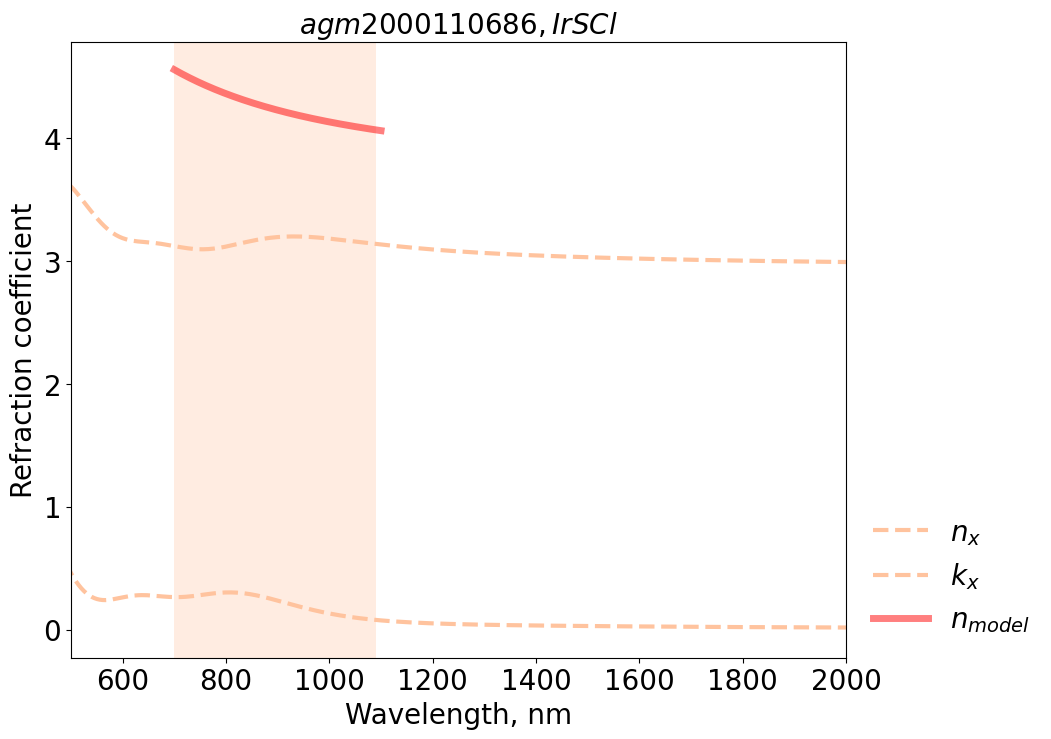

agm2000140703


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


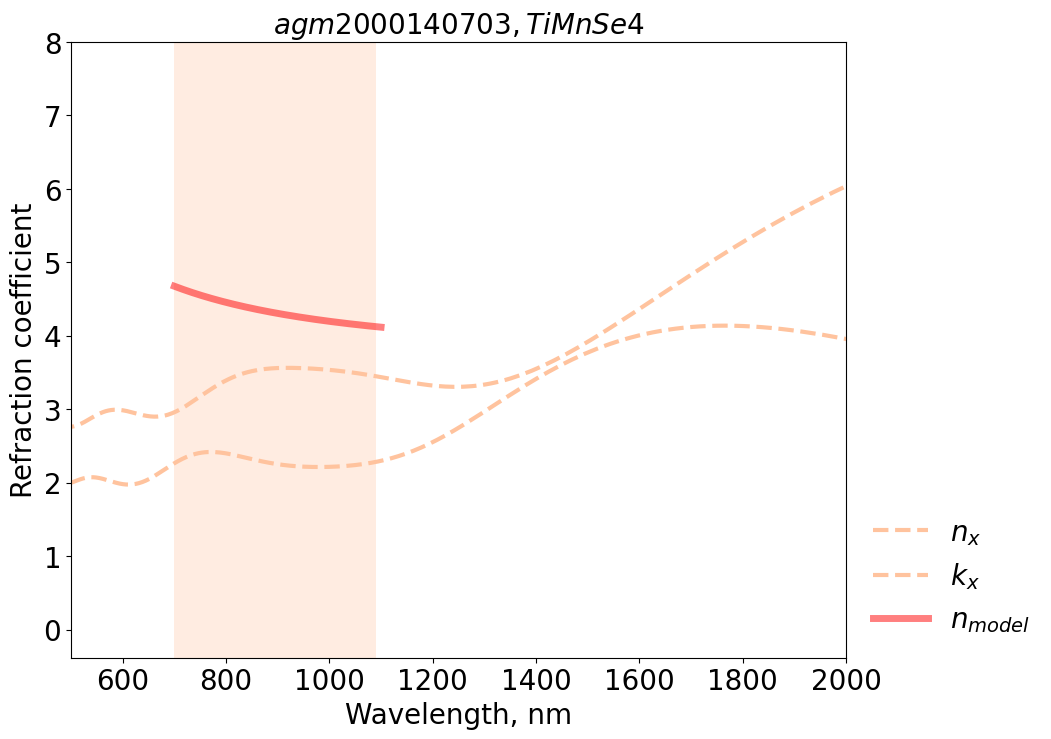

agm2000110687


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


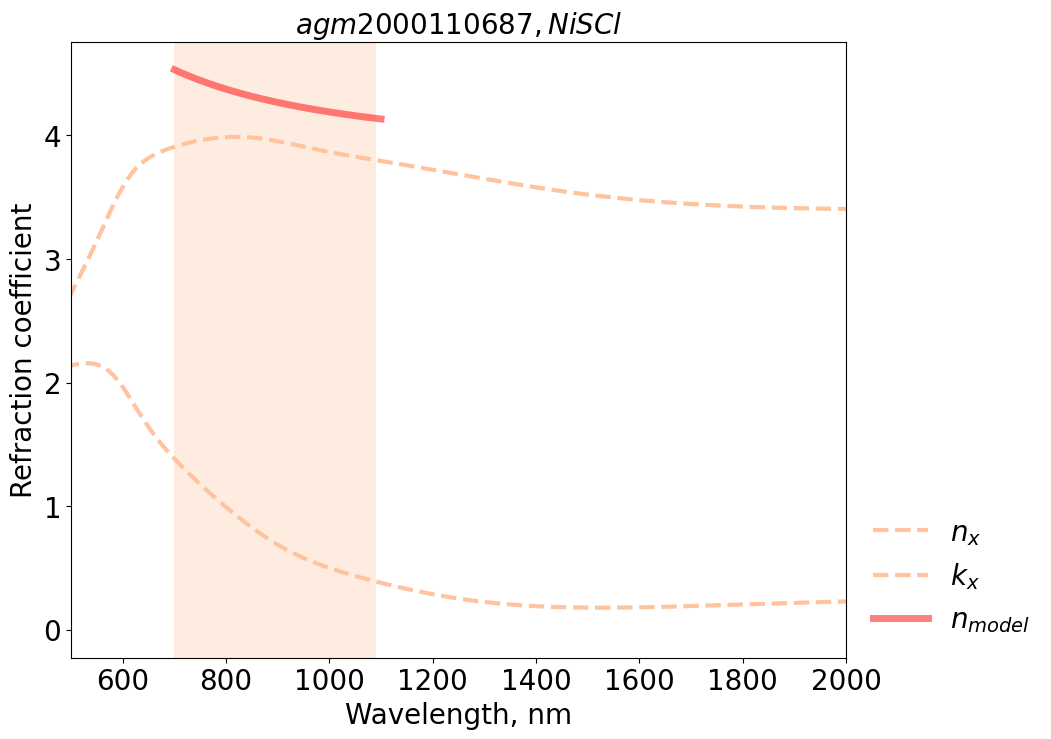

agm2000140503


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


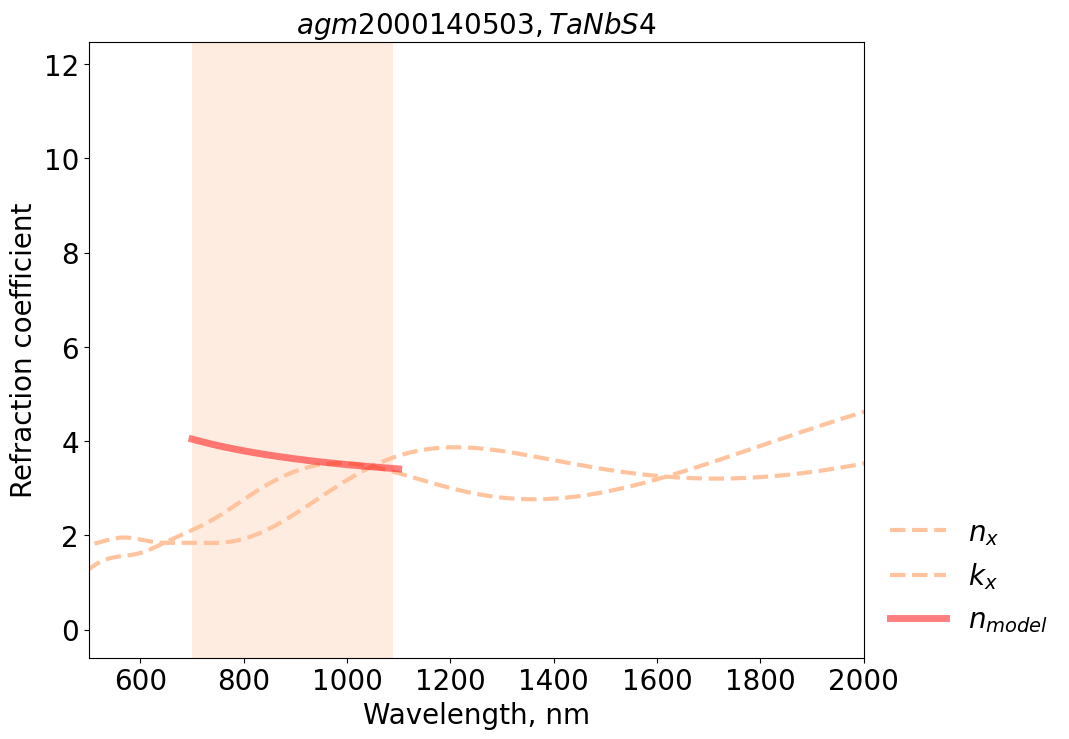

agm2000110702


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


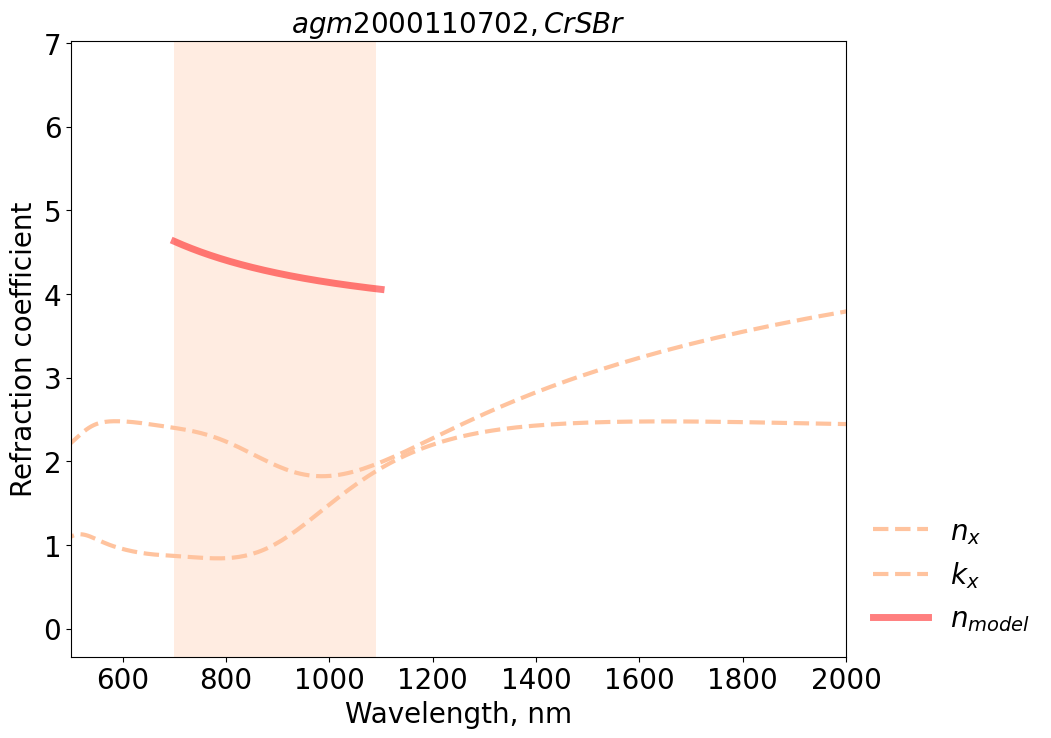

agm2000110668


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


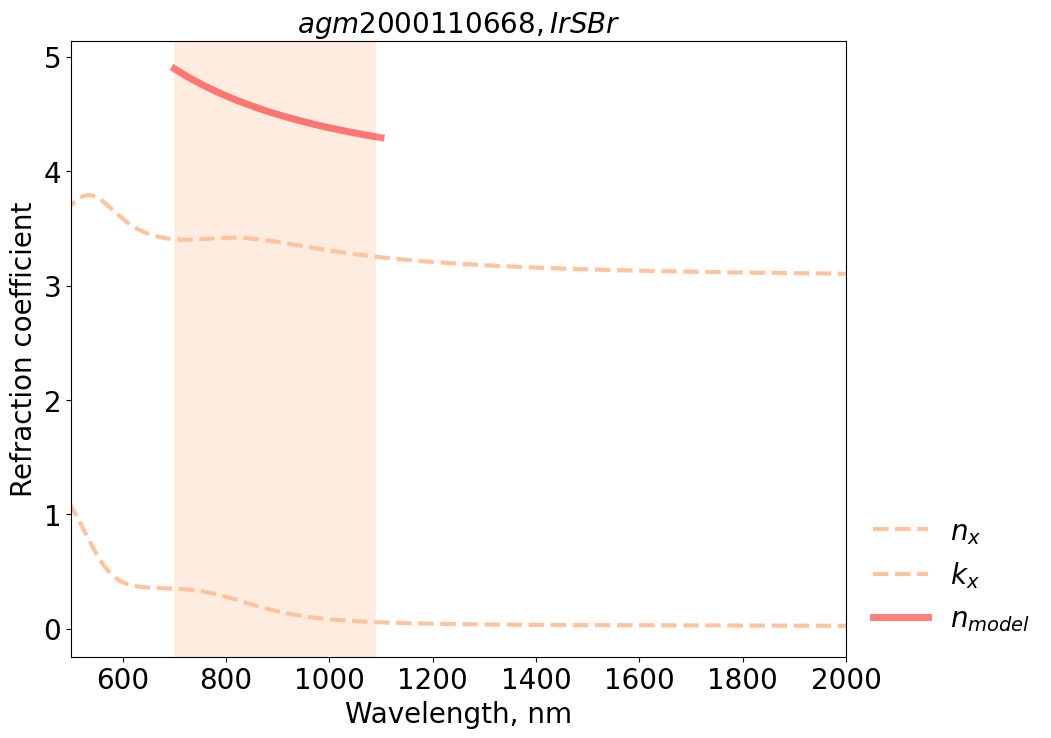

agm2000068502


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


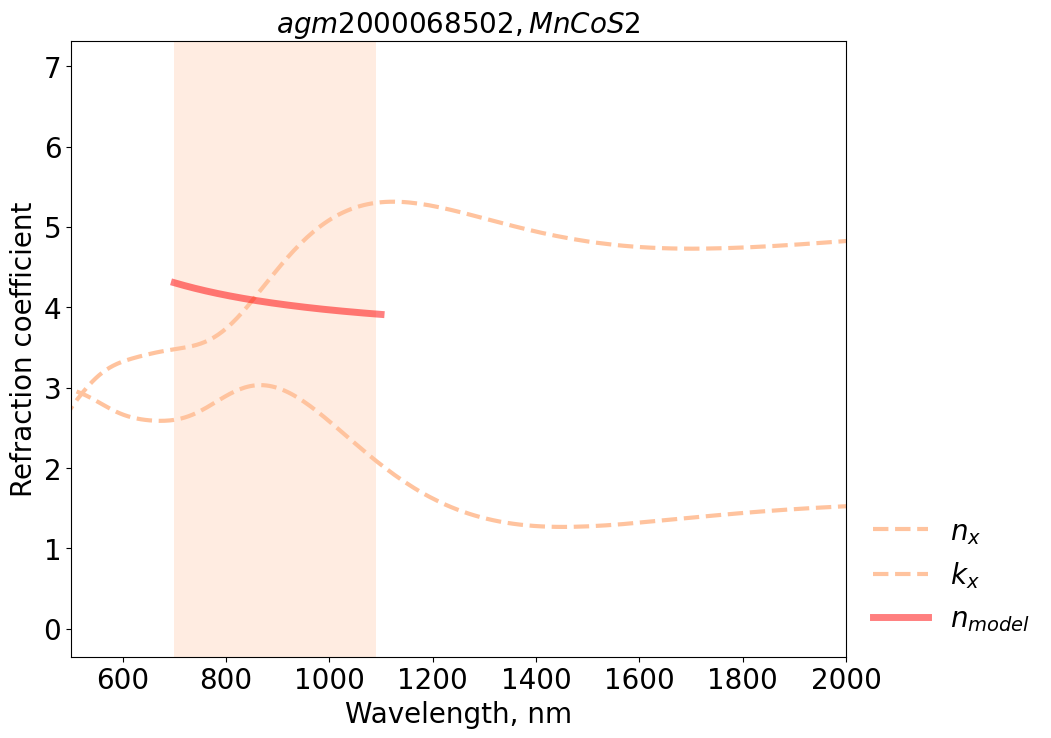

agm2000110644


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


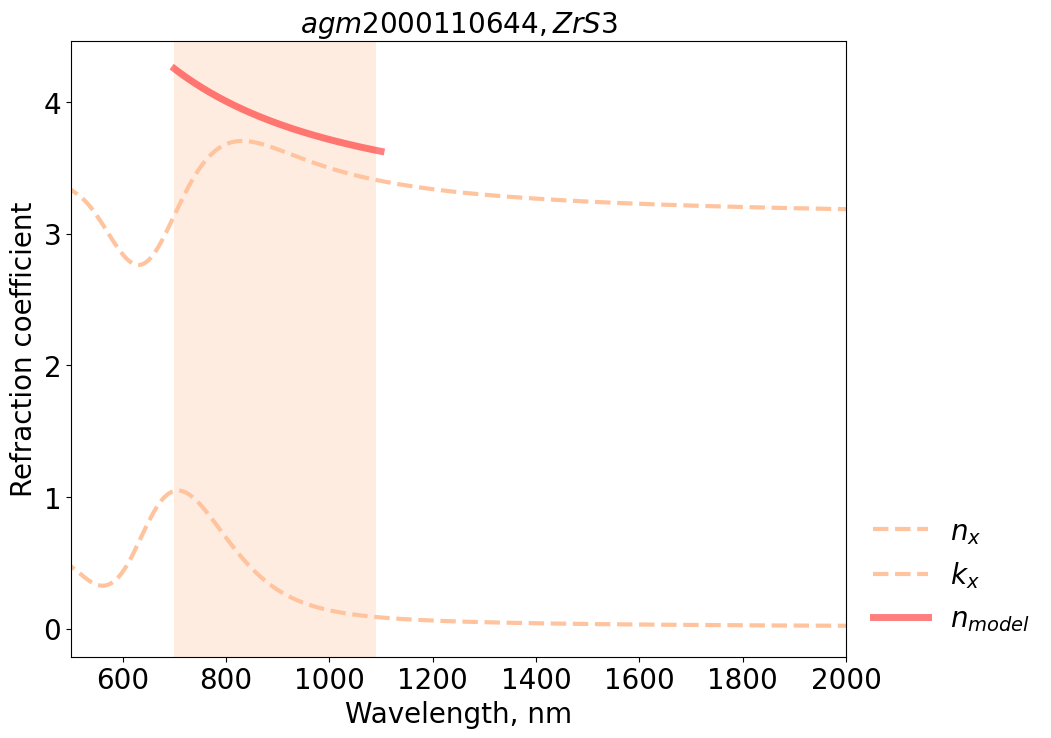

agm2000111203


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


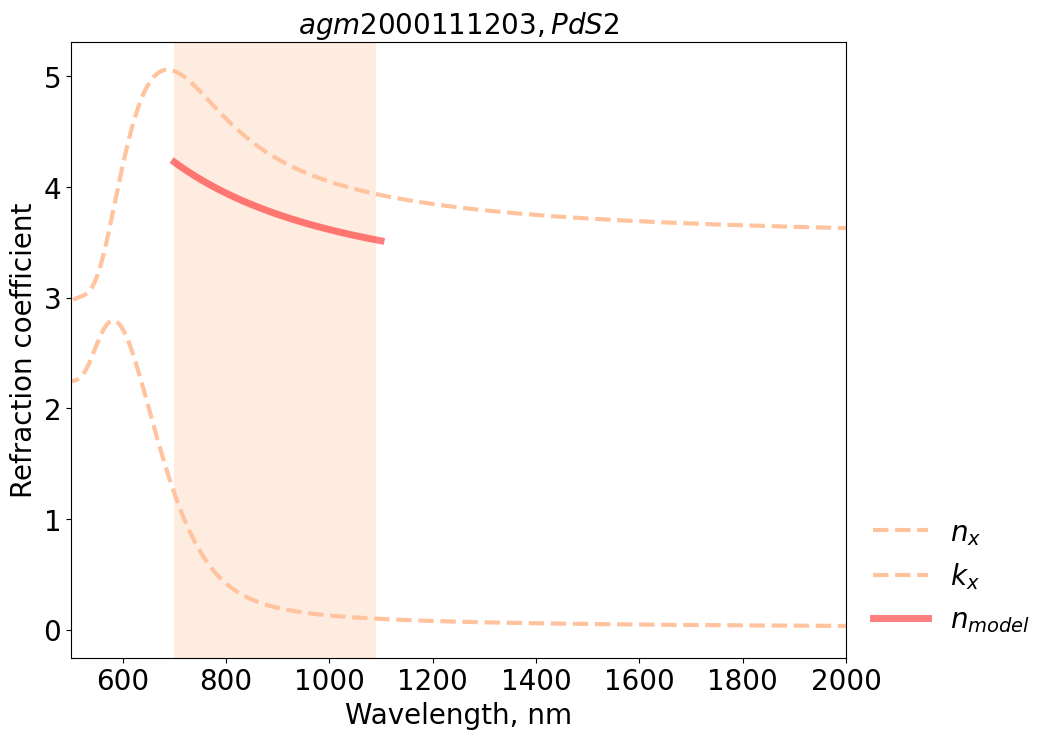

agm2000140718


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


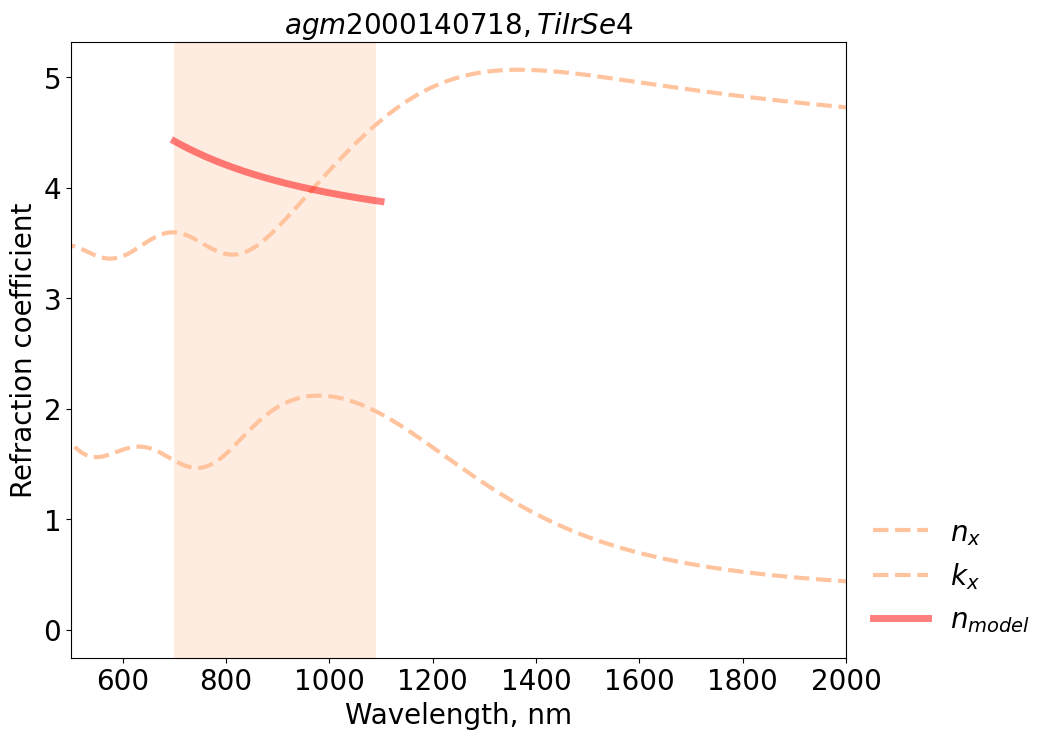

agm2000140200


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


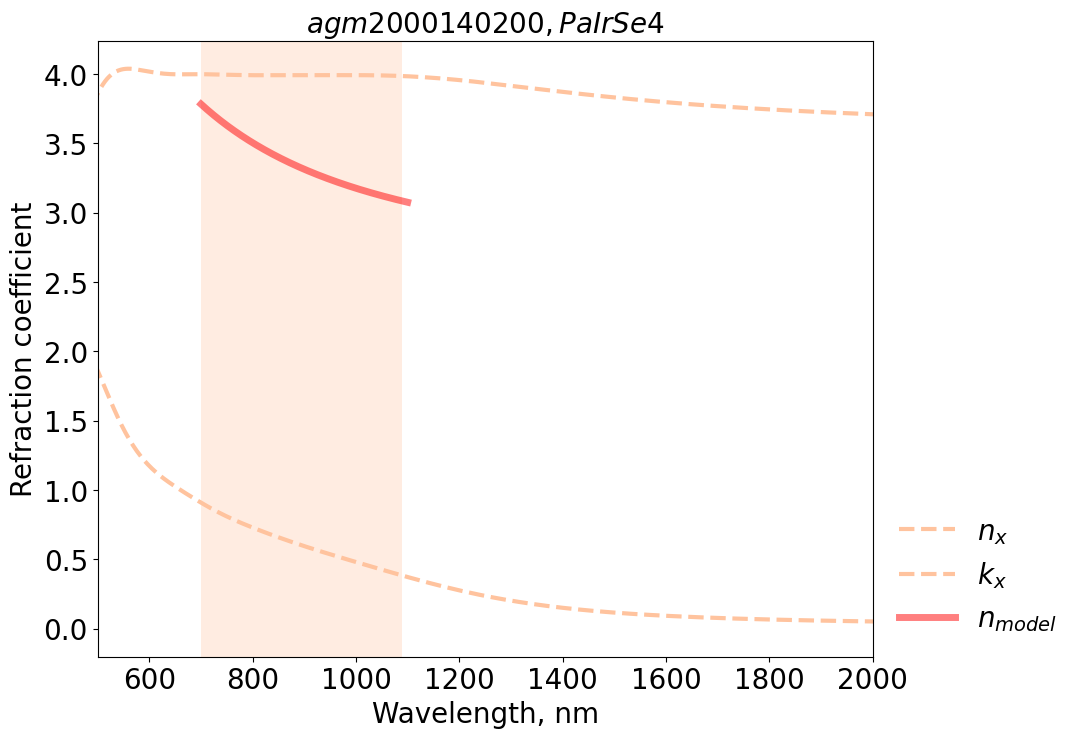

agm2000140593


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


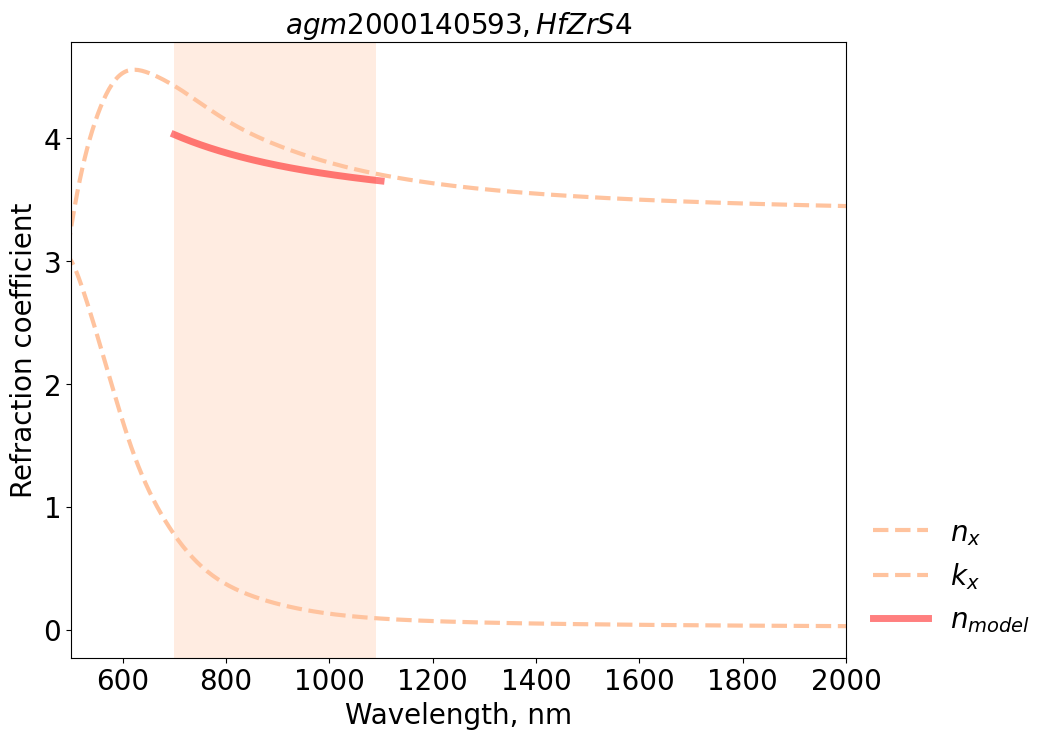

agm2000110603


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


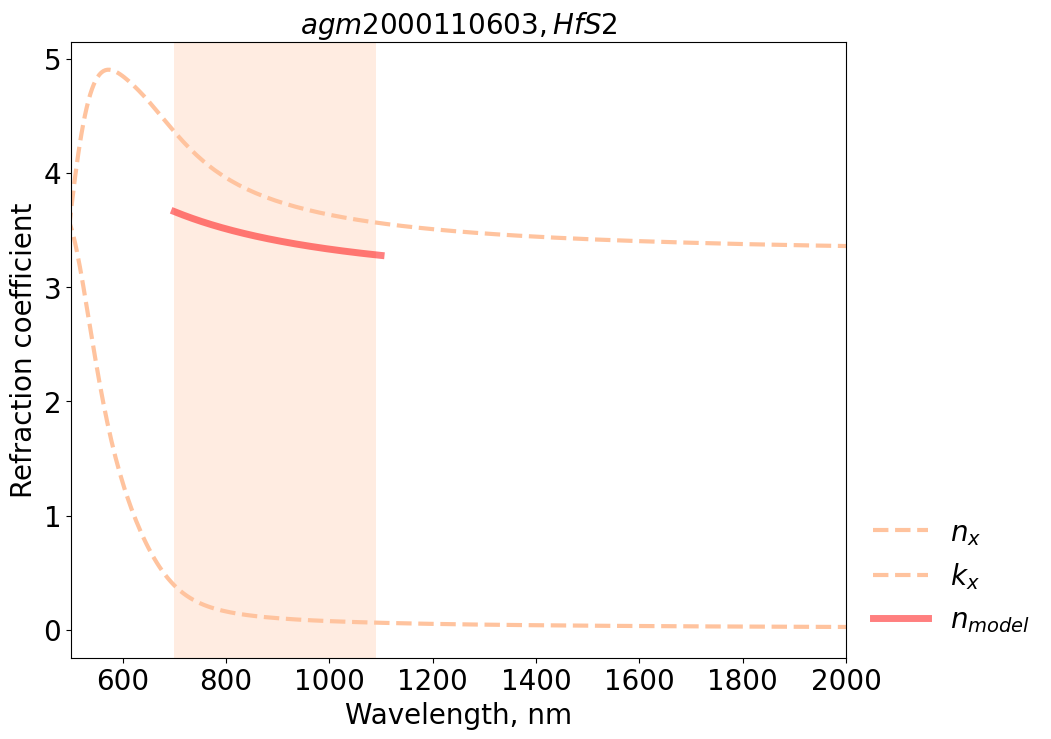

agm2000110486


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


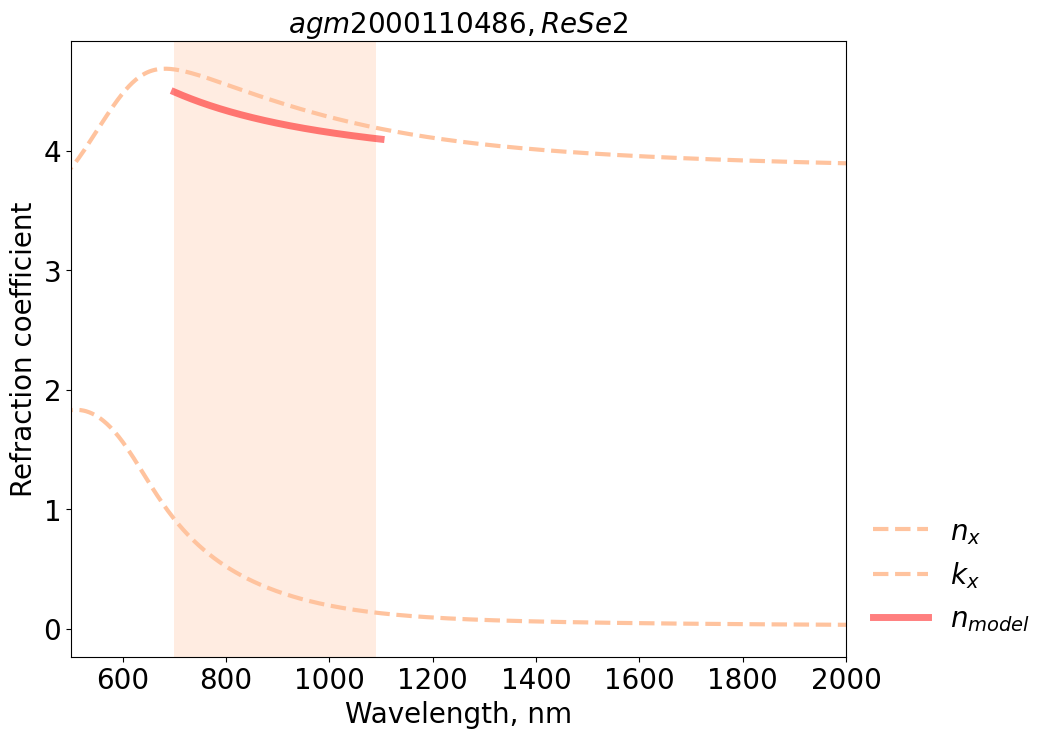

agm2000003612


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


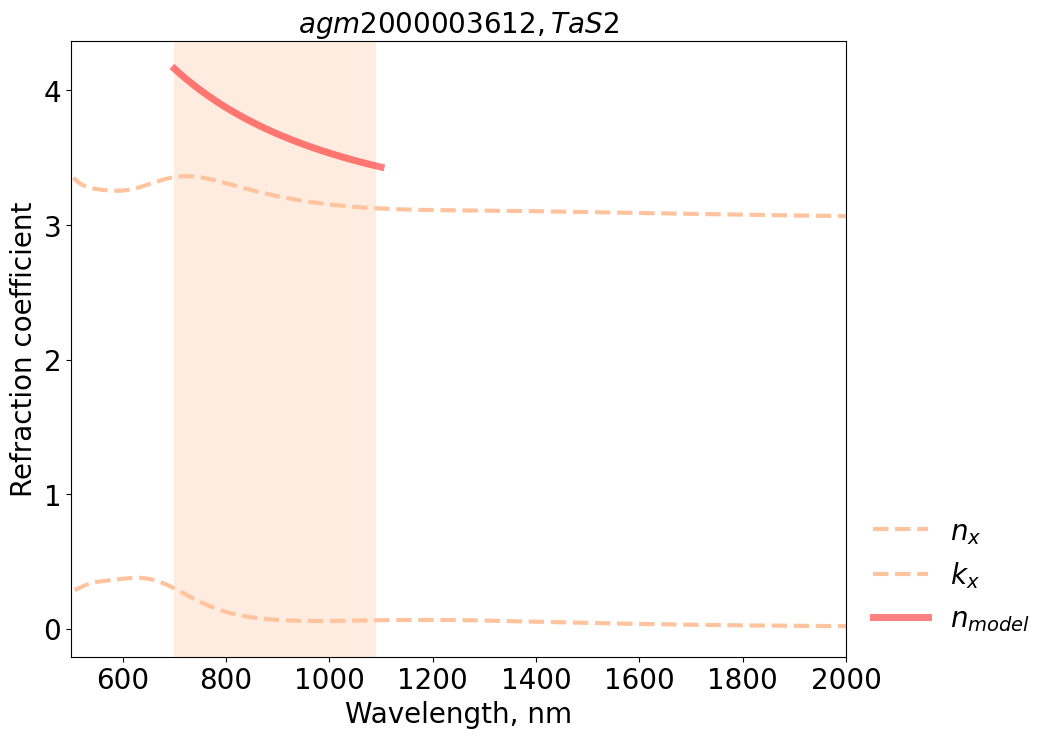

agm2000139291


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


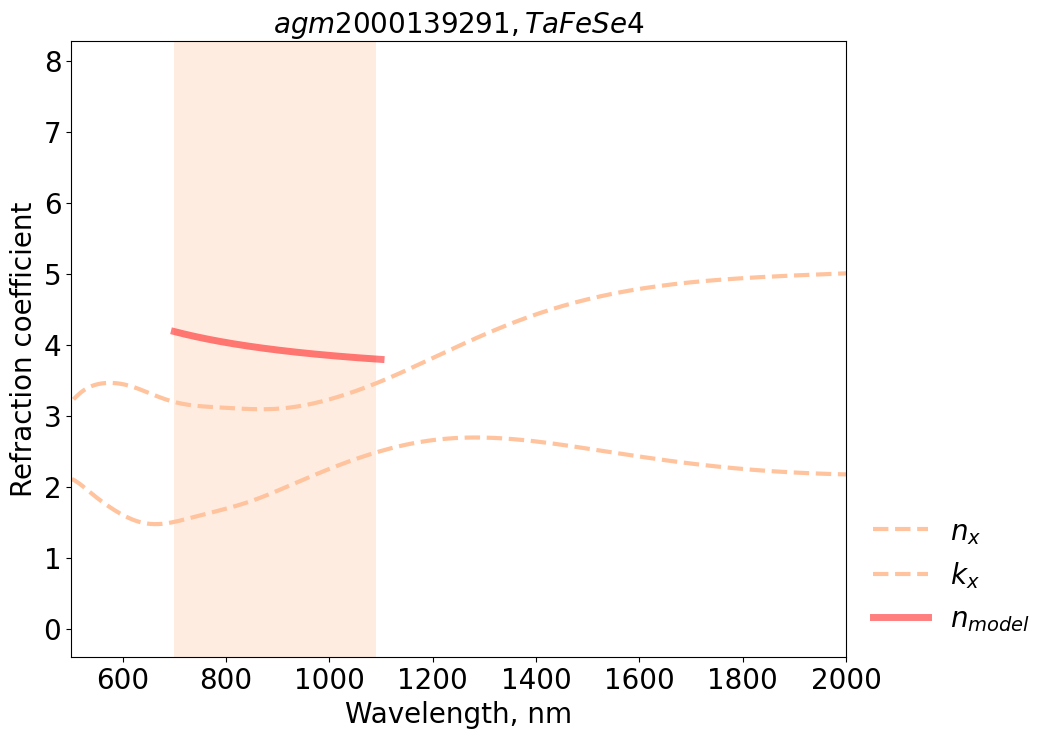

agm2000140220


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


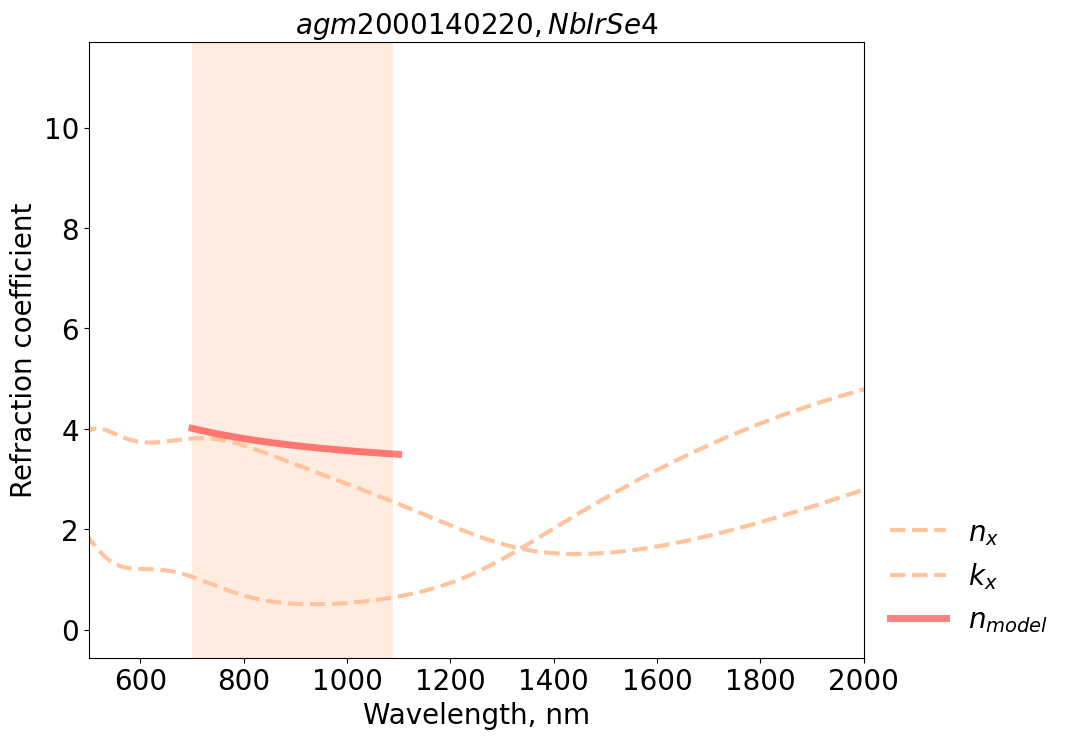

agm2000110690


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


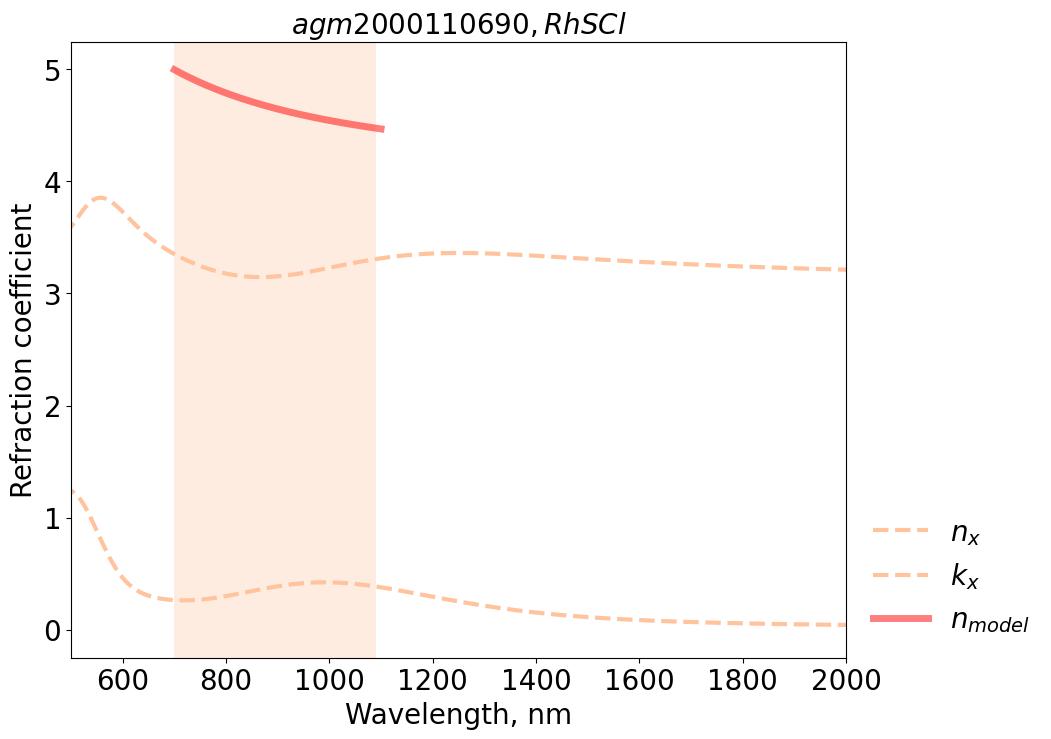

agm2000007658


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


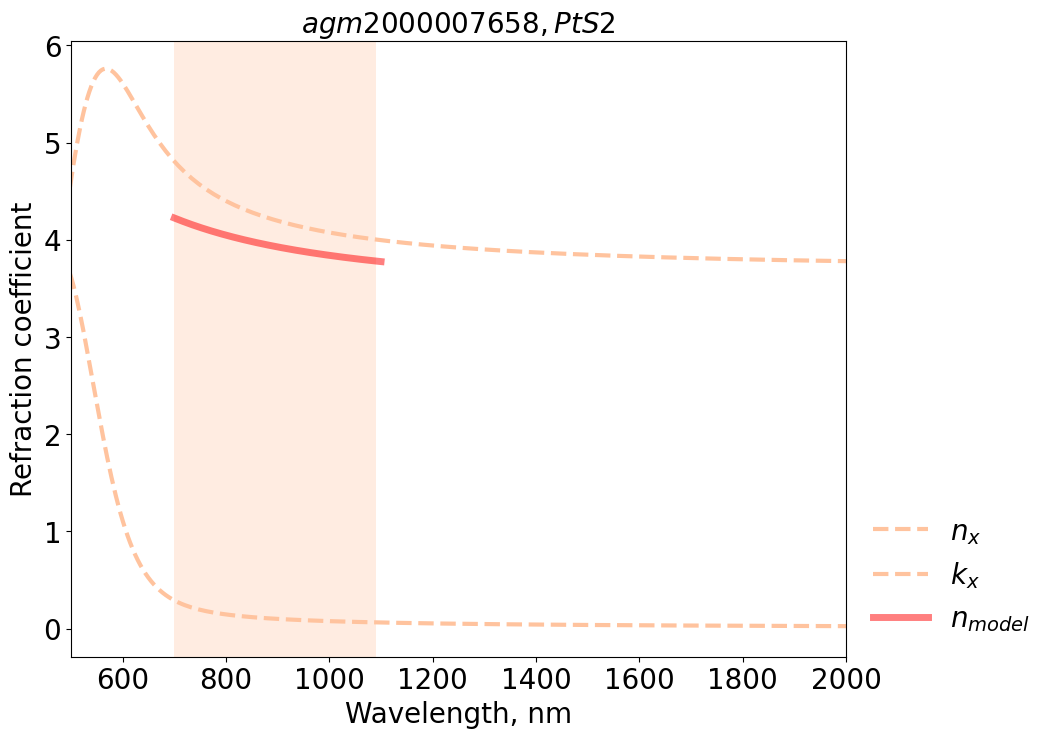

agm2000139122


/tmp/ipykernel_338752/3245496679.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linestyle='--', linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')


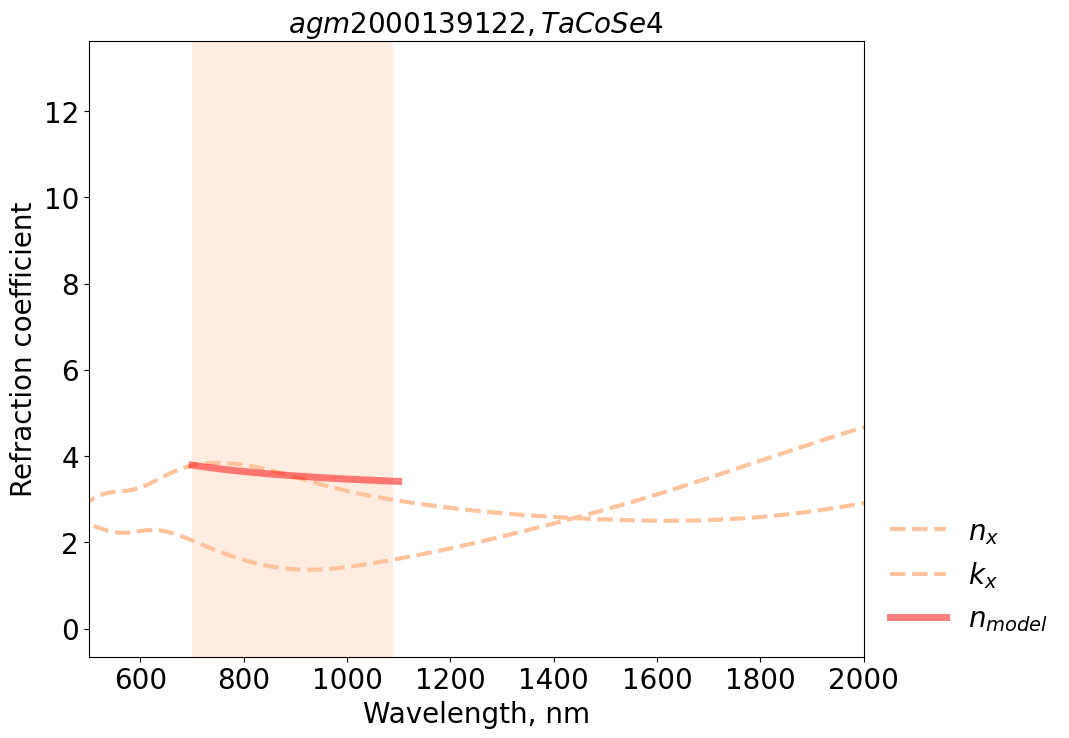

In [6]:
lst_dft = []
lst_dft_1 = []
lst_dft_2 = []
path = '/home/u7c/lusya/2D_materials/C2DB/alexandria/alex_fin/'

def n_wavelength(wavelength, A, B):
    return A + B / wavelength**2 + 1 / wavelength**4

# Given data
wavelength_range = np.linspace(700, 1100, 500)   

dataframes_dict = {}  # Create an empty dictionary to store dataframes
lst_dir = df_new['mat_id'].to_numpy()
for j, dir_name in enumerate(lst_dir):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    print(SYSTEM)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D =df_new['lattice_c'][j]
    THICKNESS_3D = df_new['thickness_2D'][j]
    FORMULA = df_new['formula'][j]
    A_values = df_new['Ax_final'][j] 
    B_values = df_new['Bx_final'][j] 
    n_values = n_wavelength(wavelength_range, A_values, B_values)
    
    vasprun_dft = path+f'{SYSTEM}/vasprun.xml'
    #try:
    analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    data = dft_data

    method = data.method

    plt.figure(figsize=(10, 8))

    line = '-'
    line_k = '--'
    colors = ['#8da0cb', '#2ca02c', '#d62728']
    col_exp = ['#4682B4', '#5CAD00', '#8B0000']
    plt.axvspan(700, 1090, facecolor='#FFC39E', alpha=0.3)
    plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, linewidth =3.0, color = '#FFC39E', label='$n_{{x}}$')
    #plt.plot(data.imag['Wavelength, nm'], data.imag['xx'], line_k, linewidth =3.0,  color = '#FFC39E', label='$k_{{x}}$')
    plt.plot(wavelength_range, n_values, alpha=0.5, linewidth =5.0,  color='red', label='$n_{{model}}$')
    plt.xlim(0, 3000)
    #plt.ylim(0, 4)

    plt.xlabel('Wavelength, nm', fontsize=20)
    plt.ylabel('Refraction coefficient', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc=(1.02, 0.02), edgecolor='white', fontsize=20)
    delta_n_value = data.real[data.real['Wavelength, nm'].between(1050, 1075)].iloc[0]
    lst_dft.append(delta_n_value['xx'])
    #plt.title('$Ta_{{2}}NiSe_{{5}}$', fontsize=20)
    #plt.title('$MoTe_{{2}}$', fontsize=20)
    plt.title(f'${SYSTEM}, {FORMULA}$', fontsize=20)
    #plt.axvline(x=1064, color='grey', linestyle='--', label=f'x = 1064 nm')

    plt.savefig(f'/home/u7c/lusya/2D_materials/C2DB/alexandria/spectrum_png/{SYSTEM}_dn_dk.png', dpi=100, facecolor='w', bbox_inches='tight')
    plt.xlim(500,2000)
    plt.show()
    #df = data.real[data.real['Wavelength, nm'].between(0, 2000)]

In [22]:
df_new['n_x_1064']=lst_dft

In [13]:
df_all = pd.read_csv('/home/u7c/lusya/2D_materials/C2DB/alexandria/90_test_monolayers_optics.csv', skipinitialspace=True)

In [14]:
df_all.head()

formula         mat_id  Ax_final       Bx_final  e_above_hull  thickness_2D  \
0    TiS2  agm2000009024  3.160602  513647.670177      0.001907      6.449052   
1  MnCoS2  agm2000068502  3.643038  324416.650703      0.005135      6.046357   
2    NiS2  agm2000111201  4.055559  357053.327207      0.008442      4.752785   
3    CrS2  agm2000110598  4.256682  163923.334730      0.001234      6.543227   
4   CrSe2  agm2000003006  4.253658  355291.667496      0.000766      6.949307   

   n_x_1064  
0  5.746876  
1  5.282105  
2  4.954165  
3  4.940435  
4  4.911412

In [28]:
df_all[['formula', 'mat_id', 'Ax_final', 'Bx_final', 'e_above_hull', 'thickness_2D', 'n_x_1064']].to_csv('/home/u7c/lusya/2D_materials/C2DB/alexandria/90_test_monolayers_optics.csv', index=False)

In [6]:
df_test = pd.read_csv('/home/u7c/lusya/2D_materials/C2DB/alexandria/90_test_monolayers_optics.csv', skipinitialspace=True)

In [7]:
df_train = pd.read_csv('c2db_2elems_finished/c2db_optics_1064nm.csv', skipinitialspace=True)

In [8]:
df_train.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064  
0  3.403833  3.379757  2.574261  3.435819  3.413529  
1  3.554303  4.264792  2.757543  3.438509  4.327317  
2  2.774818  2.970205  2.733178  2.875894  3.118526  
3  3.772258  3.567112  2.629559  3.491887  3.553724  
4  2.982871  2.974833  2.256140  2.807209  3.034398

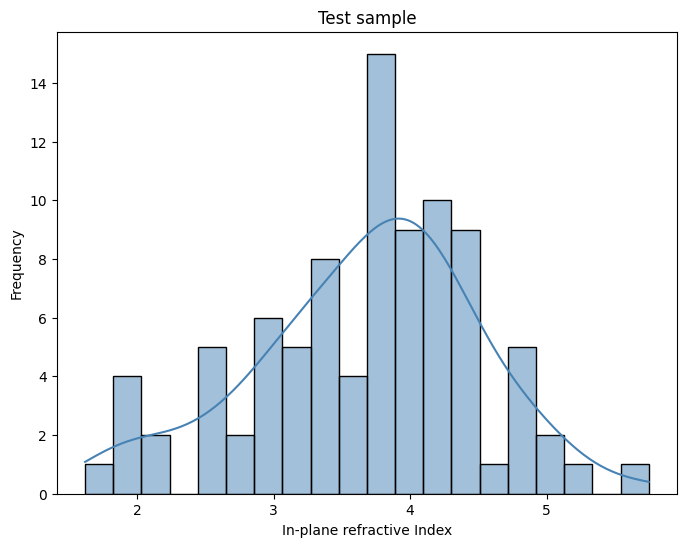

In [16]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df_test['n_x_1064'], bins=20, kde=True, color='steelblue')
plt.xlabel('In-plane refractive Index')
plt.ylabel('Frequency')
plt.title('Test sample')
plt.show()

In [6]:
df_new = df_new.drop(columns=['dn_xy', 'dn_xz', 'dn_yz', 'n_z', 'n_x', 'n_y'])

In [7]:
#d = {'dir_names': ['WS2', 'WSe2'], 'THICKNESS_2D': [8.0, 8.0], 'lattice_c': [12.3, 12.295]}
#df_new = pd.DataFrame(data=d)

In [8]:
df_new.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction  
0   c2db_AB4_2PdS4_2               z  
1   c2db_AB4_2PdS4_1               z  
2   c2db_AB4_3OsS4_1               z  
3  c2db_AB4_1AlSe4_1               z  
4   c2db_AB4_1AlS4_1               z

In [50]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

In [5]:
%cd c2db_2elems_finished/

/home/u7c/lusya/2D_materials/C2DB/c2db_2elems_finished


/home/u7c/miniconda3/envs/version/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
d = {'dir_names': ['WS2','WSe2'], 'THICKNESS_2D': [5.75, 6.05], 'lattice_c': [12.3, 12.295]}
df_new = pd.DataFrame(data=d)

In [5]:
d = {'dir_names': ['WSe2'], 'THICKNESS_2D': [6.05], 'lattice_c': [12.295]}
df_new = pd.DataFrame(data=d)

In [7]:
print(df_new['dir_names'].to_numpy())

['WS2' 'WSe2']


In [51]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

In [53]:
#lst_dft = []
lst_dft_1 = []
lst_dft_2 = []

lst_dir = df_new['dir_names'].to_numpy()
dataframes_dict = {}  # Create an empty dictionary to store dataframes

for j, dir_name in enumerate(lst_dir):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = df_new['lattice_c'][j]
    THICKNESS_3D = df_new['THICKNESS_2D'][j]
    vasprun_dft = f'/home/u7c/lusya/2D_materials/C2DB/{SYSTEM}/vasprun.xml'
    try:
        analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
        dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])

        data = dft_data
        method = data.method
        df = data.real[data.real['Wavelength, nm']].between(775, 790)
        #print(df)
        #print(np.abs(df['xx']))
        lst_dft.append(np.abs(df['xx']))
        lst_dft_1.append(np.abs(df['yy']))
        lst_dft_2.append(np.abs(df['zz']))
    except DataParsingError:
        lst_dft.append(-1)
        lst_dft_1.append(-1)
        lst_dft_2.append(-1)
    except FileNotFoundError:
        lst_dft.append(-2)
        lst_dft_1.append(-2)
        lst_dft_2.append(-2)

In [19]:
df_new['kz_830']=lst_dft_2
df_new['kx_830']=lst_dft
df_new['ky_830']=lst_dft_1

In [20]:
df_new.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064    nz_755    nx_755  \
0  3.403833  3.379757  2.574261  3.435819  3.413529  2.703144  3.559991   
1  3.554303  4.264792  2.757543  3.438509  4.327317  2.892107  3.632623   
2  2.774818  2.970205  2.733178  2.875894  3.118526  2.526368  2.599827   
3  3.772258  3.567112  2.629559  3.491887  3.553724  2.643992  3.835528   
4  2.982871  2.974833  2.256140  2.807209  3.034398  2.279759  3.823235   

     ny_755    nz_808    nx_808    ny_808    nz_785    nx_785    ny_785  \
0  3.531993  2.673255  3.503081  3.476003  2.686778  3.536575  3.508975   
1  3.997857  2.866054  3.702381  4.108268  2.877997  3.679736  4.081218   
2  2.749112  2.588455  2.650934  2.795456  2.564391  2.631069  2.777052   
3  3.568295  2.654092  3.952319  3.591232  2.646542  3.906373  3.594239   
4  2.986197  2.314210  3.577047  3.023746  2.305408  3.685950  3.023436   

        A_x           B_x  C_x       A_y            B_y  C_y       A_z  \
0  3.262034  1.611007e+05  1.0  3.245148  154562.154552  1.0  2.440335   
1  3.264960  2.564033e+05  1.0  4.643526 -357176.526221  1.0  2.621372   
2  3.116786 -3.015127e+05  1.0  3.437869 -410552.745551  1.0  2.959752   
3  3.264554  4.034569e+05  1.0  3.532867   31386.004500  1.0  2.652494   
4  1.748993  1.189536e+06  1.0  3.017293   -6035.749831  1.0  2.230419   

             B_z  C_z    kz_755    kx_755    ky_755    kz_785    kx_785  \
0  151170.825573  1.0  0.166514  0.769665  0.771300  0.139424  0.659263   
1  157687.620959  1.0  0.147642  0.900601  1.625390  0.124108  0.787416   
2 -243640.835447  1.0  0.606209  0.925684  1.149580  0.585294  0.929971   
3    -402.881251  1.0  0.438901  1.781804  1.295486  0.430809  1.702726   
4   44369.086985  1.0  0.363129  0.977945  0.948586  0.336083  0.810232   

     ky_785    kz_808    kx_808    ky_808    kz_980    kx_980    ky_980  \
0  0.661092  0.122899  0.600661  0.602678  0.069232  0.513622  0.515974   
1  1.454887  0.106812  0.690122  1.343097  0.042458  0.230537  0.960751   
2  1.144772  0.571304  0.931699  1.145648  0.429411  0.963373  1.199740   
3  1.186887  0.424133  1.622721  1.117784  0.323606  1.191486  0.969091   
4  0.875581  0.313481  0.731238  0.826836  0.2334

In [23]:
lst_dft = []
lst_dft_1 = []
lst_dft_2 = []

lst_dir = df_new['dir_names'].to_numpy()
dataframes_dict = {}  # Create an empty dictionary to store dataframes

for j, dir_name in enumerate(lst_dir):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = df_new['lattice_c'][j]
    THICKNESS_3D = df_new['THICKNESS_2D'][j]
    vasprun_dft = f'/home/u7c/lusya/2D_materials/C2DB/c2db_2elems_finished/{SYSTEM}/vasprun.xml'
    try:
        analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
        dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        data = dft_data
        method = data.method
        df = data.imag[data.imag['Wavelength, nm'].between(1050, 1070).iloc[0]
        print(np.abs(df['zz']))
        lst_dft.append(np.abs(df['xx']))
        lst_dft_1.append(np.abs(df['yy']))
        lst_dft_2.append(np.abs(df['zz']))
    except DataParsingError:
        lst_dft.append(-1)
        lst_dft_1.append(-1)
        lst_dft_2.append(-1)
    except FileNotFoundError:
        lst_dft.append(-2)
        lst_dft_1.append(-2)
        lst_dft_2.append(-2)

0.059343059898118465
0.031774591440351316
0.35161316194793646
0.2918047146393143
0.23142216421483316
0.11014641710910168
0.025476589405255236
0.21069766050694444
0.08599664626259507
0.27773763722228695
0.27382601533848133
0.33992534093722676
0.007682528103228778
0.013903442435485032
0.008170492407374825
0.2006986869989667
0.029640957345106085
0.005070593821120458
1.0033500751738647
0.00896656684707111
0.0036127141316074137
0.0031408848806188006
0.007192591822111174
0.005536024305096837
0.12483431115258133
1.7163309836520533
0.5569785310682278
0.017133711214786546
0.4531606120367389
0.13738791675208445
0.5351416381561904
0.6347291765541405
0.00997449383307346
0.6787999092643264
0.012613767508148587
0.03005357662910967
1.9251357902333743
0.3833484493567985
1.1625461981448488
0.6708224661105053
0.00755806942847905
0.007103942996036238
2.514110746103767
0.21559746005201047
3.0329131254032307
1.6308770373607993
0.06113470981535415
0.06175860207722675
0.08665885168909047
0.06093849630882894


0.028438372031656414
0.0401125136820917
0.3341498879053029
0.006327712936904777
0.10336364450944921
0.9995605074540712
0.7816916863931483
0.3581372891946978
0.16416773122058587
0.037396140964362716
0.16875599113291562
0.42598758752192284
0.013650921492471555
0.028605916474245343
0.061140336251033926
0.01446060643630453
0.021213254127244112
0.021135987549789365
0.0024238472931679637
0.10594452255760384
0.5526304393423239
0.1315703019156458
0.7092219665436794
1.1348311562764053
0.007688311692203744
0.011163033309723368
0.07841274776788594
0.009338824014404406
0.006612337031116459
0.010751338858916241
0.006572892166120898
0.11670513414923984
0.3924591550981228
0.01054620954525598
0.035025552721784974
0.11648866669526121
1.7655926421483872
2.3518991352714567
0.70521771304912
0.01335374303614397
0.005705337716889882
0.3911970925699511
0.03452842647701401
0.006979124174228316
0.012405234916740929
0.832646677015363
0.23465281851178513
0.8241513421926286
0.10375386360161551
1.162570919761354
1

0.2812888388794013
0.06288220458961598
0.385945038658279
0.007382464931355712
0.04729265175289309
0.005620252410791942
0.0037145910236767036
0.004763938394446654
0.03525767087491458
0.15387952553686915
0.37517279058456937
0.1523544594988489
0.08708738409291619
0.5496608174694025
0.5010314896318129
1.2515607851426869
0.07539422681758898
0.0652351363965025
0.13657590872071096
0.013339099379680057
0.11015598111856041
0.2694179341832839
1.2784313765701019
0.011706954355774768
0.06527786828753505
0.12553182295254856
0.23006045105060377
0.515772492431444
0.4835293819640094
0.30203294060208147
0.238852309362648
0.1509978043149044
0.025703450153319988
0.06602354786430412
0.06908684564464847
0.09120956472622387
0.030410525514602563
0.30862874871015644
0.019414138158258584
0.8800493802474747
0.04746113623895515
0.01341790036566768
0.010352543966226826
0.04023748811835263
0.01227501628039174
0.18275829968737395
0.12047946579388441
0.5295647861047549
0.03607608339078556
0.022003897860559892
0.0086

In [24]:
df_new['kz_1064']=lst_dft_2
df_new['kx_1064']=lst_dft
df_new['ky_1064']=lst_dft_1

In [28]:
#df_new.to_csv('c2db_optics_ref_k_ABC.csv', index=False)

In [27]:
df_new.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064    nz_755    nx_755  \
0  3.403833  3.379757  2.574261  3.435819  3.413529  2.703144  3.559991   
1  3.554303  4.264792  2.757543  3.438509  4.327317  2.892107  3.632623   
2  2.774818  2.970205  2.733178  2.875894  3.118526  2.526368  2.599827   
3  3.772258  3.567112  2.629559  3.491887  3.553724  2.643992  3.835528   
4  2.982871  2.974833  2.256140  2.807209  3.034398  2.279759  3.823235   

     ny_755    nz_808    nx_808    ny_808    nz_785    nx_785    ny_785  \
0  3.531993  2.673255  3.503081  3.476003  2.686778  3.536575  3.508975   
1  3.997857  2.866054  3.702381  4.108268  2.877997  3.679736  4.081218   
2  2.749112  2.588455  2.650934  2.795456  2.564391  2.631069  2.777052   
3  3.568295  2.654092  3.952319  3.591232  2.646542  3.906373  3.594239   
4  2.986197  2.314210  3.577047  3.023746  2.305408  3.685950  3.023436   

        A_x           B_x  C_x       A_y            B_y  C_y       A_z  \
0  3.262034  1.611007e+05  1.0  3.245148  154562.154552  1.0  2.440335   
1  3.264960  2.564033e+05  1.0  4.643526 -357176.526221  1.0  2.621372   
2  3.116786 -3.015127e+05  1.0  3.437869 -410552.745551  1.0  2.959752   
3  3.264554  4.034569e+05  1.0  3.532867   31386.004500  1.0  2.652494   
4  1.748993  1.189536e+06  1.0  3.017293   -6035.749831  1.0  2.230419   

             B_z  C_z    kz_755    kx_755    ky_755    kz_785    kx_785  \
0  151170.825573  1.0  0.166514  0.769665  0.771300  0.139424  0.659263   
1  157687.620959  1.0  0.147642  0.900601  1.625390  0.124108  0.787416   
2 -243640.835447  1.0  0.606209  0.925684  1.149580  0.585294  0.929971   
3    -402.881251  1.0  0.438901  1.781804  1.295486  0.430809  1.702726   
4   44369.086985  1.0  0.363129  0.977945  0.948586  0.336083  0.810232   

     ky_785    kz_808    kx_808    ky_808    kz_980    kx_980    ky_980  \
0  0.661092  0.122899  0.600661  0.602678  0.069232  0.513622  0.515974   
1  1.454887  0.106812  0.690122  1.343097  0.042458  0.230537  0.960751   
2  1.144772  0.571304  0.931699  1.145648  0.429411  0.963373  1.199740   
3  1.186887  0.424133  1.622721  1.117784  0.323606  1.191486  0.969091   
4  0.875581  0.313481  0.731238  0.826836  0.2334

In [30]:
df = df_new.copy()

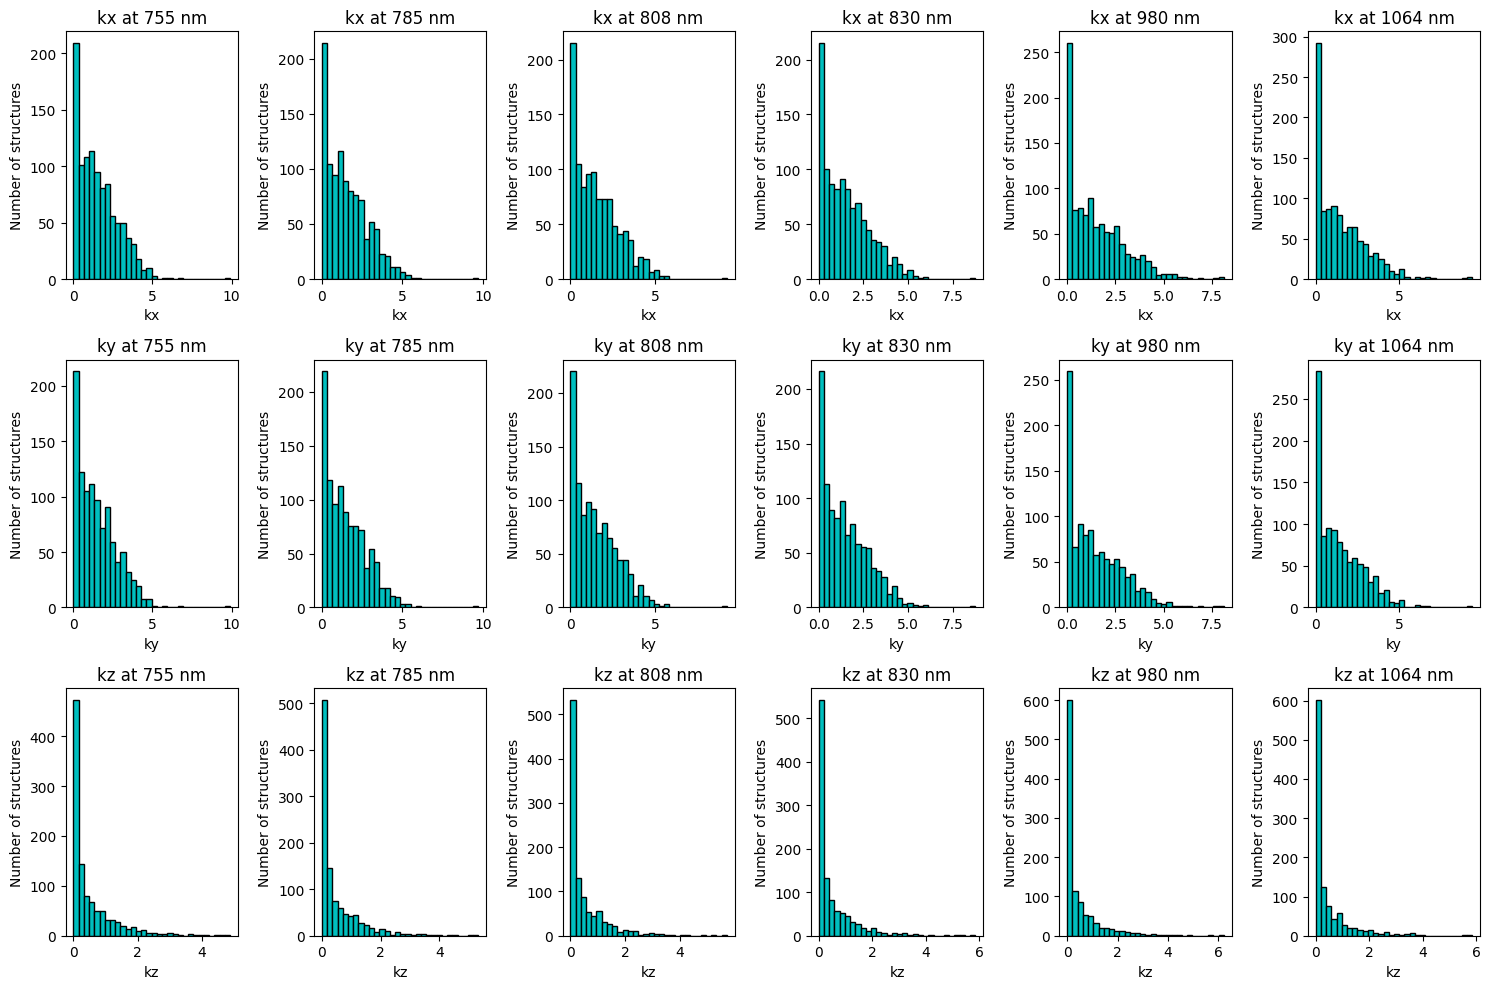

In [37]:
import matplotlib.pyplot as plt

# Wavelengths used in the dataset (in nm)
wavelengths = ['755', '785', '808', '830', '980', '1064']  # Added missing comma between '785' and '808'

# Axes directions
axes = ['x', 'y', 'z']

# Create a 3x3 grid for the histograms
fig, axes_plots = plt.subplots(3, 6, figsize=(15, 10))

# Loop through each axis (x, y, z) and each wavelength to create the histograms
for i, ax_dir in enumerate(axes):
    for j, wavelength in enumerate(wavelengths[:6]):  # Adjust loop to fit 3x3 grid
        # Extract the absorption index data for the current axis and wavelength
        column_name = f'k{ax_dir}_{wavelength}'
        k_values = df[column_name].dropna()  # Ensure there are no NaN values
        
        # Create a histogram on the respective subplot
        axes_plots[i, j].hist(k_values, bins=30, color='c', edgecolor='black')
        
        # Set title, labels for each plot
        axes_plots[i, j].set_title(f'k{ax_dir} at {wavelength} nm')
        axes_plots[i, j].set_xlabel(f'k{ax_dir}')
        axes_plots[i, j].set_ylabel('Number of structures')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [39]:
df_1 = df[df['kx_755'] < 2.0].copy()

In [41]:
df_1.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064    nz_755    nx_755  \
0  3.403833  3.379757  2.574261  3.435819  3.413529  2.703144  3.559991   
1  3.554303  4.264792  2.757543  3.438509  4.327317  2.892107  3.632623   
2  2.774818  2.970205  2.733178  2.875894  3.118526  2.526368  2.599827   
3  3.772258  3.567112  2.629559  3.491887  3.553724  2.643992  3.835528   
4  2.982871  2.974833  2.256140  2.807209  3.034398  2.279759  3.823235   

     ny_755    nz_808    nx_808    ny_808    nz_785    nx_785    ny_785  \
0  3.531993  2.673255  3.503081  3.476003  2.686778  3.536575  3.508975   
1  3.997857  2.866054  3.702381  4.108268  2.877997  3.679736  4.081218   
2  2.749112  2.588455  2.650934  2.795456  2.564391  2.631069  2.777052   
3  3.568295  2.654092  3.952319  3.591232  2.646542  3.906373  3.594239   
4  2.986197  2.314210  3.577047  3.023746  2.305408  3.685950  3.023436   

        A_x           B_x  C_x       A_y            B_y  C_y       A_z  \
0  3.262034  1.611007e+05  1.0  3.245148  154562.154552  1.0  2.440335   
1  3.264960  2.564033e+05  1.0  4.643526 -357176.526221  1.0  2.621372   
2  3.116786 -3.015127e+05  1.0  3.437869 -410552.745551  1.0  2.959752   
3  3.264554  4.034569e+05  1.0  3.532867   31386.004500  1.0  2.652494   
4  1.748993  1.189536e+06  1.0  3.017293   -6035.749831  1.0  2.230419   

             B_z  C_z    kz_755    kx_755    ky_755    kz_785    kx_785  \
0  151170.825573  1.0  0.166514  0.769665  0.771300  0.139424  0.659263   
1  157687.620959  1.0  0.147642  0.900601  1.625390  0.124108  0.787416   
2 -243640.835447  1.0  0.606209  0.925684  1.149580  0.585294  0.929971   
3    -402.881251  1.0  0.438901  1.781804  1.295486  0.430809  1.702726   
4   44369.086985  1.0  0.363129  0.977945  0.948586  0.336083  0.810232   

     ky_785    kz_808    kx_808    ky_808    kz_980    kx_980    ky_980  \
0  0.661092  0.122899  0.600661  0.602678  0.069232  0.513622  0.515974   
1  1.454887  0.106812  0.690122  1.343097  0.042458  0.230537  0.960751   
2  1.144772  0.571304  0.931699  1.145648  0.429411  0.963373  1.199740   
3  1.186887  0.424133  1.622721  1.117784  0.323606  1.191486  0.969091   
4  0.875581  0.313481  0.731238  0.826836  0.2334

In [21]:
df_new.to_csv('c2db_optics_755nm.csv', index=False)

In [13]:
df_new.to_csv('c2db_optics_980nm.csv', index=False)

In [16]:
df_new.to_csv('c2db_optics_1064nm.csv', index=False)

In [9]:
df_785 = pd.read_csv('c2db_optics_785nm.csv', skipinitialspace=True)
df_808 = pd.read_csv('c2db_optics_808nm.csv', skipinitialspace=True)
df_830 = pd.read_csv('c2db_optics_830nm.csv', skipinitialspace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'c2db_optics_785nm.csv'

In [26]:
df_new['nz_785']=df_785['nz_785'].to_numpy()
df_new['nx_785']=df_785['nx_785'].to_numpy()
df_new['ny_785']=df_785['ny_785'].to_numpy()

df_new['nz_808']=df_808['nz_808'].to_numpy()
df_new['nx_808']=df_808['nx_808'].to_numpy()
df_new['ny_808']=df_808['ny_808'].to_numpy()

df_new['nz_830']=df_830['nz_830'].to_numpy()
df_new['nx_830']=df_830['nx_830'].to_numpy()
df_new['ny_830']=df_830['ny_830'].to_numpy()

In [28]:
df_new.to_csv('c2db_optics_6waves.csv', index=False)

In [9]:
df = pd.read_csv('c2db_2elems_finished/c2db_optics_6waves.csv', skipinitialspace=True)

In [6]:
#df = pd.read_csv('c2db_optics_ref_k_ABC.csv', skipinitialspace=True)

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Define the function for n(wavelength) = A + B/wavelength^2 + C/wavelength^4
def n_wavelength(wavelength, A, B, C):
    return A + B/wavelength**2 + C/wavelength**4

wavelengths = np.array([755, 785, 808, 830, 980, 1060])

A_list = []
B_list = []
C_list = []

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    # Extract the refractive indices for the current row (formula/material)
    n_z = np.array([row['nz_755'], row['nz_785'], row['nz_808'], row['nz_830'], row['nz_980'], row['nz_1064']])

    # Perform curve fitting for the current material (nx)
    popt, _ = curve_fit(n_wavelength, wavelengths, n_z)

    # Append the coefficients A, B, C to their respective lists
    A_list.append(popt[0])
    B_list.append(popt[1])
    C_list.append(popt[2])

# Add the coefficients as new columns in the dataframe
df['A_z'] = A_list
df['B_z'] = B_list
df['C_z'] = C_list

# Display the updated dataframe with the coefficients
#import ace_tools as tools; tools.display_dataframe_to_user(name="Fitted Data with Coefficients", dataframe=df)


In [11]:
df.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064    nz_755    nx_755  \
0  3.403833  3.379757  2.574261  3.435819  3.413529  2.703144  3.559991   
1  3.554303  4.264792  2.757543  3.438509  4.327317  2.892107  3.632623   
2  2.774818  2.970205  2.733178  2.875894  3.118526  2.526368  2.599827   
3  3.772258  3.567112  2.629559  3.491887  3.553724  2.643992  3.835528   
4  2.982871  2.974833  2.256140  2.807209  3.034398  2.279759  3.823235   

     ny_755    nz_808    nx_808    ny_808    nz_785    nx_785    ny_785  \
0  3.531993  2.673255  3.503081  3.476003  2.686778  3.536575  3.508975   
1  3.997857  2.866054  3.702381  4.108268  2.877997  3.679736  4.081218   
2  2.749112  2.588455  2.650934  2.795456  2.564391  2.631069  2.777052   
3  3.568295  2.654092  3.952319  3.591232  2.646542  3.906373  3.594239   
4  2.986197  2.314210  3.577047  3.023746  2.305408  3.685950  3.023436   

        A_z            B_z  
0  2.440335  151170.825174  
1  2.621372  157687.623201  
2  2.959752 -243640.835013  
3  2.652496    -404.424077  
4  2.230419   44369.094919

In [41]:
df.to_csv('c2db_optics_ABC.csv', index=False)

In [5]:
df_new = pd.read_csv('c2db_optics_ABC.csv', skipinitialspace=True)

In [6]:
df_new.head()

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
0   c2db/AB4/2PdS4/2   Pd2S8        2/m       True       NaN       NaN   
1   c2db/AB4/2PdS4/1   Pd2S8        2/m       True       NaN       NaN   
2   c2db/AB4/3OsS4/1  Os3S12          1      False  1.058567  0.478198   
3  c2db/AB4/1AlSe4/1   AlSe4          m      False       NaN       NaN   
4   c2db/AB4/1AlS4/1    AlS4          m      False       NaN       NaN   

   icsd_id  cod_id  thickness  lattice_a  lattice_b  lattice_c  num_elements  \
0      NaN     NaN   4.568299   6.022245   6.022245  34.361150             2   
1      NaN     NaN   4.548832   4.220300   7.330839  33.963019             2   
2      NaN     NaN   5.065725   8.004094   7.991983  20.078077             2   
3      NaN     NaN   4.125713   3.513139   6.371351  34.182286             2   
4      NaN     NaN   3.811665   3.277405   6.091516  34.182286             2   

                              fold  vdw_radius  THICKNESS_2D  \
0   c2db/AB4/2PdS4/2/structure.xyz         1.8      8.168299   
1   c2db/AB4/2PdS4/1/structure.xyz         1.8      8.148832   
2   c2db/AB4/3OsS4/1/structure.xyz         1.8      8.665725   
3  c2db/AB4/1AlSe4/1/structure.xyz         1.6      7.325713   
4   c2db/AB4/1AlS4/1/structure.xyz         1.8      7.411665   

           dir_names layer_direction    nz_830    nx_830    ny_830    nz_980  \
0   c2db_AB4_2PdS4_2               z  2.660469  3.468695  3.442202  2.597554   
1   c2db_AB4_2PdS4_1               z  2.854180  3.708206  4.120128  2.787838   
2   c2db_AB4_3OsS4_1               z  2.610579  2.668140  2.812714  2.715365   
3  c2db_AB4_1AlSe4_1               z  2.661991  3.974275  3.582839  2.675446   
4   c2db_AB4_1AlS4_1               z  2.316114  3.480830  3.011104  2.278774   

     nx_980    ny_980   nz_1064   nx_1064   ny_1064    nz_755    nx_755  \
0  3.403833  3.379757  2.574261  3.435819  3.413529  2.703144  3.559991   
1  3.554303  4.264792  2.757543  3.438509  4.327317  2.892107  3.632623   
2  2.774818  2.970205  2.733178  2.875894  3.118526  2.526368  2.599827   
3  3.772258  3.567112  2.629559  3.491887  3.553724  2.643992  3.835528   
4  2.982871  2.974833  2.256140  2.807209  3.034398  2.279759  3.823235   

     ny_755    nz_808    nx_808    ny_808    nz_785    nx_785    ny_785  \
0  3.531993  2.673255  3.503081  3.476003  2.686778  3.536575  3.508975   
1  3.997857  2.866054  3.702381  4.108268  2.877997  3.679736  4.081218   
2  2.749112  2.588455  2.650934  2.795456  2.564391  2.631069  2.777052   
3  3.568295  2.654092  3.952319  3.591232  2.646542  3.906373  3.594239   
4  2.986197  2.314210  3.577047  3.023746  2.305408  3.685950  3.023436   

        A_x           B_x  C_x       A_y            B_y  C_y       A_z  \
0  3.262034  1.611007e+05  1.0  3.245148  154562.154552  1.0  2.440335   
1  3.264960  2.564033e+05  1.0  4.643526 -357176.526221  1.0  2.621372   
2  3.116786 -3.015127e+05  1.0  3.437869 -410552.745551  1.0  2.959752   
3  3.264554  4.034569e+05  1.0  3.532867   31386.004500  1.0  2.652494   
4  1.748993  1.189536e+06  1.0  3.017293   -6035.749831  1.0  2.230419   

             B_z  C_z  
0  151170.825573  1.0  
1  157687.620959  1.0  
2 -243640.835447  1.0  
3    -402.881251  1.0  
4   44369.086985  1.0

In [42]:
df = df_1.copy()

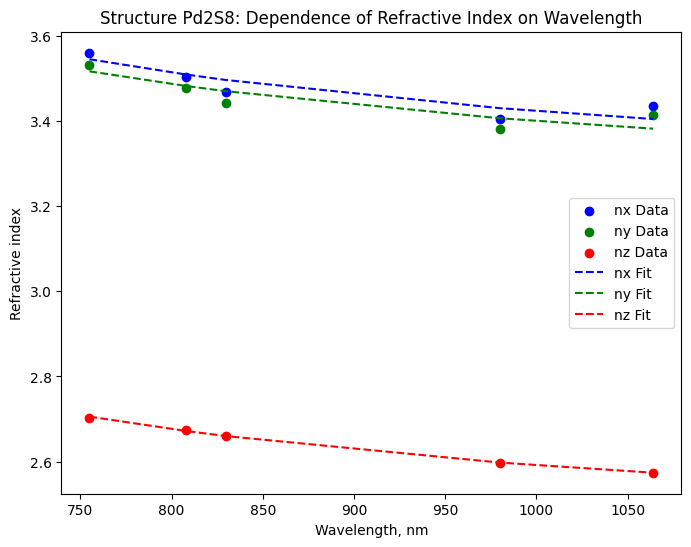

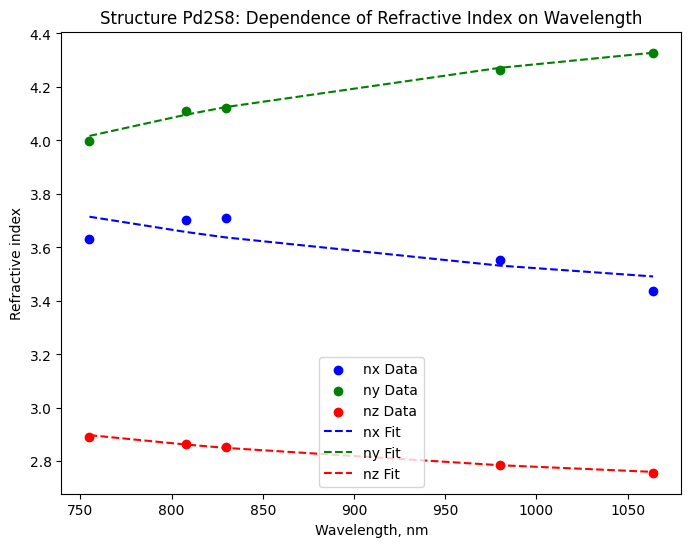

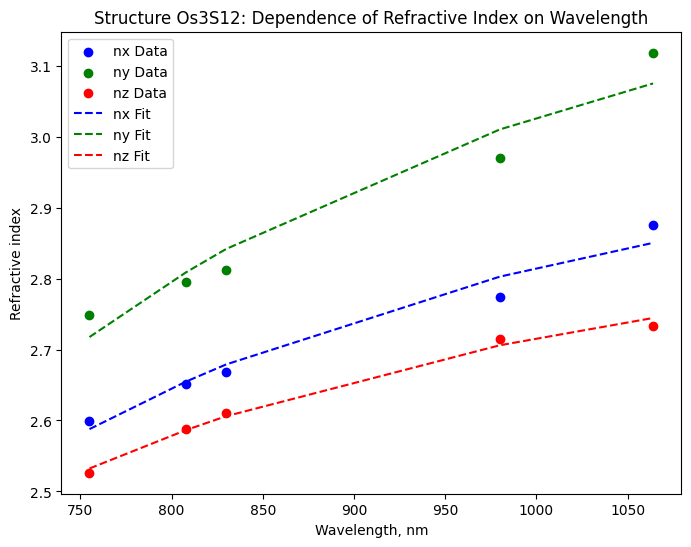

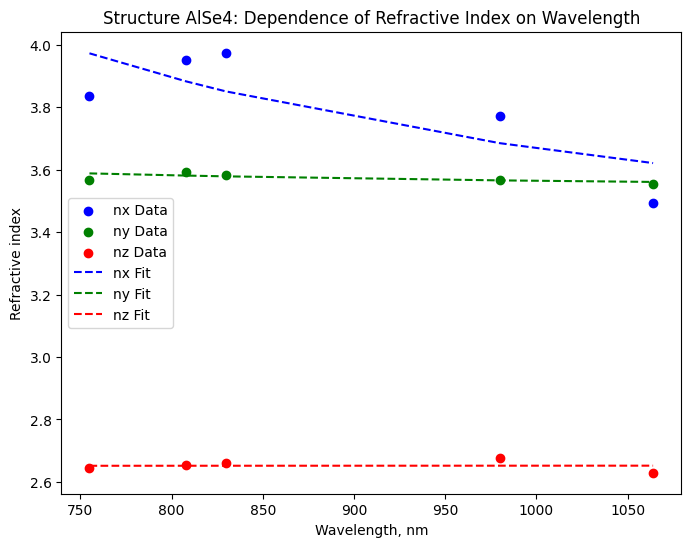

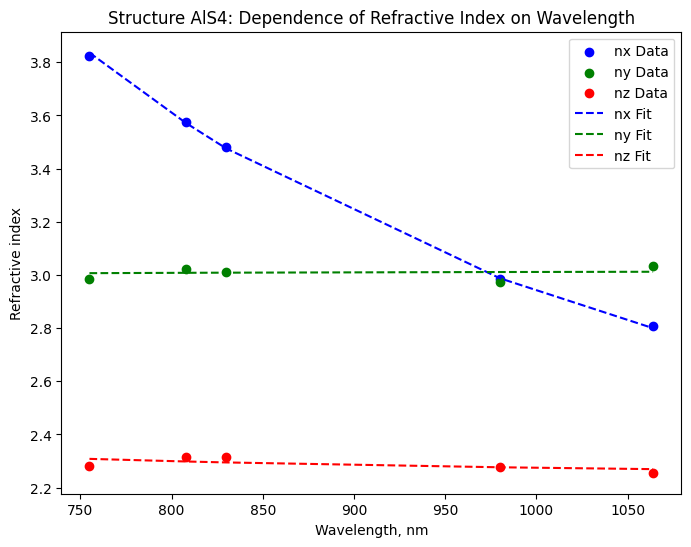

In [43]:
# Define the function for n(wavelength) = A + B/wavelength^2 + C/wavelength^4
def n_wavelength(wavelength, A, B, C):
    return A + B/wavelength**2 + C/wavelength**4

# Assuming df is your dataframe with the data
# Wavelengths used in the dataset (in nm)
wavelengths = np.array([755, 808, 830, 980, 1064])

# Loop through the first 5 structures
for i in range(5):
    row = df.iloc[i]
    formula = df['formula'].iloc[i]
    
    # Extract the refractive index data for nx, ny, nz
    nx = np.array([row['nx_755'], row['nx_808'], row['nx_830'], row['nx_980'], row['nx_1064']])
    ny = np.array([row['ny_755'], row['ny_808'], row['ny_830'], row['ny_980'], row['ny_1064']])
    nz = np.array([row['nz_755'], row['nz_808'], row['nz_830'], row['nz_980'], row['nz_1064']])
    
    # Extract the A, B, C coefficients for x, y, z
    A_x, B_x, C_x = row['A_x'], row['B_x'], row['C_x']
    A_y, B_y, C_y = row['A_y'], row['B_y'], row['C_y']
    A_z, B_z, C_z = row['A_z'], row['B_z'], row['C_z']
    
    # Generate the fitted refractive index values using the equation
    nx_fit = n_wavelength(wavelengths, A_x, B_x, C_x)
    ny_fit = n_wavelength(wavelengths, A_y, B_y, C_y)
    nz_fit = n_wavelength(wavelengths, A_z, B_z, C_z)

    # Create a plot for the current structure
    plt.figure(figsize=(8, 6))
    
    # Plot the original refractive index data
    plt.scatter(wavelengths, nx, color='blue', label='nx Data', marker='o')
    plt.scatter(wavelengths, ny, color='green', label='ny Data', marker='o')
    plt.scatter(wavelengths, nz, color='red', label='nz Data', marker='o')
    
    # Plot the fitted refractive index curves
    plt.plot(wavelengths, nx_fit, color='blue', linestyle='--', label='nx Fit')
    plt.plot(wavelengths, ny_fit, color='green', linestyle='--', label='ny Fit')
    plt.plot(wavelengths, nz_fit, color='red', linestyle='--', label='nz Fit')
    
    # Add labels, title, and legend
    plt.xlabel('Wavelength, nm')
    plt.ylabel('Refractive index')
    plt.title(f'Structure {formula}: Dependence of Refractive Index on Wavelength')
    plt.legend()
    
    # Show the plot
    plt.show()


In [40]:
%cd ../

/home/u7c/lusya/2D_materials/C2DB


/home/u7c/miniconda3/envs/version/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [54]:
print(len(lst_dft))

10


In [56]:
index_list_1 = [0,2,4,6,8]
index_list_2 = [1,3,5,7,9]
d = {'wavelengths': [755, 785, 808, 830, 980], 'n_x_WS2': [lst_dft[i] for i in index_list_1], 'n_x_WSe2': [lst_dft[i] for i in index_list_2]}
df_last = pd.DataFrame(data=d)

In [27]:
df_last.to_csv('WS2_WSe2_waves.csv', index=False)

In [57]:
df_last.head()

wavelengths   n_x_WS2  n_x_WSe2
0          755  4.319343  4.810409
1          785  4.273683  4.750709
2          808  4.245692  4.696264
3          830  4.219427  4.646673
4          980  4.109922  4.424639

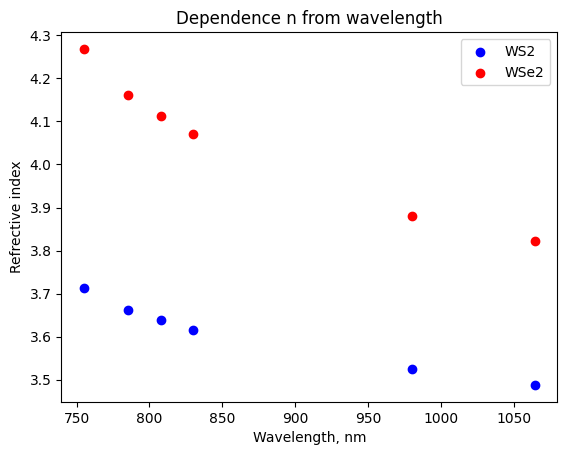

In [29]:
plt.scatter(x = df_last['wavelengths'].to_numpy(), y = df_last['n_x_WS2'].to_numpy(), color = 'blue', label = 'WS2')
plt.scatter(x = df_last['wavelengths'].to_numpy(), y = df_last['n_x_WSe2'].to_numpy(), color = 'red', label = 'WSe2')
plt.xlabel('Wavelength, nm')
plt.ylabel('Refrective index')
plt.title('Dependence n from wavelength')
plt.legend()

In [15]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

/tmp/ipykernel_1227178/1545242310.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_WS2, _ = curve_fit(n_wavelength, wavelengths, n_x_WS2)
/tmp/ipykernel_1227178/1545242310.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_WSe2, _ = curve_fit(n_wavelength, wavelengths, n_x_WSe2)


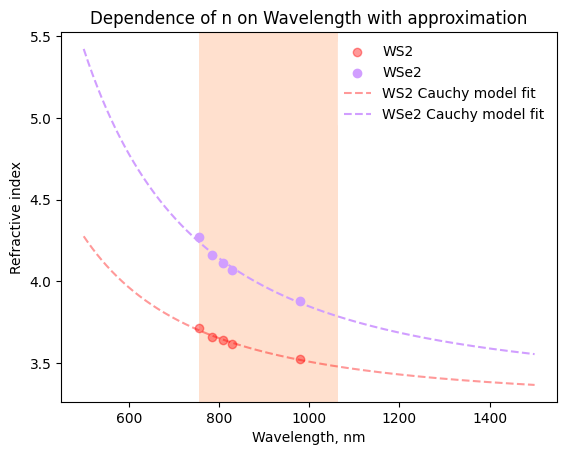

Fitted coefficients for WS2: A = 3.252066, B = 255931.128962, C = 1.000000
Fitted coefficients for WSe2: A = 3.320802, B = 525429.132634, C = 1.000000


In [18]:
from scipy.optimize import curve_fit
def n_wavelength(wavelength, A, B, C):
    return A + B/wavelength**2 + C/wavelength**4


wavelengths = np.array([755, 785, 808, 830, 980])
n_x_WS2 = np.array([3.713779, 3.661788, 3.638310, 3.616283, 3.524479])
n_x_WSe2 = np.array([4.268416, 4.160705, 4.113702, 4.070897, 3.879319])

popt_WS2, _ = curve_fit(n_wavelength, wavelengths, n_x_WS2)
popt_WSe2, _ = curve_fit(n_wavelength, wavelengths, n_x_WSe2)



wavelengths_fit = np.linspace(500, 1500, 500)

n_fit_WS2 = n_wavelength(wavelengths_fit, *popt_WS2)
n_fit_WSe2 = n_wavelength(wavelengths_fit, *popt_WSe2)

plt.axvspan(755, 1064, facecolor='#FFC39E', alpha=0.5)
plt.scatter(wavelengths, n_x_WS2, color='red',alpha=0.4, label='WS2')
plt.scatter(wavelengths, n_x_WSe2, color='#D19EFF', label='WSe2')

plt.plot(wavelengths_fit, n_fit_WS2, color='red', alpha=0.4, linestyle='--', label='WS2 Cauchy model fit')
plt.plot(wavelengths_fit, n_fit_WSe2, color='#D19EFF', linestyle='--', label='WSe2 Cauchy model fit')



plt.xlabel('Wavelength, nm')
plt.ylabel('Refractive index')
plt.title('Dependence of n on Wavelength with approximation')
plt.legend(edgecolor='white')
plt.savefig(f'./monolayer_dispersion.png', dpi=300, facecolor='w', bbox_inches='tight')
# Show plot
plt.show()

print(f"Fitted coefficients for WS2: A = {popt_WS2[0]:.6f}, B = {popt_WS2[1]:.6f}, C = {popt_WS2[2]:.6f}")
print(f"Fitted coefficients for WSe2: A = {popt_WSe2[0]:.6f}, B = {popt_WSe2[1]:.6f}, C = {popt_WSe2[2]:.6f}")

In [20]:
lst_dft = []
lst_dft_1 = []
lst_dft_2 = []
lst_dir = df_new['dir_names'].to_numpy()
dataframes_dict = {}  # Create an empty dictionary to store dataframes

for j, dir_name in enumerate(lst_dir):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = df_new['lattice_c'][j]
    THICKNESS_3D = df_new['THICKNESS_2D'][j]
    vasprun_dft = f'/home/u7c/lusya/2D_materials/C2DB/c2db_2elems_finished/{SYSTEM}/vasprun.xml'
    try:
        analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
        dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
        data = dft_data
        method = data.method
        df = data.real[data.real['Wavelength, nm'].between(740, 760)].iloc[0]
        print(np.abs(df['zz'] - df['xx']))
        lst_dft.append(np.abs(df['xx'] - df['zz']))
        lst_dft_1.append(np.abs(df['yy'] - df['zz']))
        lst_dft_2.append(np.abs(df['yy'] - df['xx']))
    except DataParsingError:
        lst_dft.append(-1)
        lst_dft_1.append(-1)
        lst_dft_2.append(-1)
    except FileNotFoundError:
        lst_dft.append(-2)
        lst_dft_1.append(-2)
        lst_dft_2.append(-2)

In [21]:
df_new['dn_xy']=lst_dft_2
df_new['dn_xz']=lst_dft
df_new['dn_yz']=lst_dft_1

In [20]:
df_new[df_new['formula']=='MoS2']

folder formula pointgroup  inversion   gap_hse   gap_pbe  \
706  c2db/AB2/1MoS2/2    MoS2        -3m       True       NaN  0.000000   
707  c2db/AB2/1MoS2/3    MoS2       -42m      False       NaN  0.000000   
708  c2db/AB2/1MoS2/1    MoS2       -6m2      False  2.087439  1.580389   

     icsd_id     cod_id  thickness  lattice_a  lattice_b  lattice_c  \
706  26622.0        NaN   3.174577   3.188080   3.188080  18.158273   
707      NaN        NaN   2.607949   3.696894   3.696894  18.662813   
708  38401.0  9007661.0   3.127113   3.184066   3.184066  18.127113   

     num_elements                            fold  vdw_radius  THICKNESS_2D  \
706             2  c2db/AB2/1MoS2/2/structure.xyz         1.8      6.774577   
707             2  c2db/AB2/1MoS2/3/structure.xyz         1.8      6.207949   
708             2  c2db/AB2/1MoS2/1/structure.xyz         1.8      6.727113   

            dir_names  dn_xy     dn_xz     dn_yz layer_direction       n_z  \
706  c2db_AB2_1MoS2_2    0.0  0.806108  0.806108               z  3.120856   
707  c2db_AB2_1MoS2_3    0.0  1.118194  1.118194               z  2.646282   
708  c2db_AB2_1MoS2_1    0.0  1.573194  1.573194               z  3.022797   

          n_x       n_y  
706  2.314748  2.314748  
707  1.528088  1.528088  
708  4.595991  4.595991

In [61]:
%cd ../

/home/u7c/lusya/2D_materials/C2DB


/home/u7c/miniconda3/envs/version/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [62]:
df_new.dropna(subset=['vdw_radius'], inplace=True)

# Optional: Reset index
df_new.reset_index(drop=True, inplace=True)

In [63]:
df_new.to_csv('c2db_tmd_optics_1064nm.csv', index=False)

In [51]:
df_new.shape

(1057, 24)

In [30]:
%cd c2db_2elems_finished/

/home/u7c/lusya/2D_materials/C2DB/c2db_2elems_finished


/home/u7c/miniconda3/envs/version/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [31]:
df_n = pd.read_csv('../../MoS_structures/Ermolaev_2D_MoS2_n.csv', skipinitialspace=True)
df_k = pd.read_csv('../../MoS_structures/Ermolaev_2D_MoS2_k.csv', skipinitialspace=True)

In [9]:
import re

def format_chemical_formula(formula):
    if not formula:  # Check for empty string
        return ''

    # Use regular expression to find parts of the formula
    parts = re.findall(r'([A-Za-z]+)([0-9]*)', formula)
    formatted_formula = ''
    for element, subscript in parts:
        if subscript:  # If there is a subscript, add it with braces
            formatted_formula += f'\\mathrm{{{element}}}_{{{subscript}}}'
        else:
            formatted_formula += f'\\mathrm{{{element}}}'
    return f'${formatted_formula}$'


In [10]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

In [11]:
df_new.head()

dir_names  THICKNESS_2D  lattice_c
0       WS2          5.75     12.300
1      WSe2          6.05     12.295

In [19]:
%pwd

'/home/u7c/lusya/2D_materials/C2DB'

WSe2
4.358482786494477


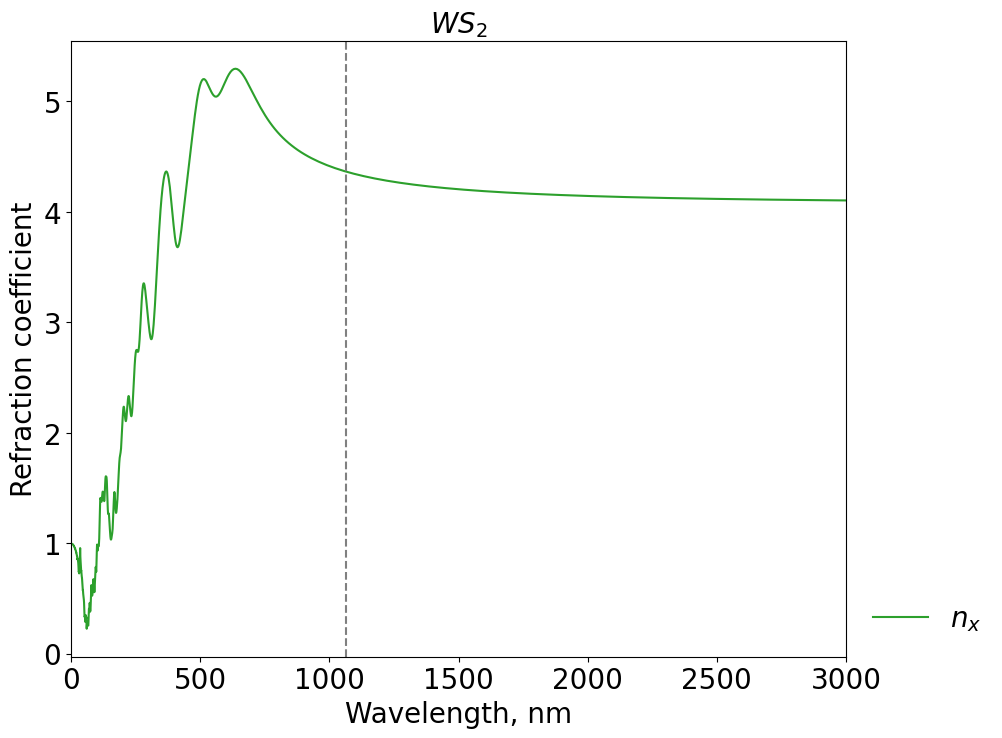

In [14]:
lst_dft = []
lst_dft_1 = []
lst_dft_2 = []
lst_dir =['WSe2']

#path = '/home/u7c/lusya/tmd_embeds/2d_semic_last'
#base_path = '/home/u7c/lusya/tmd_embeds/2d_semic_last'
dataframes_dict = {}  # Create an empty dictionary to store dataframes

for j, dir_name in enumerate(lst_dir):
    #os.chdir(os.path.join(base_path, dir_name))
    SYSTEM = str(dir_name)
    print(SYSTEM)
    analyzer = OpticsAnalyzer(system=SYSTEM)
    THICKNESS_2D = 12.295 #df_new['lattice_c'][j]
    THICKNESS_3D = 6.05 #df_new['THICKNESS_2D'][j]
    vasprun_dft = f'/home/u7c/lusya/2D_materials/C2DB/{SYSTEM}/vasprun.xml'
    #try:
    analyzer.read(vasprun_dft, thickness_2d = THICKNESS_2D, thickness_3d = THICKNESS_3D)
    dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    data = dft_data

    #analyzer.read(vasprun_dft, thickness_2d = 18.13, thickness_3d = 6.72)
    #dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    #data = dft_data
    method = data.method
    #df = data.real[data.real['Wavelength, nm'].between(1050, 1100)].iloc[0]
    #dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
    plt.figure(figsize=(10, 8))

    line = '-'
    line_k = '--'
    colors = ['#8da0cb', '#2ca02c', '#d62728']
    col_exp = ['#4682B4', '#5CAD00', '#8B0000']
    plt.plot(data.real['Wavelength, nm'], data.real['xx'], line, color = colors[1], label='$n_{{x}}$')
    #plt.plot(data.real['Wavelength, nm'], data.real['yy'], line, color = colors[1], label='$n_{{y}}$')
    #plt.plot(data.real['Wavelength, nm'], data.real['zz'], line, color = colors[0], label='$n_{{z}}$')
    #plt.plot(df_n['wl']*1000, df_n['n'], color = col_exp[2], label='$n_{exp_{x}}$')
    #plt.plot(df_y['Wavelength'], df_y['n_yy'], line_k, color = colors[1], label='$n_{exp_{y}}$')
    #plt.plot(df_z['Wavelength'], df_z['n_zz'], line_k, color = colors[0], label='$n_{exp_{z}}$')
    
    
    #plt.plot(data.imag['Wavelength, nm'], data.imag['xx'], line_k, color = colors[1], label='$k_{{x}}$')
    #plt.plot(data.imag['Wavelength, nm'], data.imag['yy'], line_k, color = colors[1], label='$k_{{y}}$')
   # plt.plot(data.imag['Wavelength, nm'], data.imag['zz'], line_k, color = colors[0], label='$k_{{z}}$')
    #plt.plot(df_k['wl']*1000, df_k['k'], line_k, color = col_exp[2], label='$k_{exp_{x}}$')
    #plt.plot(df_y['Wavelength'], df_y['k_yy'], line_k, color = col_exp[1], label='$k_{exp_{y}}$')
    #plt.plot(df_z['Wavelength'], df_z['k_zz'], line_k, color = col_exp[0], label='$k_{exp_{z}}$')


    plt.xlim(0, 3000)
    #plt.ylim(0, 4)

    plt.xlabel('Wavelength, nm', fontsize=20)
    plt.ylabel('Refraction coefficient', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc=(1.02, 0.02), edgecolor='white', fontsize=20)
    delta_n_value = data.real[data.real['Wavelength, nm'].between(1050, 1075)].iloc[0]
    print(delta_n_value['xx'])
    #plt.title('$Ta_{{2}}NiSe_{{5}}$', fontsize=20)
    #plt.title('$MoTe_{{2}}$', fontsize=20)
    SYSTEM_2 = format_chemical_formula(SYSTEM)
    plt.title('$WS_{{2}}$', fontsize=20)
    plt.axvline(x=1064, color='grey', linestyle='--', label=f'x = 1064 nm')
    SYSTEM_2 = format_chemical_formula(SYSTEM)
    plt.savefig(f'./{SYSTEM}_dn_dk.png', dpi=100, facecolor='w', bbox_inches='tight')
    
    plt.show()
    df = data.real[data.real['Wavelength, nm'].between(0, 2000)]
    #print(df)
    #print(np.abs(df['zz'] - df['xx']))
    #lst_dft.append(np.abs(df['yy'] - df['zz']))
    #lst_dft_1.append(np.abs(df['yy'] - df['zz']))
    #lst_dft_2.append(np.abs(df['yy'] - df['xx']))
    #df_dn = pd.read_csv(f'TMD_materials/id_prop_comp_space.csv', skipinitialspace=True)
    #df_shg = pd.read_csv('id_prop_shg_с7.csv', names = ['poscar', 'shg'], skipinitialspace=True)
    #df_j = pd.DataFrame([df_dn.poscar, df_dn.dn, df_dn.spacegroup, df_dn.formula]).transpose()
    #dataframes_dict[dir_name] = df_j

In [11]:
df.head()

Wavelength, nm        xx        yy        zz        xy   yz   zx
30     1953.371141  3.924211  3.925900  2.994709  2.602359  0.0  0.0
31     1890.243902  3.927919  3.929634  2.995637  2.572056  0.0  0.0
32     1831.339536  3.931759  3.933473  2.996601  2.543096  0.0  0.0
33     1775.741085  3.935759  3.937498  2.997637  2.515428  0.0  0.0
34     1723.658604  3.939919  3.941628  2.998671  2.488962  0.0  0.0

In [15]:
df[['Wavelength, nm', 'xx']].to_csv('WSe2_DFT_data.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [34]:
df_2[df_2['dn_yz']==-1.0]['optimized_2D_structure_uuid']

4      427c0e79-63db-488e-8ef2-716128914c86
88     f4f6d7af-3932-4a02-8505-60330f1733d8
120    acccd248-74b3-46b1-a7e0-df5c2541571b
152    cfd8caf1-6437-429f-9750-39caa57dbb8e
160    84df6d7d-922e-4c52-aabb-ff982df4ff3f
172    f128762c-2e2a-495c-a386-7254d049ba7d
Name: optimized_2D_structure_uuid, dtype: object

In [77]:
df_2[(df_2['dn_yz']==-2.0)|(df_2['dn_yz']==-1.0)]['optimized_2D_structure_uuid'].index.to_numpy()

array([  4,   5,  11,  36,  41,  48,  54,  56,  62,  78,  79,  85,  88,
        93, 106, 109, 111, 120, 121, 131, 151, 152, 160, 172])

In [78]:
df_2

initial_3D_db_id           3D_formula    3D_volume  layer_dir_3D  \
0              413359              Sb2 N18   291.256950       7.69980   
1              637823          Ge2 Sb2 Te5   259.092631      16.96000   
2               24755               Nb1 S2    57.005556       6.24000   
3               85302              Sb8 S12   487.815154      11.31500   
4             4110939             Ho4 Te12   465.100462      25.30400   
5              155326            Ta18 Te36  1400.605049      14.79200   
6             9009116              Te2 Pt1    72.427956       5.20100   
7              153457            Si12 As12   536.868456      15.97900   
8             2310589               Pd4 S8   227.841820       7.53100   
9               76730              Ni6 Te6   263.357355      20.20000   
10            9000077              Fe9 S12   359.756522      34.50000   
11             406353            Al16 Te24  1307.068182      14.16700   
12            9014575              Nb2 Se4   129.390248      12.58100   
13            1531163          Tl2 Co4 Se4   197.295641      13.44010   
14              65739              Ta4 Se2   111.992625       9.83200   
15            9008967              In4 Se4   240.490340      16.93000   
16            1010275               Ti1 S2    56.873547       5.69100   
17             626718              Cr1 Se2    59.181737       5.91500   
18             650091              Re4 Se8   240.490925      25.50000   
19              74517             Sc6 Cl18   626.621184      17.78990   
20             642015             La8 Te20   891.149257      44.70000   
21            9013424             Bi8 Se12   562.230214      11.83000   
22            9015549              As8 S12   488.377219      10.26820   
23              26082              Sb6 I18  1012.698376      20.90000   
24            5910026              Zr1 Se2    66.757451       5.85000   
25            9012193               W2 Se4   120.896238      12.96000   
26             649404             Pr8 Te20   867.813787      44.30000   
27            9011287              Te2 Au1    72.010376       5.00000   
28             644259               Mo2 S4   106.815449      12.30500   
29             645529              Nb1 Te2    77.522493       6.61000   
30            9011965              Bi6 Se9   425.669812      28.63600   
31            9009117              Pt1 Se2    60.795596       5.06200   
32            7206470               Sn2 O2    72.518706       4.89400   
33            9009115              Te2 Pd1    72.332936       5.12620   
34            1008063              Ti1 Te2    80.279435       6.49800   
35            2310355               Te8 W4   309.003539      14.07000   
36             639768             Ho8 Te20   876.145153      45.03000   
37            9008785               Sn4 S4   192.669412      11.18000   
38              44885              Fe9 S12   367.064867      34.60000   
39            2310358             Ta6 Te12   473.778726       9.37700   
40            9015804              Sr1 O10   238.598597       6.41000   
41             652655             Sm8 Te20   833.384527      43.80000   
42            9009119              Si1 Te2   106.448780       6.71000   
43            9012392           Tl2 Cu4 S4   190.872722      13.37910   
44             629124          Tl2 Cu4 Se4   208.857249      14.03800   
45            9009113              Ni1 Te2    68.384899       5.29700   
46            1528768              Ge4 Se4   180.533964      10.79000   
47             651956              Ta2 Se4   129.849182      12.73700   
48              82871             Sb16 S24  1216.668780      11.47000   
49              42075              Hf2 Se6   187.309898       9.42800   
50             638846               Hf2 S6   162.806430       8.96700   
51              15014              Sn12 P9   481.686214      35.33100   
52            1528582               Sn2 F8   130.071825       7.93000   
53             190890             Te10 Ir5   355.251618      14

In [79]:
lst_i = [ 0, 159, 129, 94, 76,73, 21, 4,   5,  11,  36,  41,  48,  54,  56,  62,  78,  79,  85,  88,
        93, 106, 109, 111, 120, 121, 131, 151, 152, 160, 172]

In [39]:
#lst_i = df_2[(df_2['dn_yz']==-2.0)|(df_2['dn_yz']==-1.0)]['optimized_2D_structure_uuid'].index.to_numpy()

In [80]:
df_new = df_2.drop(index=lst_i)

In [84]:
df_new.to_csv('monolayers_optics_database.csv', index=False)

In [83]:
%cd ../

/home/u7c/lusya/2D_materials


In [10]:
SYSTEM = 'MoS2'
WORKDIR = '01.final_run/'
THICKNESS = 7.0
analyzer = OpticsAnalyzer(system=SYSTEM)
vasprun_pbe = f'./{WORKDIR}/vasprun.PBE.xml'
vasprun_gw = f'./{WORKDIR}/vasprun.G0W0.xml'
vasprun_bse = f'./{WORKDIR}/vasprun.BSE.xml'
analyzer.read(vasprun_pbe, thickness=THICKNESS)
analyzer.read(vasprun_gw, thickness=THICKNESS)
analyzer.read(vasprun_bse, thickness=THICKNESS)
#analyzer.read('/home/xpanceo/lusya/2D_materials/2H-MoS2-2/IPA/vasprun.xml', thickness=THICKNESS)

In [11]:
dft_data = convert_epsilon_to_refractive_index(analyzer.data[0])
gw_micro_data = convert_epsilon_to_refractive_index(analyzer.data[1])
gw_macro_data = convert_epsilon_to_refractive_index(analyzer.data[2])
bse_data = convert_epsilon_to_refractive_index(analyzer.data[3])
#dft_data_lusya = convert_epsilon_to_refractive_index(analyzer.data[4])

# dft_data_1 = convert_epsilon_to_refractive_index(analyzer.data[0])
# dft_data_2 = convert_epsilon_to_refractive_index(analyzer.data[1])
# dft_data_2 = convert_epsilon_to_refractive_index(analyzer.data[1])
# dft_data_3 = convert_epsilon_to_refractive_index(analyzer.data[2])
# dft_data_4 = convert_epsilon_to_refractive_index(analyzer.data[3])
# dft_data_5 = convert_epsilon_to_refractive_index(analyzer.data[4])

In [12]:
n_exp = pd.read_csv('Ermolaev_2D_MoS2_n.csv')
k_exp = pd.read_csv('Ermolaev_2D_MoS2_k.csv')

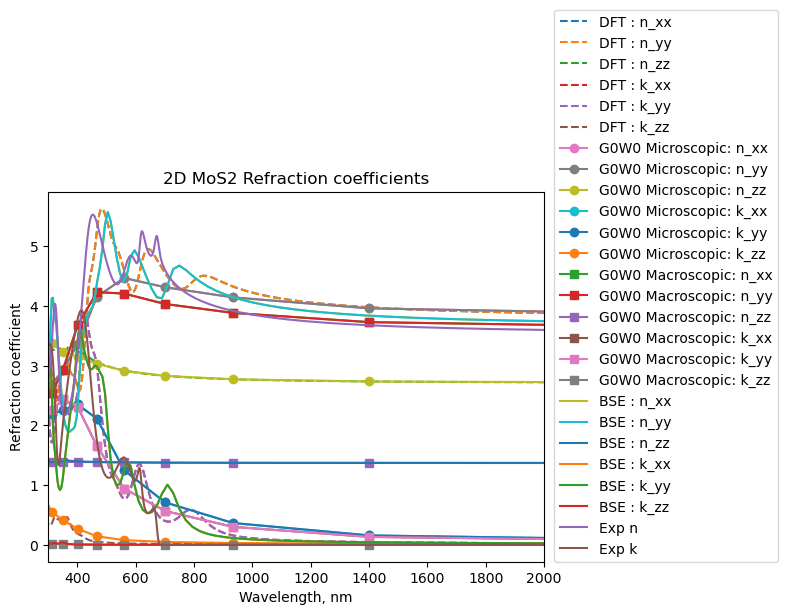

In [15]:
fig, ax = plt.subplots()
plot_data(ax, dft_data, line='--')
#plot_data(ax, dft_data_lusya, line='-.')
# plot_data(ax, dft_data_2, line='--')
# plot_data(ax, dft_data_3, line='-.')
# plot_data(ax, dft_data_3, line='o-')
# plot_data(ax, dft_data_3, line='s-')
plot_data(ax, gw_micro_data, line='o-')
plot_data(ax, gw_macro_data, line='s-')
plot_data(ax, bse_data, line='-')

plt.xlim(300, 2000)

plt.plot(n_exp['wl']*1000, n_exp['n'], label='Exp n')
plt.plot(k_exp['wl']*1000, k_exp['k'], label='Exp k')

plt.xlabel('Wavelength, nm')
plt.ylabel('Refraction coefficient')
plt.legend(loc=(1.02, 0.0))
plt.title(f'2D {SYSTEM} Refraction coefficients')
#plt.savefig(f'./{SYSTEM}/{SYSTEM}_n_k.png', dpi=100, facecolor='w', bbox_inches='tight')
plt.show()


In [16]:
analyzer.write(folder=f'./01.final_run/results', refraction=True)